In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.engine as ue
import utils.engine0d as ue0d
import utils.visualizer as uv

In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [3]:
data = pd.read_csv('Validation/full_data.csv')

In [4]:
data.columns

Index(['jday', 'uair', 'tair', 'qair', 'lwdo', 'swdo', 'prec', 'Focn_x',
       'albe', 'hs_best', 'hf_best', 'hi_best', 'hs_x', 'hi_x', 'hs_level',
       'hf_level', 'hi_level', 'Tss', 'Tis', 'Tib', 'Tsurf', 'hs_y', 'hi_y',
       'hf', 'Fcss', 'Fcsb', 'Fcis', 'Fcib', 'Fmib', 'Focn_y', 'Trod', 'Fcsf',
       'Tocn', 'focn_pit', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7',
       'T_8', 'T_9', 'T_10', 'T_11', 'T_12', 'T_13', 'T_14', 'T_15', 'T_16',
       'T_17', 'T_18', 'T_19', 'T_20', 'T_21', 'T_22', 'T_23', 'T_24', 'T_25',
       'T_26', 'T_27', 'T_28', 'T_29', 'T_30', 'T_31', 'T_32', 'T_33', 'T_34',
       'T_35', 'T_36', 'T_37', 'T_38', 'T_39', 'T_40', 'T_41', 'T_42', 'T_43',
       'T_44', 'T_45', 'T_46', 'T_47', 'T_48', 'T_49', 'T_50', 'fsen', 'flat',
       'Tib_interp', 'Tis_interp', 'Tss_interp', 'prec_eff'],
      dtype='object')

In [5]:
with open("Validation/SHEBA_Data/12-levels.dat") as file:
    Z = [float(z.replace(' ', '')[:-1]) for z in file.readlines()]

In [27]:
-ue.L_i(ue.Tf_i(30.0), 10.0)

224891.46666666665

## Вспомогательные функции

In [6]:
def get_init_from_data(data, Z, dsigma_ice, dsigma_snow, snow_thickness_threshold=0.05, index=0):
    
    has_snow = (data.loc[index, 'hs_best'] - data.loc[index, 'hf_best']) >= snow_thickness_threshold
    
    filter_ice = (data.loc[index, 'hi_best'] < Z) & (Z < data.loc[index, 'hf_best'])
    filter_snow = (data.loc[index, 'hf_best'] < Z) & (Z < data.loc[index, 'hs_best'])

    Z_ice = np.concatenate((data.loc[index, ['hf_best']],
                            np.array(Z)[filter_ice],
                            data.loc[index, ['hi_best']]))

    Z_snow = np.concatenate((data.loc[index, ['hs_best']],
                            np.array(Z)[filter_snow],
                            data.loc[index, ['hf_best']]))

    T_ice = np.concatenate((data.loc[index, ['Tis_interp']],
                            data.loc[index, 'T_1':'T_50'][filter_ice],
                            data.loc[index, ['Tib_interp']]))

    T_snow = np.concatenate((data.loc[index, ['Tss']],
                             data.loc[index, 'T_1':'T_50'][filter_snow],
                             data.loc[index, ['Tis_interp']]))

    sigma_ice_nodes = np.concatenate(([0.0], dsigma_ice.cumsum()))
    sigma_ice_centers = (sigma_ice_nodes[:-1] + sigma_ice_nodes[1:])/2
    Z_ice_new = Z_ice[-1] + sigma_ice_centers*(Z_ice[0] - Z_ice[-1])

    sigma_snow_nodes = np.concatenate(([0.0], dsigma_snow.cumsum()))
    sigma_snow_centers = (sigma_snow_nodes[:-1] + sigma_snow_nodes[1:])/2
    Z_snow_new = Z_snow[-1] + sigma_snow_centers*(Z_snow[0] - Z_snow[-1])

    T_ice_new = np.interp(Z_ice_new, Z_ice[::-1], T_ice[::-1])
    T_snow_new = np.interp(Z_snow_new, Z_snow[::-1], T_snow[::-1])
    
    return T_ice_new, T_snow_new, \
            data.loc[index, 'Tib_interp'], data.loc[index, 'Tis_interp'], \
            (data.loc[index, 'Tss'] if has_snow else np.nan), \
            dsigma_ice*(data.loc[index, 'hf_best'] - data.loc[index, 'hi_best']), \
            (1.0 if has_snow else np.nan)*dsigma_snow \
            *(data.loc[index, 'hs_best'] - data.loc[index, 'hf_best'])

In [7]:
def compare_profiles(process_data, process_simulation):
    assert process_data.get_length() == process_simulation.get_length(), \
           "Lenghts of input arrays ({}, {}) should be equal!".format(process_data.get_length(),
                                                                      process_simulation.get_length())
    
    assert process_data.get_nodes_num() == process_simulation.get_nodes_num(), \
           "Numbers of nodes for snow and ice for two processes ({}, {}) should be equal!"\
           .format(process_data.get_nodes_num(), process_simulation.get_nodes_num())
    
    plt.figure(figsize=(35, 50))
    
    plt.subplot(5, 2, 1)
    plt.title("Min temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.min(axis=1) - process_simulation.ice_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 2)
    plt.title("Min temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.min(axis=1) - process_simulation.snow_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 3)
    plt.title("Max temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.max(axis=1) - process_simulation.ice_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 4)
    plt.title("Max temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.max(axis=1) - process_simulation.snow_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 5)
    plt.title("Max temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             abs(process_data.ice_temp_history - process_simulation.ice_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 6)
    plt.title("Max temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             abs(process_data.snow_temp_history - process_simulation.snow_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 7)
    plt.title("Avg temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.ice_temp_history - process_simulation.ice_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 8)
    plt.title("Avg temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.snow_temp_history - process_simulation.snow_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 9)
    plt.title("Thickness error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_dz_history.sum(axis=1) - process_simulation.ice_dz_history.sum(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 10)
    plt.title("Thickness error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_dz_history.sum(axis=1) - process_simulation.snow_dz_history.sum(axis=1))
    plt.grid()
    
    plt.show()

In [8]:
def plot_thicknesses(data_proc, sim_proc):
    plt.figure(figsize=(15, 10))
    plt.title('Ice thickness')
    plt.plot(sim_proc.ice_dz_history.sum(axis=1), label='simulation')
    plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.title('Snow thickness')
    plt.plot(sim_proc.snow_dz_history.sum(axis=1), label='simulation')
    plt.plot(data_proc.snow_dz_history.sum(axis=1), label='data')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# timeline from file
time_arr = ((data['jday'] - data.loc[0, 'jday'])*24*3600).values

In [10]:
# mesh thickening function
def thickening(N, s):
    if s == 0:
        return np.full(N, 1/N)
    else:
        return np.array([s*(1 - s)**i/(1 - (1 - s)**N) for i in range(N)])

In [11]:
def plot_thickening(N, max_thick, step_thick):

    plt.figure(figsize=(10, 6))
    for s in np.arange(0, max_thick, step_thick):
        plt.plot([s]*(N+1), np.insert(np.cumsum(thickening(N, s)), 0,  0.0), marker='x', color='black')
    plt.xticks(np.arange(0, max_thick, step_thick))
    plt.xlabel('Level of thickening', size=20)
    plt.ylabel('Sigma-coordinate', size=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    plt.grid(ls='--')
    plt.show()

## Форсинг

In [12]:
# forcing
e_s = lambda T: 6.11*np.exp(ue.c1_i*T/(T + ue.T0 - ue.c2_i))
q_surf = lambda T: 0.622*e_s(T)/(ue.P_surf - 0.378*e_s(T))

albe = data['albe'].values
Tib_interp = data['Tib_interp'].values
tair = data['tair'].values
uair = data['uair'].values
qair = data['qair'].values
prec = data['prec_eff'].values
swdo = data['swdo'].values
lwdo = data['lwdo'].values
focn_pit = data['focn_pit'].values
Focn_y = data['Focn_y'].values


find_index_fast = lambda time_sec: np.searchsorted(time_arr, time_sec, side='right') - 1
albedo = lambda time: albe[find_index_fast(time)]
Toi = lambda time: Tib_interp[find_index_fast(time)]
T_a = lambda time: tair[find_index_fast(time)] - ue.T0
u_a = lambda time: uair[find_index_fast(time)]
q_a = lambda time: qair[find_index_fast(time)] * 1e-3
p = lambda time: prec[find_index_fast(time)] * ue.mmd_to_ms
F_sw = lambda time: swdo[find_index_fast(time)]
F_lw = lambda time: lwdo[find_index_fast(time)]
F_bolz = lambda T: -ue.sigma*(T + ue.T0)**4
F_sh = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*u_a(time)*(T_a(time) - T)
F_lh = lambda T, time: ue.rho_a*ue.L_s0*ue.C_lh*u_a(time)*(q_a(time) - q_surf(T))
F_P = lambda T, time: p(time)*ue.rho_w*ue.c_pw*max(T_a(time) - T, 0)
F_atm = lambda T, time, i_0: ue.emissivity*(F_lw(time) + F_bolz(T)) \
                           + (1 - albedo(time))*(1 - i_0)*F_sw(time) \
                           + F_sh(T, time) + F_P(T, time) + F_lh(T, time) 

F_atm_ice = lambda T, time: F_atm(T, time, ue.i0_i)
F_atm_snow = lambda T, time: F_atm(T, time, ue.i0_s)
F_ocn = lambda T, time: Focn_y[find_index_fast(time)]

# Эксперименты на регулярной сетке

In [13]:
# regular mesh
dsigma_ice_n4s0 = thickening(4, 0.0)
dsigma_ice_n8s0 = thickening(8, 0.0)
dsigma_ice_n16s0 = thickening(16, 0.0)
dsigma_ice_n32s0 = thickening(32, 0.0)
dsigma_ice_n64s0 = thickening(64, 0.0)
dsigma_snow_n10s0 = thickening(10, 0.0)

In [28]:
# init state from data
T_ice_init4, T_snow_init4, Toi_init4, Tis_init4, Tsa_init4, \
dzi_init4, dzs_init4 = get_init_from_data(data, Z, dsigma_ice_n4s0, dsigma_snow_n10s0)

T_ice_init8, T_snow_init8, Toi_init8, Tis_init8, Tsa_init8, \
dzi_init8, dzs_init8 = get_init_from_data(data, Z, dsigma_ice_n8s0, dsigma_snow_n10s0)

T_ice_init16, T_snow_init16, Toi_init16, Tis_init16, Tsa_init16, \
dzi_init16, dzs_init16 = get_init_from_data(data, Z, dsigma_ice_n16s0, dsigma_snow_n10s0)

T_ice_init32, T_snow_init32, Toi_init32, Tis_init32, Tsa_init32, \
dzi_init32, dzs_init32 = get_init_from_data(data, Z, dsigma_ice_n32s0, dsigma_snow_n10s0)

T_ice_init64, T_snow_init64, Toi_init64, Tis_init64, Tsa_init64, \
dzi_init64, dzs_init64 = get_init_from_data(data, Z, dsigma_ice_n64s0, dsigma_snow_n10s0)

In [14]:
# process from data
data_proc_ni4s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n4s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni8s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n8s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni16s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n16s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni32s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n32s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni64s0ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n64s0, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

[[0.485    0.485    0.485    0.485   ]
 [0.485025 0.485025 0.485025 0.485025]
 [0.48505  0.48505  0.48505  0.48505 ]
 ...
 [0.376675 0.376675 0.376675 0.376675]
 [0.376675 0.376675 0.376675 0.376675]
 [0.37665  0.37665  0.37665  0.37665 ]]
[[0.016   0.016   0.016   ... 0.016   0.016   0.016  ]
 [0.01598 0.01598 0.01598 ... 0.01598 0.01598 0.01598]
 [0.01596 0.01596 0.01596 ... 0.01596 0.01596 0.01596]
 ...
 [0.01167 0.01167 0.01167 ... 0.01167 0.01167 0.01167]
 [0.01167 0.01167 0.01167 ... 0.01167 0.01167 0.01167]
 [0.01168 0.01168 0.01168 ... 0.01168 0.01168 0.01168]]
[[0.2425    0.2425    0.2425    ... 0.2425    0.2425    0.2425   ]
 [0.2425125 0.2425125 0.2425125 ... 0.2425125 0.2425125 0.2425125]
 [0.242525  0.242525  0.242525  ... 0.242525  0.242525  0.242525 ]
 ...
 [0.1883375 0.1883375 0.1883375 ... 0.1883375 0.1883375 0.1883375]
 [0.1883375 0.1883375 0.1883375 ... 0.1883375 0.1883375 0.1883375]
 [0.188325  0.188325  0.188325  ... 0.188325  0.188325  0.188325 ]]
[[0.016   0.016 

In [39]:
%%time
sim_proc_0d = ue0d.main_process_0d \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Tis_init=data.loc[0, 'Tis_interp'],
    Tsa_init=data.loc[0, 'Tss'],
    ice_thickness_init=data.loc[0, 'hf_best'] - data.loc[0, 'hi_best'],
    snow_thickness_init=data.loc[0, 'hs_best'] - data.loc[0, 'hf_best'],
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_ocn=F_ocn
)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice freezing...
Time 260.0 h.: Snow-ice freezing...
Time 261.0 h.: Snow-ice freezing...
Time 262.0 h.: Snow-ice freezing...
Time 263.0 h.: Snow-ice freezing...
Time 264.0 h.: Snow-ice freezing...
Time 265.0 h.: Snow-ice freezing...
Time 266.0 h.: Snow-ice freezing...
Time 267.0 h.: Snow-ice freezing...
Time 268.0 h.: Snow-ice freezing...
Time 269.0 h.: Snow-ice freezing...
Time 270.0 h.: Snow-ice freezing...
Time 271.0 h.: Snow-ice freezing...
Time 272.0 h.: Snow-ice freezing...
Time 273.0 h.: Snow-ice freezing...
Time 274.0 h.: Snow-ice freezing...
Time 275.0 h.: Snow-ice free

Time 486.0 h.: Snow-ice freezing...
Time 487.0 h.: Snow-ice freezing...
Time 488.0 h.: Snow-ice freezing...
Time 489.0 h.: Snow-ice freezing...
Time 490.0 h.: Snow-ice freezing...
Time 491.0 h.: Snow-ice freezing...
Time 492.0 h.: Snow-ice freezing...
Time 493.0 h.: Snow-ice freezing...
Time 494.0 h.: Snow-ice freezing...
Time 495.0 h.: Snow-ice freezing...
Time 496.0 h.: Snow-ice freezing...
Time 497.0 h.: Snow-ice freezing...
Time 498.0 h.: Snow-ice freezing...
Time 499.0 h.: Snow-ice freezing...
Time 500.0 h.: Snow-ice freezing...
Time 501.0 h.: Snow-ice freezing...
Time 502.0 h.: Snow-ice freezing...
Time 503.0 h.: Snow-ice freezing...
Time 504.0 h.: Snow-ice freezing...
Time 505.0 h.: Snow-ice freezing...
Time 506.0 h.: Snow-ice freezing...
Time 507.0 h.: Snow-ice freezing...
Time 508.0 h.: Snow-ice freezing...
Time 509.0 h.: Snow-ice freezing...
Time 510.0 h.: Snow-ice freezing...
Time 511.0 h.: Snow-ice freezing...
Time 512.0 h.: Snow-ice freezing...
Time 513.0 h.: Snow-ice free

Time 739.0 h.: Snow-ice freezing...
Time 740.0 h.: Snow-ice freezing...
Time 741.0 h.: Snow-ice freezing...
Time 742.0 h.: Snow-ice freezing...
Time 743.0 h.: Snow-ice freezing...
Time 744.0 h.: Snow-ice freezing...
Time 745.0 h.: Snow-ice freezing...
Time 746.0 h.: Snow-ice freezing...
Time 747.0 h.: Snow-ice freezing...
Time 748.0 h.: Snow-ice freezing...
Time 749.0 h.: Snow-ice freezing...
Time 750.0 h.: Snow-ice freezing...
Time 751.0 h.: Snow-ice freezing...
Time 752.0 h.: Snow-ice freezing...
Time 753.0 h.: Snow-ice freezing...
Time 754.0 h.: Snow-ice freezing...
Time 755.0 h.: Snow-ice freezing...
Time 756.0 h.: Snow-ice freezing...
Time 757.0 h.: Snow-ice freezing...
Time 758.0 h.: Snow-ice freezing...
Time 759.0 h.: Snow-ice freezing...
Time 760.0 h.: Snow-ice freezing...
Time 761.0 h.: Snow-ice freezing...
Time 762.0 h.: Snow-ice freezing...
Time 763.0 h.: Snow-ice freezing...
Time 764.0 h.: Snow-ice freezing...
Time 765.0 h.: Snow-ice freezing...
Time 766.0 h.: Snow-ice free

Time 994.0 h.: Snow-ice freezing...
Time 995.0 h.: Snow-ice freezing...
Time 996.0 h.: Snow-ice freezing...
Time 997.0 h.: Snow-ice freezing...
Time 998.0 h.: Snow-ice freezing...
Time 999.0 h.: Snow-ice freezing...
Time 1000.0 h.: Snow-ice freezing...
Time 1001.0 h.: Snow-ice freezing...
Time 1002.0 h.: Snow-ice freezing...
Time 1003.0 h.: Snow-ice freezing...
Time 1004.0 h.: Snow-ice freezing...
Time 1005.0 h.: Snow-ice freezing...
Time 1006.0 h.: Snow-ice freezing...
Time 1007.0 h.: Snow-ice freezing...
Time 1008.0 h.: Snow-ice freezing...
Time 1009.0 h.: Snow-ice freezing...
Time 1010.0 h.: Snow-ice freezing...
Time 1011.0 h.: Snow-ice freezing...
Time 1012.0 h.: Snow-ice freezing...
Time 1013.0 h.: Snow-ice freezing...
Time 1014.0 h.: Snow-ice freezing...
Time 1015.0 h.: Snow-ice freezing...
Time 1016.0 h.: Snow-ice freezing...
Time 1017.0 h.: Snow-ice freezing...
Time 1018.0 h.: Snow-ice freezing...
Time 1019.0 h.: Snow-ice freezing...
Time 1020.0 h.: Snow-ice freezing...
Time 10

Time 1242.0 h.: Snow-ice freezing...
Time 1243.0 h.: Snow-ice freezing...
Time 1244.0 h.: Snow-ice freezing...
Time 1245.0 h.: Snow-ice freezing...
Time 1246.0 h.: Snow-ice freezing...
Time 1247.0 h.: Snow-ice freezing...
Time 1248.0 h.: Snow-ice freezing...
Time 1249.0 h.: Snow-ice freezing...
Time 1250.0 h.: Snow-ice freezing...
Time 1251.0 h.: Snow-ice freezing...
Time 1252.0 h.: Snow-ice freezing...
Time 1253.0 h.: Snow-ice freezing...
Time 1254.0 h.: Snow-ice freezing...
Time 1255.0 h.: Snow-ice freezing...
Time 1256.0 h.: Snow-ice freezing...
Time 1257.0 h.: Snow-ice freezing...
Time 1258.0 h.: Snow-ice freezing...
Time 1259.0 h.: Snow-ice freezing...
Time 1260.0 h.: Snow-ice freezing...
Time 1261.0 h.: Snow-ice freezing...
Time 1262.0 h.: Snow-ice freezing...
Time 1263.0 h.: Snow-ice freezing...
Time 1264.0 h.: Snow-ice freezing...
Time 1265.0 h.: Snow-ice freezing...
Time 1266.0 h.: Snow-ice freezing...
Time 1267.0 h.: Snow-ice freezing...
Time 1268.0 h.: Snow-ice freezing...
T

Time 1487.0 h.: Snow-ice freezing...
Time 1488.0 h.: Snow-ice freezing...
Time 1489.0 h.: Snow-ice freezing...
Time 1490.0 h.: Snow-ice freezing...
Time 1491.0 h.: Snow-ice freezing...
Time 1492.0 h.: Snow-ice freezing...
Time 1493.0 h.: Snow-ice freezing...
Time 1494.0 h.: Snow-ice freezing...
Time 1495.0 h.: Snow-ice freezing...
Time 1496.0 h.: Snow-ice freezing...
Time 1497.0 h.: Snow-ice freezing...
Time 1498.0 h.: Snow-ice freezing...
Time 1499.0 h.: Snow-ice freezing...
Time 1500.0 h.: Snow-ice freezing...
Time 1501.0 h.: Snow-ice freezing...
Time 1502.0 h.: Snow-ice freezing...
Time 1503.0 h.: Snow-ice freezing...
Time 1504.0 h.: Snow-ice freezing...
Time 1505.0 h.: Snow-ice freezing...
Time 1506.0 h.: Snow-ice freezing...
Time 1507.0 h.: Snow-ice freezing...
Time 1508.0 h.: Snow-ice freezing...
Time 1509.0 h.: Snow-ice freezing...
Time 1510.0 h.: Snow-ice freezing...
Time 1511.0 h.: Snow-ice freezing...
Time 1512.0 h.: Snow-ice freezing...
Time 1513.0 h.: Snow-ice freezing...
T

Time 1723.0 h.: Snow-ice freezing...
Time 1724.0 h.: Snow-ice freezing...
Time 1725.0 h.: Snow-ice freezing...
Time 1726.0 h.: Snow-ice freezing...
Time 1727.0 h.: Snow-ice freezing...
Time 1728.0 h.: Snow-ice freezing...
Time 1729.0 h.: Snow-ice freezing...
Time 1730.0 h.: Snow-ice freezing...
Time 1731.0 h.: Snow-ice freezing...
Time 1732.0 h.: Snow-ice freezing...
Time 1733.0 h.: Snow-ice freezing...
Time 1734.0 h.: Snow-ice freezing...
Time 1735.0 h.: Snow-ice freezing...
Time 1736.0 h.: Snow-ice freezing...
Time 1737.0 h.: Snow-ice freezing...
Time 1738.0 h.: Snow-ice freezing...
Time 1739.0 h.: Snow-ice freezing...
Time 1740.0 h.: Snow-ice freezing...
Time 1741.0 h.: Snow-ice freezing...
Time 1742.0 h.: Snow-ice freezing...
Time 1743.0 h.: Snow-ice freezing...
Time 1744.0 h.: Snow-ice freezing...
Time 1745.0 h.: Snow-ice freezing...
Time 1746.0 h.: Snow-ice freezing...
Time 1747.0 h.: Snow-ice freezing...
Time 1748.0 h.: Snow-ice freezing...
Time 1749.0 h.: Snow-ice freezing...
T

Time 1953.0 h.: Snow-ice freezing...
Time 1954.0 h.: Snow-ice freezing...
Time 1955.0 h.: Snow-ice freezing...
Time 1956.0 h.: Snow-ice freezing...
Time 1957.0 h.: Snow-ice freezing...
Time 1958.0 h.: Snow-ice freezing...
Time 1959.0 h.: Snow-ice freezing...
Time 1960.0 h.: Snow-ice freezing...
Time 1961.0 h.: Snow-ice freezing...
Time 1962.0 h.: Snow-ice freezing...
Time 1963.0 h.: Snow-ice freezing...
Time 1964.0 h.: Snow-ice freezing...
Time 1965.0 h.: Snow-ice freezing...
Time 1966.0 h.: Snow-ice freezing...
Time 1967.0 h.: Snow-ice freezing...
Time 1968.0 h.: Snow-ice freezing...
Time 1969.0 h.: Snow-ice freezing...
Time 1970.0 h.: Snow-ice freezing...
Time 1971.0 h.: Snow-ice freezing...
Time 1972.0 h.: Snow-ice freezing...
Time 1973.0 h.: Snow-ice freezing...
Time 1974.0 h.: Snow-ice freezing...
Time 1975.0 h.: Snow-ice freezing...
Time 1976.0 h.: Snow-ice freezing...
Time 1977.0 h.: Snow-ice freezing...
Time 1978.0 h.: Snow-ice freezing...
Time 1979.0 h.: Snow-ice freezing...
T

Time 2207.0 h.: Snow-ice freezing...
Time 2208.0 h.: Snow-ice freezing...
Time 2209.0 h.: Snow-ice freezing...
Time 2210.0 h.: Snow-ice freezing...
Time 2211.0 h.: Snow-ice freezing...
Time 2212.0 h.: Snow-ice freezing...
Time 2213.0 h.: Snow-ice freezing...
Time 2214.0 h.: Snow-ice freezing...
Time 2215.0 h.: Snow-ice freezing...
Time 2216.0 h.: Snow-ice freezing...
Time 2217.0 h.: Snow-ice freezing...
Time 2218.0 h.: Snow-ice freezing...
Time 2219.0 h.: Snow-ice freezing...
Time 2220.0 h.: Snow-ice freezing...
Time 2221.0 h.: Snow-ice freezing...
Time 2222.0 h.: Snow-ice freezing...
Time 2223.0 h.: Snow-ice freezing...
Time 2224.0 h.: Snow-ice freezing...
Time 2225.0 h.: Snow-ice freezing...
Time 2226.0 h.: Snow-ice freezing...
Time 2227.0 h.: Snow-ice freezing...
Time 2228.0 h.: Snow-ice freezing...
Time 2229.0 h.: Snow-ice freezing...
Time 2230.0 h.: Snow-ice freezing...
Time 2231.0 h.: Snow-ice freezing...
Time 2232.0 h.: Snow-ice freezing...
Time 2233.0 h.: Snow-ice freezing...
T

Time 2435.0 h.: Snow-ice freezing...
Time 2436.0 h.: Snow-ice freezing...
Time 2437.0 h.: Snow-ice freezing...
Time 2438.0 h.: Snow-ice freezing...
Time 2439.0 h.: Snow-ice freezing...
Time 2440.0 h.: Snow-ice freezing...
Time 2441.0 h.: Snow-ice freezing...
Time 2442.0 h.: Snow-ice freezing...
Time 2443.0 h.: Snow-ice freezing...
Time 2444.0 h.: Snow-ice freezing...
Time 2445.0 h.: Snow-ice freezing...
Time 2446.0 h.: Snow-ice freezing...
Time 2447.0 h.: Snow-ice freezing...
Time 2448.0 h.: Snow-ice freezing...
Time 2449.0 h.: Snow-ice freezing...
Time 2450.0 h.: Snow-ice freezing...
Time 2451.0 h.: Snow-ice freezing...
Time 2452.0 h.: Snow-ice freezing...
Time 2453.0 h.: Snow-ice freezing...
Time 2454.0 h.: Snow-ice freezing...
Time 2455.0 h.: Snow-ice freezing...
Time 2456.0 h.: Snow-ice freezing...
Time 2457.0 h.: Snow-ice freezing...
Time 2458.0 h.: Snow-ice freezing...
Time 2459.0 h.: Snow-ice freezing...
Time 2460.0 h.: Snow-ice freezing...
Time 2461.0 h.: Snow-ice freezing...
T

Time 2660.0 h.: Snow-ice freezing...
Time 2661.0 h.: Snow-ice freezing...
Time 2662.0 h.: Snow-ice freezing...
Time 2663.0 h.: Snow-ice freezing...
Time 2664.0 h.: Snow-ice freezing...
Time 2665.0 h.: Snow-ice freezing...
Time 2666.0 h.: Snow-ice freezing...
Time 2667.0 h.: Snow-ice freezing...
Time 2668.0 h.: Snow-ice freezing...
Time 2669.0 h.: Snow-ice freezing...
Time 2670.0 h.: Snow-ice freezing...
Time 2671.0 h.: Snow-ice freezing...
Time 2672.0 h.: Snow-ice freezing...
Time 2673.0 h.: Snow-ice freezing...
Time 2674.0 h.: Snow-ice freezing...
Time 2675.0 h.: Snow-ice freezing...
Time 2676.0 h.: Snow-ice freezing...
Time 2677.0 h.: Snow-ice freezing...
Time 2678.0 h.: Snow-ice freezing...
Time 2679.0 h.: Snow-ice freezing...
Time 2680.0 h.: Snow-ice freezing...
Time 2681.0 h.: Snow-ice freezing...
Time 2682.0 h.: Snow-ice freezing...
Time 2683.0 h.: Snow-ice freezing...
Time 2684.0 h.: Snow-ice freezing...
Time 2685.0 h.: Snow-ice freezing...
Time 2686.0 h.: Snow-ice freezing...
T

Time 2897.0 h.: Snow-ice freezing...
Time 2898.0 h.: Snow-ice freezing...
Time 2899.0 h.: Snow-ice freezing...
Time 2900.0 h.: Snow-ice freezing...
Time 2901.0 h.: Snow-ice freezing...
Time 2902.0 h.: Snow-ice freezing...
Time 2903.0 h.: Snow-ice freezing...
Time 2904.0 h.: Snow-ice freezing...
Time 2905.0 h.: Snow-ice freezing...
Time 2906.0 h.: Snow-ice freezing...
Time 2907.0 h.: Snow-ice freezing...
Time 2908.0 h.: Snow-ice freezing...
Time 2909.0 h.: Snow-ice freezing...
Time 2910.0 h.: Snow-ice freezing...
Time 2911.0 h.: Snow-ice freezing...
Time 2912.0 h.: Snow-ice freezing...
Time 2913.0 h.: Snow-ice freezing...
Time 2914.0 h.: Snow-ice freezing...
Time 2915.0 h.: Snow-ice freezing...
Time 2916.0 h.: Snow-ice freezing...
Time 2917.0 h.: Snow-ice freezing...
Time 2918.0 h.: Snow-ice freezing...
Time 2919.0 h.: Snow-ice freezing...
Time 2920.0 h.: Snow-ice freezing...
Time 2921.0 h.: Snow-ice freezing...
Time 2922.0 h.: Snow-ice freezing...
Time 2923.0 h.: Snow-ice freezing...
T

Time 3119.0 h.: Snow-ice freezing...
Time 3120.0 h.: Snow-ice freezing...
Time 3121.0 h.: Snow-ice freezing...
Time 3122.0 h.: Snow-ice freezing...
Time 3123.0 h.: Snow-ice freezing...
Time 3124.0 h.: Snow-ice freezing...
Time 3125.0 h.: Snow-ice freezing...
Time 3126.0 h.: Snow-ice freezing...
Time 3127.0 h.: Snow-ice freezing...
Time 3128.0 h.: Snow-ice freezing...
Time 3129.0 h.: Snow-ice freezing...
Time 3130.0 h.: Snow-ice freezing...
Time 3131.0 h.: Snow-ice freezing...
Time 3132.0 h.: Snow-ice freezing...
Time 3133.0 h.: Snow-ice freezing...
Time 3134.0 h.: Snow-ice freezing...
Time 3135.0 h.: Snow-ice freezing...
Time 3136.0 h.: Snow-ice freezing...
Time 3137.0 h.: Snow-ice freezing...
Time 3138.0 h.: Snow-ice freezing...
Time 3139.0 h.: Snow-ice freezing...
Time 3140.0 h.: Snow-ice freezing...
Time 3141.0 h.: Snow-ice freezing...
Time 3142.0 h.: Snow-ice freezing...
Time 3143.0 h.: Snow-ice freezing...
Time 3144.0 h.: Snow-ice freezing...
Time 3145.0 h.: Snow-ice freezing...
T

Time 3364.0 h.: Snow-ice freezing...
Time 3365.0 h.: Snow-ice freezing...
Time 3366.0 h.: Snow-ice freezing...
Time 3367.0 h.: Snow-ice freezing...
Time 3368.0 h.: Snow-ice freezing...
Time 3369.0 h.: Snow-ice freezing...
Time 3370.0 h.: Snow-ice freezing...
Time 3371.0 h.: Snow-ice freezing...
Time 3372.0 h.: Snow-ice freezing...
Time 3373.0 h.: Snow-ice freezing...
Time 3374.0 h.: Snow-ice freezing...
Time 3375.0 h.: Snow-ice freezing...
Time 3376.0 h.: Snow-ice freezing...
Time 3377.0 h.: Snow-ice freezing...
Time 3378.0 h.: Snow-ice freezing...
Time 3379.0 h.: Snow-ice freezing...
Time 3380.0 h.: Snow-ice freezing...
Time 3381.0 h.: Snow-ice freezing...
Time 3382.0 h.: Snow-ice freezing...
Time 3383.0 h.: Snow-ice freezing...
Time 3384.0 h.: Snow-ice freezing...
Time 3385.0 h.: Snow-ice freezing...
Time 3386.0 h.: Snow-ice freezing...
Time 3387.0 h.: Snow-ice freezing...
Time 3388.0 h.: Snow-ice freezing...
Time 3389.0 h.: Snow-ice freezing...
Time 3390.0 h.: Snow-ice freezing...
T

Time 3587.0 h.: Snow-ice freezing...
Time 3588.0 h.: Snow-ice freezing...
Time 3589.0 h.: Snow-ice freezing...
Time 3590.0 h.: Snow-ice freezing...
Time 3591.0 h.: Snow-ice freezing...
Time 3592.0 h.: Snow-ice freezing...
Time 3593.0 h.: Snow-ice freezing...
Time 3594.0 h.: Snow-ice freezing...
Time 3595.0 h.: Snow-ice freezing...
Time 3596.0 h.: Snow-ice freezing...
Time 3597.0 h.: Snow-ice freezing...
Time 3598.0 h.: Snow-ice freezing...
Time 3599.0 h.: Snow-ice freezing...
Time 3600.0 h.: Snow-ice freezing...
Time 3601.0 h.: Snow-ice freezing...
Time 3602.0 h.: Snow-ice freezing...
Time 3603.0 h.: Snow-ice freezing...
Time 3604.0 h.: Snow-ice freezing...
Time 3605.0 h.: Snow-ice freezing...
Time 3606.0 h.: Snow-ice freezing...
Time 3607.0 h.: Snow-ice freezing...
Time 3608.0 h.: Snow-ice freezing...
Time 3609.0 h.: Snow-ice freezing...
Time 3610.0 h.: Snow-ice freezing...
Time 3611.0 h.: Snow-ice freezing...
Time 3612.0 h.: Snow-ice freezing...
Time 3613.0 h.: Snow-ice freezing...
T

Time 3824.0 h.: Snow-ice freezing...
Time 3825.0 h.: Snow-ice freezing...
Time 3826.0 h.: Snow-ice freezing...
Time 3827.0 h.: Snow-ice freezing...
Time 3828.0 h.: Snow-ice freezing...
Time 3829.0 h.: Snow-ice freezing...
Time 3830.0 h.: Snow-ice freezing...
Time 3831.0 h.: Snow-ice freezing...
Time 3832.0 h.: Snow-ice freezing...
Time 3833.0 h.: Snow-ice freezing...
Time 3834.0 h.: Snow-ice freezing...
Time 3835.0 h.: Snow-ice freezing...
Time 3836.0 h.: Snow-ice freezing...
Time 3837.0 h.: Snow-ice freezing...
Time 3838.0 h.: Snow-ice freezing...
Time 3839.0 h.: Snow-ice freezing...
Time 3840.0 h.: Snow-ice freezing...
Time 3841.0 h.: Snow-ice freezing...
Time 3842.0 h.: Snow-ice freezing...
Time 3843.0 h.: Snow-ice freezing...
Time 3844.0 h.: Snow-ice freezing...
Time 3845.0 h.: Snow-ice freezing...
Time 3846.0 h.: Snow-ice freezing...
Time 3847.0 h.: Snow-ice freezing...
Time 3848.0 h.: Snow-ice freezing...
Time 3849.0 h.: Snow-ice freezing...
Time 3850.0 h.: Snow-ice freezing...
T

Time 4053.0 h.: Snow-ice freezing...
Time 4054.0 h.: Snow-ice freezing...
Time 4055.0 h.: Snow-ice freezing...
Time 4056.0 h.: Snow-ice freezing...
Time 4057.0 h.: Snow-ice freezing...
Time 4058.0 h.: Snow-ice freezing...
Time 4059.0 h.: Snow-ice freezing...
Time 4060.0 h.: Snow-ice freezing...
Time 4061.0 h.: Snow-ice freezing...
Time 4062.0 h.: Snow-ice freezing...
Time 4063.0 h.: Snow-ice freezing...
Time 4064.0 h.: Snow-ice freezing...
Time 4065.0 h.: Snow-ice freezing...
Time 4066.0 h.: Snow-ice freezing...
Time 4067.0 h.: Snow-ice freezing...
Time 4068.0 h.: Snow-ice freezing...
Time 4069.0 h.: Snow-ice freezing...
Time 4070.0 h.: Snow-ice freezing...
Time 4071.0 h.: Snow-ice freezing...
Time 4072.0 h.: Snow-ice freezing...
Time 4073.0 h.: Snow-ice freezing...
Time 4074.0 h.: Snow-ice freezing...
Time 4075.0 h.: Snow-ice freezing...
Time 4076.0 h.: Snow-ice freezing...
Time 4077.0 h.: Snow-ice freezing...
Time 4078.0 h.: Snow-ice freezing...
Time 4079.0 h.: Snow-ice freezing...
T

Time 4282.0 h.: Snow-ice freezing...
Time 4283.0 h.: Snow-ice freezing...
Time 4284.0 h.: Snow-ice freezing...
Time 4285.0 h.: Snow-ice freezing...
Time 4286.0 h.: Snow-ice freezing...
Time 4287.0 h.: Snow-ice freezing...
Time 4288.0 h.: Snow-ice freezing...
Time 4289.0 h.: Snow-ice freezing...
Time 4290.0 h.: Snow-ice freezing...
Time 4291.0 h.: Snow-ice freezing...
Time 4292.0 h.: Snow-ice freezing...
Time 4293.0 h.: Snow-ice freezing...
Time 4294.0 h.: Snow-ice freezing...
Time 4295.0 h.: Snow-ice freezing...
Time 4296.0 h.: Snow-ice freezing...
Time 4297.0 h.: Snow-ice freezing...
Time 4298.0 h.: Snow-ice freezing...
Time 4299.0 h.: Snow-ice freezing...
Time 4300.0 h.: Snow-ice freezing...
Time 4301.0 h.: Snow-ice freezing...
Time 4302.0 h.: Snow-ice freezing...
Time 4303.0 h.: Snow-ice freezing...
Time 4304.0 h.: Snow-ice freezing...
Time 4305.0 h.: Snow-ice freezing...
Time 4306.0 h.: Snow-ice freezing...
Time 4307.0 h.: Snow-ice freezing...
Time 4308.0 h.: Snow-ice freezing...
T

Time 4519.0 h.: Snow-ice freezing...
Time 4520.0 h.: Snow-ice freezing...
Time 4521.0 h.: Snow-ice freezing...
Time 4522.0 h.: Snow-ice freezing...
Time 4523.0 h.: Snow-ice freezing...
Time 4524.0 h.: Snow-ice freezing...
Time 4525.0 h.: Snow-ice freezing...
Time 4526.0 h.: Snow-ice freezing...
Time 4527.0 h.: Snow-ice freezing...
Time 4528.0 h.: Snow-ice freezing...
Time 4529.0 h.: Snow-ice freezing...
Time 4530.0 h.: Snow-ice freezing...
Time 4531.0 h.: Snow-ice freezing...
Time 4532.0 h.: Snow-ice freezing...
Time 4533.0 h.: Snow-ice freezing...
Time 4534.0 h.: Snow-ice freezing...
Time 4535.0 h.: Snow-ice freezing...
Time 4536.0 h.: Snow-ice freezing...
Time 4537.0 h.: Snow-ice freezing...
Time 4538.0 h.: Snow-ice freezing...
Time 4539.0 h.: Snow-ice freezing...
Time 4540.0 h.: Snow-ice freezing...
Time 4541.0 h.: Snow-ice freezing...
Time 4542.0 h.: Snow-ice freezing...
Time 4543.0 h.: Snow-ice freezing...
Time 4544.0 h.: Snow-ice freezing...
Time 4545.0 h.: Snow-ice freezing...
T

Time 4757.0 h.: Snow-ice freezing...
Time 4758.0 h.: Snow-ice freezing...
Time 4759.0 h.: Snow-ice freezing...
Time 4760.0 h.: Snow-ice freezing...
Time 4761.0 h.: Snow-ice freezing...
Time 4762.0 h.: Snow-ice freezing...
Time 4763.0 h.: Snow-ice freezing...
Time 4764.0 h.: Snow-ice freezing...
Time 4765.0 h.: Snow-ice freezing...
Time 4766.0 h.: Snow-ice freezing...
Time 4767.0 h.: Snow-ice freezing...
Time 4768.0 h.: Snow-ice freezing...
Time 4769.0 h.: Snow-ice freezing...
Time 4770.0 h.: Snow-ice freezing...
Time 4771.0 h.: Snow-ice freezing...
Time 4772.0 h.: Snow-ice freezing...
Time 4773.0 h.: Snow-ice freezing...
Time 4774.0 h.: Snow-ice freezing...
Time 4775.0 h.: Snow-ice freezing...
Time 4776.0 h.: Snow-ice freezing...
Time 4777.0 h.: Snow-ice freezing...
Time 4778.0 h.: Snow-ice freezing...
Time 4779.0 h.: Snow-ice freezing...
Time 4780.0 h.: Snow-ice freezing...
Time 4781.0 h.: Snow-ice freezing...
Time 4782.0 h.: Snow-ice freezing...
Time 4783.0 h.: Snow-ice freezing...
T

Time 4986.0 h.: Snow-ice freezing...
Time 4987.0 h.: Snow-ice freezing...
Time 4988.0 h.: Snow-ice freezing...
Time 4989.0 h.: Snow-ice freezing...
Time 4990.0 h.: Snow-ice freezing...
Time 4991.0 h.: Snow-ice freezing...
Time 4992.0 h.: Snow-ice freezing...
Time 4993.0 h.: Snow-ice freezing...
Time 4994.0 h.: Snow-ice freezing...
Time 4995.0 h.: Snow-ice freezing...
Time 4996.0 h.: Snow-ice freezing...
Time 4997.0 h.: Snow-ice freezing...
Time 4998.0 h.: Snow-ice freezing...
Time 4999.0 h.: Snow-ice freezing...
Time 5000.0 h.: Snow-ice freezing...
Time 5001.0 h.: Snow-ice freezing...
Time 5002.0 h.: Snow-ice freezing...
Time 5003.0 h.: Snow-ice freezing...
Time 5004.0 h.: Snow-ice freezing...
Time 5005.0 h.: Snow-ice freezing...
Time 5006.0 h.: Snow-ice freezing...
Time 5007.0 h.: Snow-ice freezing...
Time 5008.0 h.: Snow-ice freezing...
Time 5009.0 h.: Snow-ice freezing...
Time 5010.0 h.: Snow-ice freezing...
Time 5011.0 h.: Snow-ice freezing...
Time 5012.0 h.: Snow-ice freezing...
T

Time 5151.0 h.: Snow-ice freezing...
Time 5152.0 h.: Snow-ice freezing...
Time 5153.0 h.: Snow-ice freezing...
Time 5153.0 h.: Snow-ice melting...
Time 5154.0 h.: Snow-ice freezing...
Time 5154.0 h.: Snow-ice melting...
Time 5155.0 h.: Snow-ice freezing...
Time 5155.0 h.: Snow-ice melting...
Time 5156.0 h.: Snow-ice freezing...
Time 5156.0 h.: Snow-ice melting...
Time 5157.0 h.: Snow-ice freezing...
Time 5157.0 h.: Snow-ice melting...
Time 5158.0 h.: Snow-ice freezing...
Time 5158.0 h.: Snow-ice melting...
Time 5159.0 h.: Snow-ice freezing...
Time 5159.0 h.: Snow-ice melting...
Time 5160.0 h.: Snow-ice freezing...
Time 5160.0 h.: Snow-ice melting...
Time 5161.0 h.: Snow-ice freezing...
Time 5161.0 h.: Snow-ice melting...
Time 5162.0 h.: Snow-ice freezing...
Time 5162.0 h.: Snow-ice melting...
Time 5163.0 h.: Snow-ice freezing...
Time 5163.0 h.: Snow-ice melting...
Time 5164.0 h.: Snow-ice freezing...
Time 5164.0 h.: Snow-ice melting...
Time 5165.0 h.: Snow-ice freezing...
Time 5165.0 h

Time 5282.0 h.: Snow-ice freezing...
Time 5282.0 h.: Snow-ice melting...
Time 5283.0 h.: Snow-ice freezing...
Time 5283.0 h.: Snow-ice melting...
Time 5284.0 h.: Snow-ice freezing...
Time 5284.0 h.: Snow-ice melting...
Time 5285.0 h.: Snow-ice freezing...
Time 5286.0 h.: Snow-ice freezing...
Time 5287.0 h.: Snow-ice freezing...
Time 5288.0 h.: Snow-ice freezing...
Time 5289.0 h.: Snow-ice freezing...
Time 5290.0 h.: Snow-ice freezing...
Time 5291.0 h.: Snow-ice freezing...
Time 5292.0 h.: Snow-ice freezing...
Time 5293.0 h.: Snow-ice freezing...
Time 5294.0 h.: Snow-ice freezing...
Time 5295.0 h.: Snow-ice freezing...
Time 5296.0 h.: Snow-ice freezing...
Time 5297.0 h.: Snow-ice freezing...
Time 5297.0 h.: Snow-ice melting...
Time 5298.0 h.: Snow-ice freezing...
Time 5298.0 h.: Snow-ice melting...
Time 5299.0 h.: Snow-ice freezing...
Time 5299.0 h.: Snow-ice melting...
Time 5300.0 h.: Snow-ice freezing...
Time 5300.0 h.: Snow-ice melting...
Time 5301.0 h.: Snow-ice freezing...
Time 530

Time 5444.0 h.: Ice melting...
Time 5445.0 h.: Ice freezing...
Time 5445.0 h.: Ice melting...
Time 5446.0 h.: Ice freezing...
Time 5446.0 h.: Ice melting...
Time 5447.0 h.: Ice freezing...
Time 5447.0 h.: Ice melting...
Time 5448.0 h.: Ice freezing...
Time 5448.0 h.: Ice melting...
Time 5449.0 h.: Ice freezing...
Time 5449.0 h.: Ice melting...
Time 5450.0 h.: Ice freezing...
Time 5450.0 h.: Ice melting...
Time 5451.0 h.: Ice freezing...
Time 5451.0 h.: Ice melting...
Time 5452.0 h.: Ice freezing...
Time 5452.0 h.: Ice melting...
Time 5453.0 h.: Ice freezing...
Time 5454.0 h.: Ice freezing...
Time 5455.0 h.: Ice freezing...
Time 5456.0 h.: Ice freezing...
Time 5457.0 h.: Ice freezing...
Time 5458.0 h.: Ice freezing...
Time 5459.0 h.: Ice freezing...
Time 5460.0 h.: Ice freezing...
Time 5461.0 h.: Ice freezing...
Time 5462.0 h.: Ice freezing...
Time 5463.0 h.: Ice freezing...
Time 5464.0 h.: Ice freezing...
Time 5465.0 h.: Ice freezing...
Time 5465.0 h.: Ice melting...
Time 5466.0 h.: Ic

Time 5627.0 h.: Ice freezing...
Time 5628.0 h.: Ice freezing...
Time 5628.0 h.: Ice melting...
Time 5629.0 h.: Ice freezing...
Time 5629.0 h.: Ice melting...
Time 5630.0 h.: Ice freezing...
Time 5630.0 h.: Ice melting...
Time 5631.0 h.: Ice freezing...
Time 5631.0 h.: Ice melting...
Time 5632.0 h.: Ice freezing...
Time 5632.0 h.: Ice melting...
Time 5633.0 h.: Ice freezing...
Time 5633.0 h.: Ice melting...
Time 5634.0 h.: Ice freezing...
Time 5634.0 h.: Ice melting...
Time 5635.0 h.: Ice freezing...
Time 5635.0 h.: Ice melting...
Time 5636.0 h.: Ice freezing...
Time 5636.0 h.: Ice melting...
Time 5637.0 h.: Ice freezing...
Time 5637.0 h.: Ice melting...
Time 5638.0 h.: Ice freezing...
Time 5638.0 h.: Ice melting...
Time 5639.0 h.: Ice freezing...
Time 5639.0 h.: Ice melting...
Time 5640.0 h.: Ice freezing...
Time 5640.0 h.: Ice melting...
Time 5641.0 h.: Ice freezing...
Time 5641.0 h.: Ice melting...
Time 5642.0 h.: Ice freezing...
Time 5642.0 h.: Ice melting...
Time 5643.0 h.: Ice fre

Time 5786.0 h.: Ice freezing...
Time 5786.0 h.: Ice melting...
Time 5787.0 h.: Ice freezing...
Time 5787.0 h.: Ice melting...
Time 5788.0 h.: Ice freezing...
Time 5788.0 h.: Ice melting...
Time 5789.0 h.: Ice freezing...
Time 5789.0 h.: Ice melting...
Time 5790.0 h.: Ice freezing...
Time 5790.0 h.: Ice melting...
Time 5791.0 h.: Ice freezing...
Time 5791.0 h.: Ice melting...
Time 5792.0 h.: Ice freezing...
Time 5792.0 h.: Ice melting...
Time 5793.0 h.: Ice freezing...
Time 5793.0 h.: Ice melting...
Time 5794.0 h.: Ice freezing...
Time 5794.0 h.: Ice melting...
Time 5795.0 h.: Ice freezing...
Time 5795.0 h.: Ice melting...
Time 5796.0 h.: Ice freezing...
Time 5796.0 h.: Ice melting...
Time 5797.0 h.: Ice freezing...
Time 5797.0 h.: Ice melting...
Time 5798.0 h.: Ice freezing...
Time 5798.0 h.: Ice melting...
Time 5799.0 h.: Ice freezing...
Time 5799.0 h.: Ice melting...
Time 5800.0 h.: Ice freezing...
Time 5800.0 h.: Ice melting...
Time 5801.0 h.: Ice freezing...
Time 5801.0 h.: Ice mel

Time 5939.0 h.: Ice melting...
Time 5940.0 h.: Ice freezing...
Time 5940.0 h.: Ice melting...
Time 5941.0 h.: Ice freezing...
Time 5941.0 h.: Ice melting...
Time 5942.0 h.: Ice freezing...
Time 5942.0 h.: Ice melting...
Time 5943.0 h.: Ice freezing...
Time 5943.0 h.: Ice melting...
Time 5944.0 h.: Ice freezing...
Time 5944.0 h.: Ice melting...
Time 5945.0 h.: Ice freezing...
Time 5945.0 h.: Ice melting...
Time 5946.0 h.: Ice freezing...
Time 5946.0 h.: Ice melting...
Time 5947.0 h.: Ice freezing...
Time 5947.0 h.: Ice melting...
Time 5948.0 h.: Ice freezing...
Time 5948.0 h.: Ice melting...
Time 5949.0 h.: Ice freezing...
Time 5949.0 h.: Ice melting...
Time 5950.0 h.: Ice freezing...
Time 5950.0 h.: Ice melting...
Time 5951.0 h.: Ice freezing...
Time 5951.0 h.: Ice melting...
Time 5952.0 h.: Ice freezing...
Time 5952.0 h.: Ice melting...
Time 5953.0 h.: Ice freezing...
Time 5953.0 h.: Ice melting...
Time 5954.0 h.: Ice freezing...
Time 5954.0 h.: Ice melting...
Time 5955.0 h.: Ice free

Time 6077.0 h.: Ice freezing...
Time 6077.0 h.: Ice melting...
Time 6078.0 h.: Ice freezing...
Time 6078.0 h.: Ice melting...
Time 6079.0 h.: Ice freezing...
Time 6079.0 h.: Ice melting...
Time 6080.0 h.: Ice freezing...
Time 6081.0 h.: Ice freezing...
Time 6082.0 h.: Ice freezing...
Time 6083.0 h.: Ice freezing...
Time 6084.0 h.: Ice freezing...
Time 6085.0 h.: Ice freezing...
Time 6086.0 h.: Ice freezing...
Time 6087.0 h.: Ice freezing...
Time 6088.0 h.: Ice freezing...
Time 6089.0 h.: Ice freezing...
Time 6089.0 h.: Ice melting...
Time 6090.0 h.: Ice freezing...
Time 6090.0 h.: Ice melting...
Time 6091.0 h.: Ice freezing...
Time 6091.0 h.: Ice melting...
Time 6092.0 h.: Ice freezing...
Time 6092.0 h.: Ice melting...
Time 6093.0 h.: Ice freezing...
Time 6093.0 h.: Ice melting...
Time 6094.0 h.: Ice freezing...
Time 6094.0 h.: Ice melting...
Time 6095.0 h.: Ice freezing...
Time 6095.0 h.: Ice melting...
Time 6096.0 h.: Ice freezing...
Time 6096.0 h.: Ice melting...
Time 6097.0 h.: Ice

Time 6256.0 h.: Ice melting...
Time 6257.0 h.: Ice freezing...
Time 6257.0 h.: Ice melting...
Time 6258.0 h.: Ice freezing...
Time 6258.0 h.: Ice melting...
Time 6259.0 h.: Ice freezing...
Time 6259.0 h.: Ice melting...
Time 6260.0 h.: Ice freezing...
Time 6260.0 h.: Ice melting...
Time 6261.0 h.: Ice freezing...
Time 6261.0 h.: Ice melting...
Time 6262.0 h.: Ice freezing...
Time 6262.0 h.: Ice melting...
Time 6263.0 h.: Ice freezing...
Time 6263.0 h.: Ice melting...
Time 6264.0 h.: Ice freezing...
Time 6264.0 h.: Ice melting...
Time 6265.0 h.: Ice freezing...
Time 6265.0 h.: Ice melting...
Time 6266.0 h.: Ice freezing...
Time 6266.0 h.: Ice melting...
Time 6267.0 h.: Ice freezing...
Time 6267.0 h.: Ice melting...
Time 6268.0 h.: Ice freezing...
Time 6268.0 h.: Ice melting...
Time 6269.0 h.: Ice freezing...
Time 6269.0 h.: Ice melting...
Time 6270.0 h.: Ice freezing...
Time 6270.0 h.: Ice melting...
Time 6271.0 h.: Ice freezing...
Time 6271.0 h.: Ice melting...
Time 6272.0 h.: Ice free

Time 6400.0 h.: Ice freezing...
Time 6400.0 h.: Ice melting...
Time 6401.0 h.: Ice freezing...
Time 6401.0 h.: Ice melting...
Time 6402.0 h.: Ice freezing...
Time 6402.0 h.: Ice melting...
Time 6403.0 h.: Ice freezing...
Time 6403.0 h.: Ice melting...
Time 6404.0 h.: Ice freezing...
Time 6404.0 h.: Ice melting...
Time 6405.0 h.: Ice freezing...
Time 6405.0 h.: Ice melting...
Time 6406.0 h.: Ice freezing...
Time 6406.0 h.: Ice melting...
Time 6407.0 h.: Ice freezing...
Time 6407.0 h.: Ice melting...
Time 6408.0 h.: Ice freezing...
Time 6408.0 h.: Ice melting...
Time 6409.0 h.: Ice freezing...
Time 6409.0 h.: Ice melting...
Time 6410.0 h.: Ice freezing...
Time 6410.0 h.: Ice melting...
Time 6411.0 h.: Ice freezing...
Time 6411.0 h.: Ice melting...
Time 6412.0 h.: Ice freezing...
Time 6412.0 h.: Ice melting...
Time 6413.0 h.: Ice freezing...
Time 6413.0 h.: Ice melting...
Time 6414.0 h.: Ice freezing...
Time 6414.0 h.: Ice melting...
Time 6415.0 h.: Ice freezing...
Time 6415.0 h.: Ice mel

Time 6575.0 h.: Ice melting...
Time 6576.0 h.: Ice freezing...
Time 6576.0 h.: Ice melting...
Time 6577.0 h.: Ice freezing...
Time 6577.0 h.: Ice melting...
Time 6578.0 h.: Ice freezing...
Time 6578.0 h.: Ice melting...
Time 6579.0 h.: Ice freezing...
Time 6579.0 h.: Ice melting...
Time 6580.0 h.: Ice freezing...
Time 6580.0 h.: Ice melting...
Time 6581.0 h.: Ice freezing...
Time 6582.0 h.: Ice freezing...
Time 6583.0 h.: Ice freezing...
Time 6584.0 h.: Ice freezing...
Time 6585.0 h.: Ice freezing...
Time 6586.0 h.: Ice freezing...
Time 6587.0 h.: Ice freezing...
Time 6588.0 h.: Ice freezing...
Time 6589.0 h.: Ice freezing...
Time 6590.0 h.: Ice freezing...
Time 6591.0 h.: Ice freezing...
Time 6592.0 h.: Ice freezing...
Time 6593.0 h.: Ice freezing...
Time 6594.0 h.: Ice freezing...
Time 6595.0 h.: Ice freezing...
Time 6596.0 h.: Ice freezing...
Time 6596.0 h.: Ice melting...
Time 6597.0 h.: Ice freezing...
Time 6597.0 h.: Ice melting...
Time 6598.0 h.: Ice freezing...
Time 6598.0 h.: 

Time 6756.0 h.: Ice melting...
Time 6757.0 h.: Ice freezing...
Time 6757.0 h.: Ice melting...
Time 6758.0 h.: Ice freezing...
Time 6758.0 h.: Ice melting...
Time 6759.0 h.: Ice freezing...
Time 6759.0 h.: Ice melting...
Time 6760.0 h.: Ice freezing...
Time 6760.0 h.: Ice melting...
Time 6761.0 h.: Ice freezing...
Time 6761.0 h.: Ice melting...
Time 6762.0 h.: Ice freezing...
Time 6762.0 h.: Ice melting...
Time 6763.0 h.: Ice freezing...
Time 6763.0 h.: Ice melting...
Time 6764.0 h.: Ice freezing...
Time 6764.0 h.: Ice melting...
Time 6765.0 h.: Ice freezing...
Time 6765.0 h.: Ice melting...
Time 6766.0 h.: Ice freezing...
Time 6766.0 h.: Ice melting...
Time 6767.0 h.: Ice freezing...
Time 6767.0 h.: Ice melting...
Time 6768.0 h.: Ice freezing...
Time 6768.0 h.: Ice melting...
Time 6769.0 h.: Ice freezing...
Time 6769.0 h.: Ice melting...
Time 6770.0 h.: Ice freezing...
Time 6770.0 h.: Ice melting...
Time 6771.0 h.: Ice freezing...
Time 6771.0 h.: Ice melting...
Time 6772.0 h.: Ice free

Time 6945.0 h.: Ice freezing...
Time 6946.0 h.: Ice freezing...
Time 6947.0 h.: Ice freezing...
Time 6948.0 h.: Ice freezing...
Time 6949.0 h.: Ice freezing...
Time 6950.0 h.: Ice freezing...
Time 6951.0 h.: Ice freezing...
Time 6952.0 h.: Ice freezing...
Time 6953.0 h.: Ice freezing...
Time 6954.0 h.: Ice freezing...
Time 6955.0 h.: Ice freezing...
Time 6956.0 h.: Ice freezing...
Time 6957.0 h.: Ice freezing...
Time 6957.0 h.: Ice melting...
Time 6958.0 h.: Ice freezing...
Time 6958.0 h.: Ice melting...
Time 6959.0 h.: Ice freezing...
Time 6959.0 h.: Ice melting...
Time 6960.0 h.: Ice freezing...
Time 6960.0 h.: Ice melting...
Time 6961.0 h.: Ice freezing...
Time 6961.0 h.: Ice melting...
Time 6962.0 h.: Ice freezing...
Time 6962.0 h.: Ice melting...
Time 6963.0 h.: Ice freezing...
Time 6964.0 h.: Ice freezing...
Time 6965.0 h.: Ice freezing...
Time 6966.0 h.: Ice freezing...
Time 6967.0 h.: Ice freezing...
Time 6968.0 h.: Ice freezing...
Time 6969.0 h.: Ice freezing...
Time 6970.0 h.

Time 7150.0 h.: Ice melting...
Time 7151.0 h.: Ice freezing...
Time 7151.0 h.: Ice melting...
Time 7152.0 h.: Ice freezing...
Time 7152.0 h.: Ice melting...
Time 7153.0 h.: Ice freezing...
Time 7153.0 h.: Ice melting...
Time 7154.0 h.: Ice freezing...
Time 7154.0 h.: Ice melting...
Time 7155.0 h.: Ice freezing...
Time 7156.0 h.: Ice freezing...
Time 7157.0 h.: Ice freezing...
Time 7158.0 h.: Ice freezing...
Time 7159.0 h.: Ice freezing...
Time 7160.0 h.: Ice freezing...
Time 7161.0 h.: Ice freezing...
Time 7162.0 h.: Ice freezing...
Time 7163.0 h.: Ice freezing...
Time 7164.0 h.: Ice freezing...
Time 7165.0 h.: Ice freezing...
Time 7166.0 h.: Ice freezing...
Time 7167.0 h.: Ice freezing...
Time 7168.0 h.: Ice freezing...
Time 7169.0 h.: Ice freezing...
Time 7170.0 h.: Ice freezing...
Time 7171.0 h.: Ice freezing...
Time 7172.0 h.: Ice freezing...
Time 7173.0 h.: Ice freezing...
Time 7174.0 h.: Ice freezing...
Time 7175.0 h.: Ice freezing...
Time 7175.0 h.: Ice melting...
Time 7176.0 h.

Time 7326.0 h.: Snow-ice freezing...
Time 7327.0 h.: Snow-ice freezing...
Time 7328.0 h.: Snow-ice freezing...
Time 7329.0 h.: Snow-ice freezing...
Time 7330.0 h.: Snow-ice freezing...
Time 7331.0 h.: Snow-ice freezing...
Time 7332.0 h.: Snow-ice freezing...
Time 7333.0 h.: Snow-ice freezing...
Time 7334.0 h.: Snow-ice freezing...
Time 7335.0 h.: Snow-ice freezing...
Time 7336.0 h.: Snow-ice freezing...
Time 7337.0 h.: Snow-ice freezing...
Time 7338.0 h.: Snow-ice freezing...
Time 7339.0 h.: Snow-ice freezing...
Time 7340.0 h.: Snow-ice freezing...
Time 7341.0 h.: Snow-ice freezing...
Time 7342.0 h.: Snow-ice freezing...
Time 7343.0 h.: Snow-ice freezing...
Time 7344.0 h.: Snow-ice freezing...
Time 7345.0 h.: Snow-ice freezing...
Time 7346.0 h.: Snow-ice freezing...
Time 7347.0 h.: Snow-ice freezing...
Time 7348.0 h.: Snow-ice freezing...
Time 7349.0 h.: Snow-ice freezing...
Time 7350.0 h.: Snow-ice freezing...
Time 7351.0 h.: Snow-ice freezing...
Time 7352.0 h.: Snow-ice freezing...
T

Time 7549.0 h.: Snow-ice freezing...
Time 7550.0 h.: Snow-ice freezing...
Time 7551.0 h.: Snow-ice freezing...
Time 7552.0 h.: Snow-ice freezing...
Time 7553.0 h.: Snow-ice freezing...
Time 7554.0 h.: Snow-ice freezing...
Time 7555.0 h.: Snow-ice freezing...
Time 7556.0 h.: Snow-ice freezing...
Time 7557.0 h.: Snow-ice freezing...
Time 7558.0 h.: Snow-ice freezing...
Time 7559.0 h.: Snow-ice freezing...
Time 7560.0 h.: Snow-ice freezing...
Time 7561.0 h.: Snow-ice freezing...
Time 7562.0 h.: Snow-ice freezing...
Time 7563.0 h.: Snow-ice freezing...
Time 7564.0 h.: Snow-ice freezing...
Time 7565.0 h.: Snow-ice freezing...
Time 7566.0 h.: Snow-ice freezing...
Time 7567.0 h.: Snow-ice freezing...
Time 7568.0 h.: Snow-ice freezing...
Time 7569.0 h.: Snow-ice freezing...
Time 7570.0 h.: Snow-ice freezing...
Time 7571.0 h.: Snow-ice freezing...
Time 7572.0 h.: Snow-ice freezing...
Time 7573.0 h.: Snow-ice freezing...
Time 7574.0 h.: Snow-ice freezing...
Time 7575.0 h.: Snow-ice freezing...
T

In [42]:
%%time
sim_proc_ni4s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init4,
    Ts_init=T_snow_init4,
    Tis_init=Tis_init4,
    Tsa_init=Tsa_init4,
    dzi_init=dzi_init4,
    dzs_init=dzs_init4,
    salinity=np.linspace(4.0, 1.0, len(dzi_init4)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 233.0 h.: Snow-ice freezing...
Time 234.0 h.: Snow-ice freezing...
Time 235.0 h.: Snow-ice freezing...
Time 236.0 h.: Snow-ice freezing...
Time 237.0 h.: Snow-ice freezing...
Time 238.0 h.: Snow-ice freezing...
Time 239.0 h.: Snow-ice freezing...
Time 240.0 h.: Snow-ice freezing...
Time 241.0 h.: Snow-ice freezing...
Time 242.0 h.: Snow-ice freezing...
Time 243.0 h.: Snow-ice freezing...
Time 244.0 h.: Snow-ice freezing...
Time 245.0 h.: Snow-ice freezing...
Time 246.0 h.: Snow-ice freezing...
Time 247.0 h.: Snow-ice freezing...
Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice freezing...
Time 260.0 h.: Snow-ice free

Time 462.0 h.: Snow-ice freezing...
Time 463.0 h.: Snow-ice freezing...
Time 464.0 h.: Snow-ice freezing...
Time 465.0 h.: Snow-ice freezing...
Time 466.0 h.: Snow-ice freezing...
Time 467.0 h.: Snow-ice freezing...
Time 468.0 h.: Snow-ice freezing...
Time 469.0 h.: Snow-ice freezing...
Time 470.0 h.: Snow-ice freezing...
Time 471.0 h.: Snow-ice freezing...
Time 472.0 h.: Snow-ice freezing...
Time 473.0 h.: Snow-ice freezing...
Time 474.0 h.: Snow-ice freezing...
Time 475.0 h.: Snow-ice freezing...
Time 476.0 h.: Snow-ice freezing...
Time 477.0 h.: Snow-ice freezing...
Time 478.0 h.: Snow-ice freezing...
Time 479.0 h.: Snow-ice freezing...
Time 480.0 h.: Snow-ice freezing...
Time 481.0 h.: Snow-ice freezing...
Time 482.0 h.: Snow-ice freezing...
Time 483.0 h.: Snow-ice freezing...
Time 484.0 h.: Snow-ice freezing...
Time 485.0 h.: Snow-ice freezing...
Time 486.0 h.: Snow-ice freezing...
Time 487.0 h.: Snow-ice freezing...
Time 488.0 h.: Snow-ice freezing...
Time 489.0 h.: Snow-ice free

Time 692.0 h.: Snow-ice freezing...
Time 693.0 h.: Snow-ice freezing...
Time 694.0 h.: Snow-ice freezing...
Time 695.0 h.: Snow-ice freezing...
Time 696.0 h.: Snow-ice freezing...
Time 697.0 h.: Snow-ice freezing...
Time 698.0 h.: Snow-ice freezing...
Time 699.0 h.: Snow-ice freezing...
Time 700.0 h.: Snow-ice freezing...
Time 701.0 h.: Snow-ice freezing...
Time 702.0 h.: Snow-ice freezing...
Time 703.0 h.: Snow-ice freezing...
Time 704.0 h.: Snow-ice freezing...
Time 705.0 h.: Snow-ice freezing...
Time 706.0 h.: Snow-ice freezing...
Time 707.0 h.: Snow-ice freezing...
Time 708.0 h.: Snow-ice freezing...
Time 709.0 h.: Snow-ice freezing...
Time 710.0 h.: Snow-ice freezing...
Time 711.0 h.: Snow-ice freezing...
Time 712.0 h.: Snow-ice freezing...
Time 713.0 h.: Snow-ice freezing...
Time 714.0 h.: Snow-ice freezing...
Time 715.0 h.: Snow-ice freezing...
Time 716.0 h.: Snow-ice freezing...
Time 717.0 h.: Snow-ice freezing...
Time 718.0 h.: Snow-ice freezing...
Time 719.0 h.: Snow-ice free

Time 922.0 h.: Snow-ice freezing...
Time 923.0 h.: Snow-ice freezing...
Time 924.0 h.: Snow-ice freezing...
Time 925.0 h.: Snow-ice freezing...
Time 926.0 h.: Snow-ice freezing...
Time 927.0 h.: Snow-ice freezing...
Time 928.0 h.: Snow-ice freezing...
Time 929.0 h.: Snow-ice freezing...
Time 930.0 h.: Snow-ice freezing...
Time 931.0 h.: Snow-ice freezing...
Time 932.0 h.: Snow-ice freezing...
Time 933.0 h.: Snow-ice freezing...
Time 934.0 h.: Snow-ice freezing...
Time 935.0 h.: Snow-ice freezing...
Time 936.0 h.: Snow-ice freezing...
Time 937.0 h.: Snow-ice freezing...
Time 938.0 h.: Snow-ice freezing...
Time 939.0 h.: Snow-ice freezing...
Time 940.0 h.: Snow-ice freezing...
Time 941.0 h.: Snow-ice freezing...
Time 942.0 h.: Snow-ice freezing...
Time 943.0 h.: Snow-ice freezing...
Time 944.0 h.: Snow-ice freezing...
Time 945.0 h.: Snow-ice freezing...
Time 946.0 h.: Snow-ice freezing...
Time 947.0 h.: Snow-ice freezing...
Time 948.0 h.: Snow-ice freezing...
Time 949.0 h.: Snow-ice free

Time 1147.0 h.: Snow-ice freezing...
Time 1148.0 h.: Snow-ice freezing...
Time 1149.0 h.: Snow-ice freezing...
Time 1150.0 h.: Snow-ice freezing...
Time 1151.0 h.: Snow-ice freezing...
Time 1152.0 h.: Snow-ice freezing...
Time 1153.0 h.: Snow-ice freezing...
Time 1154.0 h.: Snow-ice freezing...
Time 1155.0 h.: Snow-ice freezing...
Time 1156.0 h.: Snow-ice freezing...
Time 1157.0 h.: Snow-ice freezing...
Time 1158.0 h.: Snow-ice freezing...
Time 1159.0 h.: Snow-ice freezing...
Time 1160.0 h.: Snow-ice freezing...
Time 1161.0 h.: Snow-ice freezing...
Time 1162.0 h.: Snow-ice freezing...
Time 1163.0 h.: Snow-ice freezing...
Time 1164.0 h.: Snow-ice freezing...
Time 1165.0 h.: Snow-ice freezing...
Time 1166.0 h.: Snow-ice freezing...
Time 1167.0 h.: Snow-ice freezing...
Time 1168.0 h.: Snow-ice freezing...
Time 1169.0 h.: Snow-ice freezing...
Time 1170.0 h.: Snow-ice freezing...
Time 1171.0 h.: Snow-ice freezing...
Time 1172.0 h.: Snow-ice freezing...
Time 1173.0 h.: Snow-ice freezing...
T

Time 1371.0 h.: Snow-ice freezing...
Time 1372.0 h.: Snow-ice freezing...
Time 1373.0 h.: Snow-ice freezing...
Time 1374.0 h.: Snow-ice freezing...
Time 1375.0 h.: Snow-ice freezing...
Time 1376.0 h.: Snow-ice freezing...
Time 1377.0 h.: Snow-ice freezing...
Time 1378.0 h.: Snow-ice freezing...
Time 1379.0 h.: Snow-ice freezing...
Time 1380.0 h.: Snow-ice freezing...
Time 1381.0 h.: Snow-ice freezing...
Time 1382.0 h.: Snow-ice freezing...
Time 1383.0 h.: Snow-ice freezing...
Time 1384.0 h.: Snow-ice freezing...
Time 1385.0 h.: Snow-ice freezing...
Time 1386.0 h.: Snow-ice freezing...
Time 1387.0 h.: Snow-ice freezing...
Time 1388.0 h.: Snow-ice freezing...
Time 1389.0 h.: Snow-ice freezing...
Time 1390.0 h.: Snow-ice freezing...
Time 1391.0 h.: Snow-ice freezing...
Time 1392.0 h.: Snow-ice freezing...
Time 1393.0 h.: Snow-ice freezing...
Time 1394.0 h.: Snow-ice freezing...
Time 1395.0 h.: Snow-ice freezing...
Time 1396.0 h.: Snow-ice freezing...
Time 1397.0 h.: Snow-ice freezing...
T

Time 1596.0 h.: Snow-ice freezing...
Time 1597.0 h.: Snow-ice freezing...
Time 1598.0 h.: Snow-ice freezing...
Time 1599.0 h.: Snow-ice freezing...
Time 1600.0 h.: Snow-ice freezing...
Time 1601.0 h.: Snow-ice freezing...
Time 1602.0 h.: Snow-ice freezing...
Time 1603.0 h.: Snow-ice freezing...
Time 1604.0 h.: Snow-ice freezing...
Time 1605.0 h.: Snow-ice freezing...
Time 1606.0 h.: Snow-ice freezing...
Time 1607.0 h.: Snow-ice freezing...
Time 1608.0 h.: Snow-ice freezing...
Time 1609.0 h.: Snow-ice freezing...
Time 1610.0 h.: Snow-ice freezing...
Time 1611.0 h.: Snow-ice freezing...
Time 1612.0 h.: Snow-ice freezing...
Time 1613.0 h.: Snow-ice freezing...
Time 1614.0 h.: Snow-ice freezing...
Time 1615.0 h.: Snow-ice freezing...
Time 1616.0 h.: Snow-ice freezing...
Time 1617.0 h.: Snow-ice freezing...
Time 1618.0 h.: Snow-ice freezing...
Time 1619.0 h.: Snow-ice freezing...
Time 1620.0 h.: Snow-ice freezing...
Time 1621.0 h.: Snow-ice freezing...
Time 1622.0 h.: Snow-ice freezing...
T

Time 1821.0 h.: Snow-ice freezing...
Time 1822.0 h.: Snow-ice freezing...
Time 1823.0 h.: Snow-ice freezing...
Time 1824.0 h.: Snow-ice freezing...
Time 1825.0 h.: Snow-ice freezing...
Time 1826.0 h.: Snow-ice freezing...
Time 1827.0 h.: Snow-ice freezing...
Time 1828.0 h.: Snow-ice freezing...
Time 1829.0 h.: Snow-ice freezing...
Time 1830.0 h.: Snow-ice freezing...
Time 1831.0 h.: Snow-ice freezing...
Time 1832.0 h.: Snow-ice freezing...
Time 1833.0 h.: Snow-ice freezing...
Time 1834.0 h.: Snow-ice freezing...
Time 1835.0 h.: Snow-ice freezing...
Time 1836.0 h.: Snow-ice freezing...
Time 1837.0 h.: Snow-ice freezing...
Time 1838.0 h.: Snow-ice freezing...
Time 1839.0 h.: Snow-ice freezing...
Time 1840.0 h.: Snow-ice freezing...
Time 1841.0 h.: Snow-ice freezing...
Time 1842.0 h.: Snow-ice freezing...
Time 1843.0 h.: Snow-ice freezing...
Time 1844.0 h.: Snow-ice freezing...
Time 1845.0 h.: Snow-ice freezing...
Time 1846.0 h.: Snow-ice freezing...
Time 1847.0 h.: Snow-ice freezing...
T

Time 2044.0 h.: Snow-ice freezing...
Time 2045.0 h.: Snow-ice freezing...
Time 2046.0 h.: Snow-ice freezing...
Time 2047.0 h.: Snow-ice freezing...
Time 2048.0 h.: Snow-ice freezing...
Time 2049.0 h.: Snow-ice freezing...
Time 2050.0 h.: Snow-ice freezing...
Time 2051.0 h.: Snow-ice freezing...
Time 2052.0 h.: Snow-ice freezing...
Time 2053.0 h.: Snow-ice freezing...
Time 2054.0 h.: Snow-ice freezing...
Time 2055.0 h.: Snow-ice freezing...
Time 2056.0 h.: Snow-ice freezing...
Time 2057.0 h.: Snow-ice freezing...
Time 2058.0 h.: Snow-ice freezing...
Time 2059.0 h.: Snow-ice freezing...
Time 2060.0 h.: Snow-ice freezing...
Time 2061.0 h.: Snow-ice freezing...
Time 2062.0 h.: Snow-ice freezing...
Time 2063.0 h.: Snow-ice freezing...
Time 2064.0 h.: Snow-ice freezing...
Time 2065.0 h.: Snow-ice freezing...
Time 2066.0 h.: Snow-ice freezing...
Time 2067.0 h.: Snow-ice freezing...
Time 2068.0 h.: Snow-ice freezing...
Time 2069.0 h.: Snow-ice freezing...
Time 2070.0 h.: Snow-ice freezing...
T

Time 2266.0 h.: Snow-ice freezing...
Time 2267.0 h.: Snow-ice freezing...
Time 2268.0 h.: Snow-ice freezing...
Time 2269.0 h.: Snow-ice freezing...
Time 2270.0 h.: Snow-ice freezing...
Time 2271.0 h.: Snow-ice freezing...
Time 2272.0 h.: Snow-ice freezing...
Time 2273.0 h.: Snow-ice freezing...
Time 2274.0 h.: Snow-ice freezing...
Time 2275.0 h.: Snow-ice freezing...
Time 2276.0 h.: Snow-ice freezing...
Time 2277.0 h.: Snow-ice freezing...
Time 2278.0 h.: Snow-ice freezing...
Time 2279.0 h.: Snow-ice freezing...
Time 2280.0 h.: Snow-ice freezing...
Time 2281.0 h.: Snow-ice freezing...
Time 2282.0 h.: Snow-ice freezing...
Time 2283.0 h.: Snow-ice freezing...
Time 2284.0 h.: Snow-ice freezing...
Time 2285.0 h.: Snow-ice freezing...
Time 2286.0 h.: Snow-ice freezing...
Time 2287.0 h.: Snow-ice freezing...
Time 2288.0 h.: Snow-ice freezing...
Time 2289.0 h.: Snow-ice freezing...
Time 2290.0 h.: Snow-ice freezing...
Time 2291.0 h.: Snow-ice freezing...
Time 2292.0 h.: Snow-ice freezing...
T

Time 2488.0 h.: Snow-ice freezing...
Time 2489.0 h.: Snow-ice freezing...
Time 2490.0 h.: Snow-ice freezing...
Time 2491.0 h.: Snow-ice freezing...
Time 2492.0 h.: Snow-ice freezing...
Time 2493.0 h.: Snow-ice freezing...
Time 2494.0 h.: Snow-ice freezing...
Time 2495.0 h.: Snow-ice freezing...
Time 2496.0 h.: Snow-ice freezing...
Time 2497.0 h.: Snow-ice freezing...
Time 2498.0 h.: Snow-ice freezing...
Time 2499.0 h.: Snow-ice freezing...
Time 2500.0 h.: Snow-ice freezing...
Time 2501.0 h.: Snow-ice freezing...
Time 2502.0 h.: Snow-ice freezing...
Time 2503.0 h.: Snow-ice freezing...
Time 2504.0 h.: Snow-ice freezing...
Time 2505.0 h.: Snow-ice freezing...
Time 2506.0 h.: Snow-ice freezing...
Time 2507.0 h.: Snow-ice freezing...
Time 2508.0 h.: Snow-ice freezing...
Time 2509.0 h.: Snow-ice freezing...
Time 2510.0 h.: Snow-ice freezing...
Time 2511.0 h.: Snow-ice freezing...
Time 2512.0 h.: Snow-ice freezing...
Time 2513.0 h.: Snow-ice freezing...
Time 2514.0 h.: Snow-ice freezing...
T

Time 2710.0 h.: Snow-ice freezing...
Time 2711.0 h.: Snow-ice freezing...
Time 2712.0 h.: Snow-ice freezing...
Time 2713.0 h.: Snow-ice freezing...
Time 2714.0 h.: Snow-ice freezing...
Time 2715.0 h.: Snow-ice freezing...
Time 2716.0 h.: Snow-ice freezing...
Time 2717.0 h.: Snow-ice freezing...
Time 2718.0 h.: Snow-ice freezing...
Time 2719.0 h.: Snow-ice freezing...
Time 2720.0 h.: Snow-ice freezing...
Time 2721.0 h.: Snow-ice freezing...
Time 2722.0 h.: Snow-ice freezing...
Time 2723.0 h.: Snow-ice freezing...
Time 2724.0 h.: Snow-ice freezing...
Time 2725.0 h.: Snow-ice freezing...
Time 2726.0 h.: Snow-ice freezing...
Time 2727.0 h.: Snow-ice freezing...
Time 2728.0 h.: Snow-ice freezing...
Time 2729.0 h.: Snow-ice freezing...
Time 2730.0 h.: Snow-ice freezing...
Time 2731.0 h.: Snow-ice freezing...
Time 2732.0 h.: Snow-ice freezing...
Time 2733.0 h.: Snow-ice freezing...
Time 2734.0 h.: Snow-ice freezing...
Time 2735.0 h.: Snow-ice freezing...
Time 2736.0 h.: Snow-ice freezing...
T

Time 2933.0 h.: Snow-ice freezing...
Time 2934.0 h.: Snow-ice freezing...
Time 2935.0 h.: Snow-ice freezing...
Time 2936.0 h.: Snow-ice freezing...
Time 2937.0 h.: Snow-ice freezing...
Time 2938.0 h.: Snow-ice freezing...
Time 2939.0 h.: Snow-ice freezing...
Time 2940.0 h.: Snow-ice freezing...
Time 2941.0 h.: Snow-ice freezing...
Time 2942.0 h.: Snow-ice freezing...
Time 2943.0 h.: Snow-ice freezing...
Time 2944.0 h.: Snow-ice freezing...
Time 2945.0 h.: Snow-ice freezing...
Time 2946.0 h.: Snow-ice freezing...
Time 2947.0 h.: Snow-ice freezing...
Time 2948.0 h.: Snow-ice freezing...
Time 2949.0 h.: Snow-ice freezing...
Time 2950.0 h.: Snow-ice freezing...
Time 2951.0 h.: Snow-ice freezing...
Time 2952.0 h.: Snow-ice freezing...
Time 2953.0 h.: Snow-ice freezing...
Time 2954.0 h.: Snow-ice freezing...
Time 2955.0 h.: Snow-ice freezing...
Time 2956.0 h.: Snow-ice freezing...
Time 2957.0 h.: Snow-ice freezing...
Time 2958.0 h.: Snow-ice freezing...
Time 2959.0 h.: Snow-ice freezing...
T

Time 3156.0 h.: Snow-ice freezing...
Time 3157.0 h.: Snow-ice freezing...
Time 3158.0 h.: Snow-ice freezing...
Time 3159.0 h.: Snow-ice freezing...
Time 3160.0 h.: Snow-ice freezing...
Time 3161.0 h.: Snow-ice freezing...
Time 3162.0 h.: Snow-ice freezing...
Time 3163.0 h.: Snow-ice freezing...
Time 3164.0 h.: Snow-ice freezing...
Time 3165.0 h.: Snow-ice freezing...
Time 3166.0 h.: Snow-ice freezing...
Time 3167.0 h.: Snow-ice freezing...
Time 3168.0 h.: Snow-ice freezing...
Time 3169.0 h.: Snow-ice freezing...
Time 3170.0 h.: Snow-ice freezing...
Time 3171.0 h.: Snow-ice freezing...
Time 3172.0 h.: Snow-ice freezing...
Time 3173.0 h.: Snow-ice freezing...
Time 3174.0 h.: Snow-ice freezing...
Time 3175.0 h.: Snow-ice freezing...
Time 3176.0 h.: Snow-ice freezing...
Time 3177.0 h.: Snow-ice freezing...
Time 3178.0 h.: Snow-ice freezing...
Time 3179.0 h.: Snow-ice freezing...
Time 3180.0 h.: Snow-ice freezing...
Time 3181.0 h.: Snow-ice freezing...
Time 3182.0 h.: Snow-ice freezing...
T

Time 3379.0 h.: Snow-ice freezing...
Time 3380.0 h.: Snow-ice freezing...
Time 3381.0 h.: Snow-ice freezing...
Time 3382.0 h.: Snow-ice freezing...
Time 3383.0 h.: Snow-ice freezing...
Time 3384.0 h.: Snow-ice freezing...
Time 3385.0 h.: Snow-ice freezing...
Time 3386.0 h.: Snow-ice freezing...
Time 3387.0 h.: Snow-ice freezing...
Time 3388.0 h.: Snow-ice freezing...
Time 3389.0 h.: Snow-ice freezing...
Time 3390.0 h.: Snow-ice freezing...
Time 3391.0 h.: Snow-ice freezing...
Time 3392.0 h.: Snow-ice freezing...
Time 3393.0 h.: Snow-ice freezing...
Time 3394.0 h.: Snow-ice freezing...
Time 3395.0 h.: Snow-ice freezing...
Time 3396.0 h.: Snow-ice freezing...
Time 3397.0 h.: Snow-ice freezing...
Time 3398.0 h.: Snow-ice freezing...
Time 3399.0 h.: Snow-ice freezing...
Time 3400.0 h.: Snow-ice freezing...
Time 3401.0 h.: Snow-ice freezing...
Time 3402.0 h.: Snow-ice freezing...
Time 3403.0 h.: Snow-ice freezing...
Time 3404.0 h.: Snow-ice freezing...
Time 3405.0 h.: Snow-ice freezing...
T

Time 3605.0 h.: Snow-ice freezing...
Time 3606.0 h.: Snow-ice freezing...
Time 3607.0 h.: Snow-ice freezing...
Time 3608.0 h.: Snow-ice freezing...
Time 3609.0 h.: Snow-ice freezing...
Time 3610.0 h.: Snow-ice freezing...
Time 3611.0 h.: Snow-ice freezing...
Time 3612.0 h.: Snow-ice freezing...
Time 3613.0 h.: Snow-ice freezing...
Time 3614.0 h.: Snow-ice freezing...
Time 3615.0 h.: Snow-ice freezing...
Time 3616.0 h.: Snow-ice freezing...
Time 3617.0 h.: Snow-ice freezing...
Time 3618.0 h.: Snow-ice freezing...
Time 3619.0 h.: Snow-ice freezing...
Time 3620.0 h.: Snow-ice freezing...
Time 3621.0 h.: Snow-ice freezing...
Time 3622.0 h.: Snow-ice freezing...
Time 3623.0 h.: Snow-ice freezing...
Time 3624.0 h.: Snow-ice freezing...
Time 3625.0 h.: Snow-ice freezing...
Time 3626.0 h.: Snow-ice freezing...
Time 3627.0 h.: Snow-ice freezing...
Time 3628.0 h.: Snow-ice freezing...
Time 3629.0 h.: Snow-ice freezing...
Time 3630.0 h.: Snow-ice freezing...
Time 3631.0 h.: Snow-ice freezing...
T

Time 3827.0 h.: Snow-ice freezing...
Time 3828.0 h.: Snow-ice freezing...
Time 3829.0 h.: Snow-ice freezing...
Time 3830.0 h.: Snow-ice freezing...
Time 3831.0 h.: Snow-ice freezing...
Time 3832.0 h.: Snow-ice freezing...
Time 3833.0 h.: Snow-ice freezing...
Time 3834.0 h.: Snow-ice freezing...
Time 3835.0 h.: Snow-ice freezing...
Time 3836.0 h.: Snow-ice freezing...
Time 3837.0 h.: Snow-ice freezing...
Time 3838.0 h.: Snow-ice freezing...
Time 3839.0 h.: Snow-ice freezing...
Time 3840.0 h.: Snow-ice freezing...
Time 3841.0 h.: Snow-ice freezing...
Time 3842.0 h.: Snow-ice freezing...
Time 3843.0 h.: Snow-ice freezing...
Time 3844.0 h.: Snow-ice freezing...
Time 3845.0 h.: Snow-ice freezing...
Time 3846.0 h.: Snow-ice freezing...
Time 3847.0 h.: Snow-ice freezing...
Time 3848.0 h.: Snow-ice freezing...
Time 3849.0 h.: Snow-ice freezing...
Time 3850.0 h.: Snow-ice freezing...
Time 3851.0 h.: Snow-ice freezing...
Time 3852.0 h.: Snow-ice freezing...
Time 3853.0 h.: Snow-ice freezing...
T

Time 4049.0 h.: Snow-ice freezing...
Time 4050.0 h.: Snow-ice freezing...
Time 4051.0 h.: Snow-ice freezing...
Time 4052.0 h.: Snow-ice freezing...
Time 4053.0 h.: Snow-ice freezing...
Time 4054.0 h.: Snow-ice freezing...
Time 4055.0 h.: Snow-ice freezing...
Time 4056.0 h.: Snow-ice freezing...
Time 4057.0 h.: Snow-ice freezing...
Time 4058.0 h.: Snow-ice freezing...
Time 4059.0 h.: Snow-ice freezing...
Time 4060.0 h.: Snow-ice freezing...
Time 4061.0 h.: Snow-ice freezing...
Time 4062.0 h.: Snow-ice freezing...
Time 4063.0 h.: Snow-ice freezing...
Time 4064.0 h.: Snow-ice freezing...
Time 4065.0 h.: Snow-ice freezing...
Time 4066.0 h.: Snow-ice freezing...
Time 4067.0 h.: Snow-ice freezing...
Time 4068.0 h.: Snow-ice freezing...
Time 4069.0 h.: Snow-ice freezing...
Time 4070.0 h.: Snow-ice freezing...
Time 4071.0 h.: Snow-ice freezing...
Time 4072.0 h.: Snow-ice freezing...
Time 4073.0 h.: Snow-ice freezing...
Time 4074.0 h.: Snow-ice freezing...
Time 4075.0 h.: Snow-ice freezing...
T

Time 4273.0 h.: Snow-ice freezing...
Time 4274.0 h.: Snow-ice freezing...
Time 4275.0 h.: Snow-ice freezing...
Time 4276.0 h.: Snow-ice freezing...
Time 4277.0 h.: Snow-ice freezing...
Time 4278.0 h.: Snow-ice freezing...
Time 4279.0 h.: Snow-ice freezing...
Time 4280.0 h.: Snow-ice freezing...
Time 4281.0 h.: Snow-ice freezing...
Time 4282.0 h.: Snow-ice freezing...
Time 4283.0 h.: Snow-ice freezing...
Time 4284.0 h.: Snow-ice freezing...
Time 4285.0 h.: Snow-ice freezing...
Time 4286.0 h.: Snow-ice freezing...
Time 4287.0 h.: Snow-ice freezing...
Time 4288.0 h.: Snow-ice freezing...
Time 4289.0 h.: Snow-ice freezing...
Time 4290.0 h.: Snow-ice freezing...
Time 4291.0 h.: Snow-ice freezing...
Time 4292.0 h.: Snow-ice freezing...
Time 4293.0 h.: Snow-ice freezing...
Time 4294.0 h.: Snow-ice freezing...
Time 4295.0 h.: Snow-ice freezing...
Time 4296.0 h.: Snow-ice freezing...
Time 4297.0 h.: Snow-ice freezing...
Time 4298.0 h.: Snow-ice freezing...
Time 4299.0 h.: Snow-ice freezing...
T

Time 4496.0 h.: Snow-ice freezing...
Time 4497.0 h.: Snow-ice freezing...
Time 4498.0 h.: Snow-ice freezing...
Time 4499.0 h.: Snow-ice freezing...
Time 4500.0 h.: Snow-ice freezing...
Time 4501.0 h.: Snow-ice freezing...
Time 4502.0 h.: Snow-ice freezing...
Time 4503.0 h.: Snow-ice freezing...
Time 4504.0 h.: Snow-ice freezing...
Time 4505.0 h.: Snow-ice freezing...
Time 4506.0 h.: Snow-ice freezing...
Time 4507.0 h.: Snow-ice freezing...
Time 4508.0 h.: Snow-ice freezing...
Time 4509.0 h.: Snow-ice freezing...
Time 4510.0 h.: Snow-ice freezing...
Time 4511.0 h.: Snow-ice freezing...
Time 4512.0 h.: Snow-ice freezing...
Time 4513.0 h.: Snow-ice freezing...
Time 4514.0 h.: Snow-ice freezing...
Time 4515.0 h.: Snow-ice freezing...
Time 4516.0 h.: Snow-ice freezing...
Time 4517.0 h.: Snow-ice freezing...
Time 4518.0 h.: Snow-ice freezing...
Time 4519.0 h.: Snow-ice freezing...
Time 4520.0 h.: Snow-ice freezing...
Time 4521.0 h.: Snow-ice freezing...
Time 4522.0 h.: Snow-ice freezing...
T

Time 4720.0 h.: Snow-ice freezing...
Time 4721.0 h.: Snow-ice freezing...
Time 4722.0 h.: Snow-ice freezing...
Time 4723.0 h.: Snow-ice freezing...
Time 4724.0 h.: Snow-ice freezing...
Time 4725.0 h.: Snow-ice freezing...
Time 4726.0 h.: Snow-ice freezing...
Time 4727.0 h.: Snow-ice freezing...
Time 4728.0 h.: Snow-ice freezing...
Time 4729.0 h.: Snow-ice freezing...
Time 4730.0 h.: Snow-ice freezing...
Time 4731.0 h.: Snow-ice freezing...
Time 4732.0 h.: Snow-ice freezing...
Time 4733.0 h.: Snow-ice freezing...
Time 4734.0 h.: Snow-ice freezing...
Time 4735.0 h.: Snow-ice freezing...
Time 4736.0 h.: Snow-ice freezing...
Time 4737.0 h.: Snow-ice freezing...
Time 4738.0 h.: Snow-ice freezing...
Time 4739.0 h.: Snow-ice freezing...
Time 4740.0 h.: Snow-ice freezing...
Time 4741.0 h.: Snow-ice freezing...
Time 4742.0 h.: Snow-ice freezing...
Time 4743.0 h.: Snow-ice freezing...
Time 4744.0 h.: Snow-ice freezing...
Time 4745.0 h.: Snow-ice freezing...
Time 4746.0 h.: Snow-ice freezing...
T

Time 4942.0 h.: Snow-ice freezing...
Time 4943.0 h.: Snow-ice freezing...
Time 4944.0 h.: Snow-ice freezing...
Time 4945.0 h.: Snow-ice freezing...
Time 4946.0 h.: Snow-ice freezing...
Time 4947.0 h.: Snow-ice freezing...
Time 4948.0 h.: Snow-ice freezing...
Time 4949.0 h.: Snow-ice freezing...
Time 4950.0 h.: Snow-ice freezing...
Time 4951.0 h.: Snow-ice freezing...
Time 4952.0 h.: Snow-ice freezing...
Time 4953.0 h.: Snow-ice freezing...
Time 4954.0 h.: Snow-ice freezing...
Time 4955.0 h.: Snow-ice freezing...
Time 4956.0 h.: Snow-ice freezing...
Time 4957.0 h.: Snow-ice freezing...
Time 4958.0 h.: Snow-ice freezing...
Time 4959.0 h.: Snow-ice freezing...
Time 4960.0 h.: Snow-ice freezing...
Time 4961.0 h.: Snow-ice freezing...
Time 4962.0 h.: Snow-ice freezing...
Time 4963.0 h.: Snow-ice freezing...
Time 4964.0 h.: Snow-ice freezing...
Time 4965.0 h.: Snow-ice freezing...
Time 4966.0 h.: Snow-ice freezing...
Time 4967.0 h.: Snow-ice freezing...
Time 4968.0 h.: Snow-ice freezing...
T

Time 5111.0 h.: Snow-ice melting...
Time 5112.0 h.: Snow-ice freezing...
Time 5112.0 h.: Snow-ice melting...
Time 5113.0 h.: Snow-ice freezing...
Time 5113.0 h.: Snow-ice melting...
Time 5114.0 h.: Snow-ice freezing...
Time 5114.0 h.: Snow-ice melting...
Time 5115.0 h.: Snow-ice freezing...
Time 5115.0 h.: Snow-ice melting...
Time 5116.0 h.: Snow-ice freezing...
Time 5116.0 h.: Snow-ice melting...
Time 5117.0 h.: Snow-ice freezing...
Time 5117.0 h.: Snow-ice melting...
Time 5118.0 h.: Snow-ice freezing...
Time 5118.0 h.: Snow-ice melting...
Time 5119.0 h.: Snow-ice freezing...
Time 5119.0 h.: Snow-ice melting...
Time 5120.0 h.: Snow-ice freezing...
Time 5121.0 h.: Snow-ice freezing...
Time 5122.0 h.: Snow-ice freezing...
Time 5123.0 h.: Snow-ice freezing...
Time 5124.0 h.: Snow-ice freezing...
Time 5125.0 h.: Snow-ice freezing...
Time 5126.0 h.: Snow-ice freezing...
Time 5127.0 h.: Snow-ice freezing...
Time 5128.0 h.: Snow-ice freezing...
Time 5129.0 h.: Snow-ice freezing...
Time 5130.

Time 5249.0 h.: Snow-ice melting...
Time 5250.0 h.: Snow-ice freezing...
Time 5250.0 h.: Snow-ice melting...
Time 5251.0 h.: Snow-ice freezing...
Time 5251.0 h.: Snow-ice melting...
Time 5252.0 h.: Snow-ice freezing...
Time 5252.0 h.: Snow-ice melting...
Time 5253.0 h.: Snow-ice freezing...
Time 5253.0 h.: Snow-ice melting...
Time 5254.0 h.: Snow-ice freezing...
Time 5254.0 h.: Snow-ice melting...
Time 5255.0 h.: Snow-ice freezing...
Time 5255.0 h.: Snow-ice melting...
Time 5256.0 h.: Snow-ice freezing...
Time 5256.0 h.: Snow-ice melting...
Time 5257.0 h.: Snow-ice freezing...
Time 5257.0 h.: Snow-ice melting...
Time 5258.0 h.: Snow-ice freezing...
Time 5258.0 h.: Snow-ice melting...
Time 5259.0 h.: Snow-ice freezing...
Time 5259.0 h.: Snow-ice melting...
Time 5260.0 h.: Snow-ice freezing...
Time 5260.0 h.: Snow-ice melting...
Time 5261.0 h.: Snow-ice freezing...
Time 5261.0 h.: Snow-ice melting...
Time 5262.0 h.: Snow-ice freezing...
Time 5262.0 h.: Snow-ice melting...
Time 5263.0 h.:

Time 5405.0 h.: Snow-ice melting...
Time 5406.0 h.: Snow-ice freezing...
Time 5406.0 h.: Snow-ice melting...
Time 5407.0 h.: Snow-ice freezing...
Time 5407.0 h.: Snow-ice melting...
Time 5408.0 h.: Snow-ice freezing...
Time 5409.0 h.: Snow-ice freezing...
Time 5410.0 h.: Snow-ice freezing...
Time 5411.0 h.: Snow-ice freezing...
Time 5412.0 h.: Snow-ice freezing...
Time 5413.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice melting...
Time 5415.0 h.: Snow-ice freezing...
Time 5415.0 h.: Snow-ice melting...
Time 5416.0 h.: Snow-ice freezing...
Time 5416.0 h.: Snow-ice melting...
Time 5417.0 h.: Snow-ice freezing...
Time 5417.0 h.: Snow-ice melting...
Time 5418.0 h.: Snow-ice freezing...
Time 5418.0 h.: Snow-ice melting...
Time 5419.0 h.: Snow-ice freezing...
Time 5419.0 h.: Snow-ice melting...
Time 5420.0 h.: Snow-ice freezing...
Time 5420.0 h.: Snow-ice melting...
Time 5421.0 h.: Snow-ice freezing...
Time 5421.0 h.: Snow-ice melting...
Time 5422.0 

Time 5551.0 h.: Ice freezing...
Time 5551.0 h.: Ice melting...
Time 5552.0 h.: Ice freezing...
Time 5552.0 h.: Ice melting...
Time 5553.0 h.: Ice freezing...
Time 5554.0 h.: Ice freezing...
Time 5555.0 h.: Ice freezing...
Time 5556.0 h.: Ice freezing...
Time 5557.0 h.: Ice freezing...
Time 5558.0 h.: Ice freezing...
Time 5559.0 h.: Ice freezing...
Time 5560.0 h.: Ice freezing...
Time 5561.0 h.: Ice freezing...
Time 5561.0 h.: Ice melting...
Time 5562.0 h.: Ice freezing...
Time 5562.0 h.: Ice melting...
Time 5563.0 h.: Ice freezing...
Time 5563.0 h.: Ice melting...
Time 5564.0 h.: Ice freezing...
Time 5564.0 h.: Ice melting...
Time 5565.0 h.: Ice freezing...
Time 5565.0 h.: Ice melting...
Time 5566.0 h.: Ice freezing...
Time 5566.0 h.: Ice melting...
Time 5567.0 h.: Ice freezing...
Time 5567.0 h.: Ice melting...
Time 5568.0 h.: Ice freezing...
Time 5568.0 h.: Ice melting...
Time 5569.0 h.: Ice freezing...
Time 5569.0 h.: Ice melting...
Time 5570.0 h.: Ice freezing...
Time 5570.0 h.: Ice

Time 5712.0 h.: Ice melting...
Time 5713.0 h.: Ice freezing...
Time 5713.0 h.: Ice melting...
Time 5714.0 h.: Ice freezing...
Time 5714.0 h.: Ice melting...
Time 5715.0 h.: Ice freezing...
Time 5715.0 h.: Ice melting...
Time 5716.0 h.: Ice freezing...
Time 5716.0 h.: Ice melting...
Time 5717.0 h.: Ice freezing...
Time 5718.0 h.: Ice freezing...
Time 5718.0 h.: Ice melting...
Time 5719.0 h.: Ice freezing...
Time 5719.0 h.: Ice melting...
Time 5720.0 h.: Ice freezing...
Time 5720.0 h.: Ice melting...
Time 5721.0 h.: Ice freezing...
Time 5722.0 h.: Ice freezing...
Time 5723.0 h.: Ice freezing...
Time 5724.0 h.: Ice freezing...
Time 5725.0 h.: Ice freezing...
Time 5726.0 h.: Ice freezing...
Time 5727.0 h.: Ice freezing...
Time 5728.0 h.: Ice freezing...
Time 5729.0 h.: Ice freezing...
Time 5730.0 h.: Ice freezing...
Time 5730.0 h.: Ice melting...
Time 5731.0 h.: Ice freezing...
Time 5731.0 h.: Ice melting...
Time 5732.0 h.: Ice freezing...
Time 5732.0 h.: Ice melting...
Time 5733.0 h.: Ice

Time 5862.0 h.: Ice melting...
Time 5863.0 h.: Ice freezing...
Time 5863.0 h.: Ice melting...
Time 5864.0 h.: Ice freezing...
Time 5864.0 h.: Ice melting...
Time 5865.0 h.: Ice freezing...
Time 5865.0 h.: Ice melting...
Time 5866.0 h.: Ice freezing...
Time 5866.0 h.: Ice melting...
Time 5867.0 h.: Ice freezing...
Time 5867.0 h.: Ice melting...
Time 5868.0 h.: Ice freezing...
Time 5868.0 h.: Ice melting...
Time 5869.0 h.: Ice freezing...
Time 5869.0 h.: Ice melting...
Time 5870.0 h.: Ice freezing...
Time 5870.0 h.: Ice melting...
Time 5871.0 h.: Ice freezing...
Time 5871.0 h.: Ice melting...
Time 5872.0 h.: Ice freezing...
Time 5872.0 h.: Ice melting...
Time 5873.0 h.: Ice freezing...
Time 5873.0 h.: Ice melting...
Time 5874.0 h.: Ice freezing...
Time 5874.0 h.: Ice melting...
Time 5875.0 h.: Ice freezing...
Time 5875.0 h.: Ice melting...
Time 5876.0 h.: Ice freezing...
Time 5876.0 h.: Ice melting...
Time 5877.0 h.: Ice freezing...
Time 5877.0 h.: Ice melting...
Time 5878.0 h.: Ice free

Time 6000.0 h.: Ice melting...
Time 6001.0 h.: Ice freezing...
Time 6001.0 h.: Ice melting...
Time 6002.0 h.: Ice freezing...
Time 6002.0 h.: Ice melting...
Time 6003.0 h.: Ice freezing...
Time 6003.0 h.: Ice melting...
Time 6004.0 h.: Ice freezing...
Time 6004.0 h.: Ice melting...
Time 6005.0 h.: Ice freezing...
Time 6005.0 h.: Ice melting...
Time 6006.0 h.: Ice freezing...
Time 6006.0 h.: Ice melting...
Time 6007.0 h.: Ice freezing...
Time 6007.0 h.: Ice melting...
Time 6008.0 h.: Ice freezing...
Time 6009.0 h.: Ice freezing...
Time 6009.0 h.: Ice melting...
Time 6010.0 h.: Ice freezing...
Time 6011.0 h.: Ice freezing...
Time 6012.0 h.: Ice freezing...
Time 6013.0 h.: Ice freezing...
Time 6013.0 h.: Ice melting...
Time 6014.0 h.: Ice freezing...
Time 6015.0 h.: Ice freezing...
Time 6016.0 h.: Ice freezing...
Time 6017.0 h.: Ice freezing...
Time 6017.0 h.: Ice melting...
Time 6018.0 h.: Ice freezing...
Time 6018.0 h.: Ice melting...
Time 6019.0 h.: Ice freezing...
Time 6019.0 h.: Ice 

Time 6152.0 h.: Ice melting...
Time 6153.0 h.: Ice freezing...
Time 6153.0 h.: Ice melting...
Time 6154.0 h.: Ice freezing...
Time 6154.0 h.: Ice melting...
Time 6155.0 h.: Ice freezing...
Time 6155.0 h.: Ice melting...
Time 6156.0 h.: Ice freezing...
Time 6156.0 h.: Ice melting...
Time 6157.0 h.: Ice freezing...
Time 6157.0 h.: Ice melting...
Time 6158.0 h.: Ice freezing...
Time 6158.0 h.: Ice melting...
Time 6159.0 h.: Ice freezing...
Time 6159.0 h.: Ice melting...
Time 6160.0 h.: Ice freezing...
Time 6160.0 h.: Ice melting...
Time 6161.0 h.: Ice freezing...
Time 6161.0 h.: Ice melting...
Time 6162.0 h.: Ice freezing...
Time 6162.0 h.: Ice melting...
Time 6163.0 h.: Ice freezing...
Time 6163.0 h.: Ice melting...
Time 6164.0 h.: Ice freezing...
Time 6164.0 h.: Ice melting...
Time 6165.0 h.: Ice freezing...
Time 6165.0 h.: Ice melting...
Time 6166.0 h.: Ice freezing...
Time 6166.0 h.: Ice melting...
Time 6167.0 h.: Ice freezing...
Time 6167.0 h.: Ice melting...
Time 6168.0 h.: Ice free

Time 6290.0 h.: Ice melting...
Time 6291.0 h.: Ice freezing...
Time 6291.0 h.: Ice melting...
Time 6292.0 h.: Ice freezing...
Time 6292.0 h.: Ice melting...
Time 6293.0 h.: Ice freezing...
Time 6293.0 h.: Ice melting...
Time 6294.0 h.: Ice freezing...
Time 6294.0 h.: Ice melting...
Time 6295.0 h.: Ice freezing...
Time 6295.0 h.: Ice melting...
Time 6296.0 h.: Ice freezing...
Time 6296.0 h.: Ice melting...
Time 6297.0 h.: Ice freezing...
Time 6297.0 h.: Ice melting...
Time 6298.0 h.: Ice freezing...
Time 6298.0 h.: Ice melting...
Time 6299.0 h.: Ice freezing...
Time 6299.0 h.: Ice melting...
Time 6300.0 h.: Ice freezing...
Time 6301.0 h.: Ice freezing...
Time 6302.0 h.: Ice freezing...
Time 6302.0 h.: Ice melting...
Time 6303.0 h.: Ice freezing...
Time 6303.0 h.: Ice melting...
Time 6304.0 h.: Ice freezing...
Time 6304.0 h.: Ice melting...
Time 6305.0 h.: Ice freezing...
Time 6305.0 h.: Ice melting...
Time 6306.0 h.: Ice freezing...
Time 6306.0 h.: Ice melting...
Time 6307.0 h.: Ice fre

Time 6424.0 h.: Ice freezing...
Time 6425.0 h.: Ice freezing...
Time 6425.0 h.: Ice melting...
Time 6426.0 h.: Ice freezing...
Time 6426.0 h.: Ice melting...
Time 6427.0 h.: Ice freezing...
Time 6427.0 h.: Ice melting...
Time 6428.0 h.: Ice freezing...
Time 6428.0 h.: Ice melting...
Time 6429.0 h.: Ice freezing...
Time 6429.0 h.: Ice melting...
Time 6430.0 h.: Ice freezing...
Time 6430.0 h.: Ice melting...
Time 6431.0 h.: Ice freezing...
Time 6431.0 h.: Ice melting...
Time 6432.0 h.: Ice freezing...
Time 6432.0 h.: Ice melting...
Time 6433.0 h.: Ice freezing...
Time 6433.0 h.: Ice melting...
Time 6434.0 h.: Ice freezing...
Time 6434.0 h.: Ice melting...
Time 6435.0 h.: Ice freezing...
Time 6435.0 h.: Ice melting...
Time 6436.0 h.: Ice freezing...
Time 6436.0 h.: Ice melting...
Time 6437.0 h.: Ice freezing...
Time 6437.0 h.: Ice melting...
Time 6438.0 h.: Ice freezing...
Time 6438.0 h.: Ice melting...
Time 6439.0 h.: Ice freezing...
Time 6439.0 h.: Ice melting...
Time 6440.0 h.: Ice fre

Time 6577.0 h.: Ice melting...
Time 6578.0 h.: Ice freezing...
Time 6578.0 h.: Ice melting...
Time 6579.0 h.: Ice freezing...
Time 6579.0 h.: Ice melting...
Time 6580.0 h.: Ice freezing...
Time 6580.0 h.: Ice melting...
Time 6581.0 h.: Ice freezing...
Time 6582.0 h.: Ice freezing...
Time 6583.0 h.: Ice freezing...
Time 6584.0 h.: Ice freezing...
Time 6585.0 h.: Ice freezing...
Time 6586.0 h.: Ice freezing...
Time 6587.0 h.: Ice freezing...
Time 6588.0 h.: Ice freezing...
Time 6589.0 h.: Ice freezing...
Time 6590.0 h.: Ice freezing...
Time 6591.0 h.: Ice freezing...
Time 6592.0 h.: Ice freezing...
Time 6593.0 h.: Ice freezing...
Time 6594.0 h.: Ice freezing...
Time 6595.0 h.: Ice freezing...
Time 6596.0 h.: Ice freezing...
Time 6596.0 h.: Ice melting...
Time 6597.0 h.: Ice freezing...
Time 6597.0 h.: Ice melting...
Time 6598.0 h.: Ice freezing...
Time 6598.0 h.: Ice melting...
Time 6599.0 h.: Ice freezing...
Time 6599.0 h.: Ice melting...
Time 6600.0 h.: Ice freezing...
Time 6600.0 h.: 

Time 6749.0 h.: Ice melting...
Time 6750.0 h.: Ice freezing...
Time 6750.0 h.: Ice melting...
Time 6751.0 h.: Ice freezing...
Time 6751.0 h.: Ice melting...
Time 6752.0 h.: Ice freezing...
Time 6752.0 h.: Ice melting...
Time 6753.0 h.: Ice freezing...
Time 6753.0 h.: Ice melting...
Time 6754.0 h.: Ice freezing...
Time 6754.0 h.: Ice melting...
Time 6755.0 h.: Ice freezing...
Time 6755.0 h.: Ice melting...
Time 6756.0 h.: Ice freezing...
Time 6756.0 h.: Ice melting...
Time 6757.0 h.: Ice freezing...
Time 6757.0 h.: Ice melting...
Time 6758.0 h.: Ice freezing...
Time 6758.0 h.: Ice melting...
Time 6759.0 h.: Ice freezing...
Time 6759.0 h.: Ice melting...
Time 6760.0 h.: Ice freezing...
Time 6760.0 h.: Ice melting...
Time 6761.0 h.: Ice freezing...
Time 6761.0 h.: Ice melting...
Time 6762.0 h.: Ice freezing...
Time 6762.0 h.: Ice melting...
Time 6763.0 h.: Ice freezing...
Time 6763.0 h.: Ice melting...
Time 6764.0 h.: Ice freezing...
Time 6764.0 h.: Ice melting...
Time 6765.0 h.: Ice free

Time 6889.0 h.: Ice freezing...
Time 6890.0 h.: Ice freezing...
Time 6891.0 h.: Ice freezing...
Time 6892.0 h.: Ice freezing...
Time 6893.0 h.: Ice freezing...
Time 6894.0 h.: Ice freezing...
Time 6895.0 h.: Ice freezing...
Time 6896.0 h.: Ice freezing...
Time 6897.0 h.: Ice freezing...
Time 6898.0 h.: Ice freezing...
Time 6899.0 h.: Ice freezing...
Time 6900.0 h.: Ice freezing...
Time 6901.0 h.: Ice freezing...
Time 6902.0 h.: Ice freezing...
Time 6903.0 h.: Ice freezing...
Time 6904.0 h.: Ice freezing...
Time 6905.0 h.: Ice freezing...
Time 6906.0 h.: Ice freezing...
Time 6907.0 h.: Ice freezing...
Time 6908.0 h.: Ice freezing...
Time 6908.0 h.: Ice melting...
Time 6909.0 h.: Ice freezing...
Time 6909.0 h.: Ice melting...
Time 6910.0 h.: Ice freezing...
Time 6910.0 h.: Ice melting...
Time 6911.0 h.: Ice freezing...
Time 6911.0 h.: Ice melting...
Time 6912.0 h.: Ice freezing...
Time 6912.0 h.: Ice melting...
Time 6913.0 h.: Ice freezing...
Time 6913.0 h.: Ice melting...
Time 6914.0 h.

Time 7081.0 h.: Ice melting...
Time 7082.0 h.: Ice freezing...
Time 7082.0 h.: Ice melting...
Time 7083.0 h.: Ice freezing...
Time 7083.0 h.: Ice melting...
Time 7084.0 h.: Ice freezing...
Time 7084.0 h.: Ice melting...
Time 7085.0 h.: Ice freezing...
Time 7086.0 h.: Ice freezing...
Time 7087.0 h.: Ice freezing...
Time 7088.0 h.: Ice freezing...
Time 7089.0 h.: Ice freezing...
Time 7090.0 h.: Ice freezing...
Time 7091.0 h.: Ice freezing...
Time 7092.0 h.: Ice freezing...
Time 7093.0 h.: Ice freezing...
Time 7094.0 h.: Ice freezing...
Time 7095.0 h.: Ice freezing...
Time 7096.0 h.: Ice freezing...
Time 7097.0 h.: Ice freezing...
Time 7098.0 h.: Ice freezing...
Time 7099.0 h.: Ice freezing...
Time 7100.0 h.: Ice freezing...
Time 7100.0 h.: Ice melting...
Time 7101.0 h.: Ice freezing...
Time 7101.0 h.: Ice melting...
Time 7102.0 h.: Ice freezing...
Time 7102.0 h.: Ice melting...
Time 7103.0 h.: Ice freezing...
Time 7103.0 h.: Ice melting...
Time 7104.0 h.: Ice freezing...
Time 7104.0 h.: 

Time 7276.0 h.: Snow-ice melting...
Time 7277.0 h.: Snow-ice freezing...
Time 7278.0 h.: Snow-ice freezing...
Time 7279.0 h.: Snow-ice freezing...
Time 7280.0 h.: Snow-ice freezing...
Time 7281.0 h.: Snow-ice freezing...
Time 7282.0 h.: Snow-ice freezing...
Time 7283.0 h.: Snow-ice freezing...
Time 7284.0 h.: Snow-ice freezing...
Time 7285.0 h.: Snow-ice freezing...
Time 7286.0 h.: Snow-ice freezing...
Time 7287.0 h.: Snow-ice freezing...
Time 7288.0 h.: Snow-ice freezing...
Time 7289.0 h.: Snow-ice freezing...
Time 7289.0 h.: Snow-ice melting...
Time 7290.0 h.: Snow-ice freezing...
Time 7290.0 h.: Snow-ice melting...
Time 7291.0 h.: Snow-ice freezing...
Time 7291.0 h.: Snow-ice melting...
Time 7292.0 h.: Snow-ice freezing...
Time 7292.0 h.: Snow-ice melting...
Time 7293.0 h.: Snow-ice freezing...
Time 7293.0 h.: Snow-ice melting...
Time 7294.0 h.: Snow-ice freezing...
Time 7294.0 h.: Snow-ice melting...
Time 7295.0 h.: Snow-ice freezing...
Time 7295.0 h.: Snow-ice melting...
Time 7296

Time 7483.0 h.: Snow-ice freezing...
Time 7484.0 h.: Snow-ice freezing...
Time 7485.0 h.: Snow-ice freezing...
Time 7486.0 h.: Snow-ice freezing...
Time 7487.0 h.: Snow-ice freezing...
Time 7488.0 h.: Snow-ice freezing...
Time 7489.0 h.: Snow-ice freezing...
Time 7490.0 h.: Snow-ice freezing...
Time 7491.0 h.: Snow-ice freezing...
Time 7492.0 h.: Snow-ice freezing...
Time 7493.0 h.: Snow-ice freezing...
Time 7494.0 h.: Snow-ice freezing...
Time 7495.0 h.: Snow-ice freezing...
Time 7496.0 h.: Snow-ice freezing...
Time 7497.0 h.: Snow-ice freezing...
Time 7498.0 h.: Snow-ice freezing...
Time 7499.0 h.: Snow-ice freezing...
Time 7500.0 h.: Snow-ice freezing...
Time 7501.0 h.: Snow-ice freezing...
Time 7502.0 h.: Snow-ice freezing...
Time 7503.0 h.: Snow-ice freezing...
Time 7504.0 h.: Snow-ice freezing...
Time 7505.0 h.: Snow-ice freezing...
Time 7506.0 h.: Snow-ice freezing...
Time 7507.0 h.: Snow-ice freezing...
Time 7508.0 h.: Snow-ice freezing...
Time 7509.0 h.: Snow-ice freezing...
T

Time 7706.0 h.: Snow-ice freezing...
Time 7707.0 h.: Snow-ice freezing...
Time 7708.0 h.: Snow-ice freezing...
Time 7709.0 h.: Snow-ice freezing...
Time 7710.0 h.: Snow-ice freezing...
Time 7711.0 h.: Snow-ice freezing...
Time 7712.0 h.: Snow-ice freezing...
Time 7713.0 h.: Snow-ice freezing...
Time 7714.0 h.: Snow-ice freezing...
Time 7715.0 h.: Snow-ice freezing...
Time 7716.0 h.: Snow-ice freezing...
Time 7717.0 h.: Snow-ice freezing...
Time 7718.0 h.: Snow-ice freezing...
Time 7719.0 h.: Snow-ice freezing...
Time 7720.0 h.: Snow-ice freezing...
Time 7721.0 h.: Snow-ice freezing...
Time 7722.0 h.: Snow-ice freezing...
Time 7723.0 h.: Snow-ice freezing...
Time 7724.0 h.: Snow-ice freezing...
Time 7725.0 h.: Snow-ice freezing...
Time 7726.0 h.: Snow-ice freezing...
Time 7727.0 h.: Snow-ice freezing...
Time 7728.0 h.: Snow-ice freezing...
Time 7729.0 h.: Snow-ice freezing...
Time 7730.0 h.: Snow-ice freezing...
Time 7731.0 h.: Snow-ice freezing...
Time 7732.0 h.: Snow-ice freezing...
T

In [40]:
%%time
sim_proc_ni8s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init8,
    Ts_init=T_snow_init8,
    Tis_init=Tis_init8,
    Tsa_init=Tsa_init8,
    dzi_init=dzi_init8,
    dzs_init=dzs_init8,
    salinity=np.linspace(4.0, 1.0, len(dzi_init8)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 232.0 h.: Snow-ice freezing...
Time 233.0 h.: Snow-ice freezing...
Time 234.0 h.: Snow-ice freezing...
Time 235.0 h.: Snow-ice freezing...
Time 236.0 h.: Snow-ice freezing...
Time 237.0 h.: Snow-ice freezing...
Time 238.0 h.: Snow-ice freezing...
Time 239.0 h.: Snow-ice freezing...
Time 240.0 h.: Snow-ice freezing...
Time 241.0 h.: Snow-ice freezing...
Time 242.0 h.: Snow-ice freezing...
Time 243.0 h.: Snow-ice freezing...
Time 244.0 h.: Snow-ice freezing...
Time 245.0 h.: Snow-ice freezing...
Time 246.0 h.: Snow-ice freezing...
Time 247.0 h.: Snow-ice freezing...
Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice free

Time 462.0 h.: Snow-ice freezing...
Time 463.0 h.: Snow-ice freezing...
Time 464.0 h.: Snow-ice freezing...
Time 465.0 h.: Snow-ice freezing...
Time 466.0 h.: Snow-ice freezing...
Time 467.0 h.: Snow-ice freezing...
Time 468.0 h.: Snow-ice freezing...
Time 469.0 h.: Snow-ice freezing...
Time 470.0 h.: Snow-ice freezing...
Time 471.0 h.: Snow-ice freezing...
Time 472.0 h.: Snow-ice freezing...
Time 473.0 h.: Snow-ice freezing...
Time 474.0 h.: Snow-ice freezing...
Time 475.0 h.: Snow-ice freezing...
Time 476.0 h.: Snow-ice freezing...
Time 477.0 h.: Snow-ice freezing...
Time 478.0 h.: Snow-ice freezing...
Time 479.0 h.: Snow-ice freezing...
Time 480.0 h.: Snow-ice freezing...
Time 481.0 h.: Snow-ice freezing...
Time 482.0 h.: Snow-ice freezing...
Time 483.0 h.: Snow-ice freezing...
Time 484.0 h.: Snow-ice freezing...
Time 485.0 h.: Snow-ice freezing...
Time 486.0 h.: Snow-ice freezing...
Time 487.0 h.: Snow-ice freezing...
Time 488.0 h.: Snow-ice freezing...
Time 489.0 h.: Snow-ice free

Time 691.0 h.: Snow-ice freezing...
Time 692.0 h.: Snow-ice freezing...
Time 693.0 h.: Snow-ice freezing...
Time 694.0 h.: Snow-ice freezing...
Time 695.0 h.: Snow-ice freezing...
Time 696.0 h.: Snow-ice freezing...
Time 697.0 h.: Snow-ice freezing...
Time 698.0 h.: Snow-ice freezing...
Time 699.0 h.: Snow-ice freezing...
Time 700.0 h.: Snow-ice freezing...
Time 701.0 h.: Snow-ice freezing...
Time 702.0 h.: Snow-ice freezing...
Time 703.0 h.: Snow-ice freezing...
Time 704.0 h.: Snow-ice freezing...
Time 705.0 h.: Snow-ice freezing...
Time 706.0 h.: Snow-ice freezing...
Time 707.0 h.: Snow-ice freezing...
Time 708.0 h.: Snow-ice freezing...
Time 709.0 h.: Snow-ice freezing...
Time 710.0 h.: Snow-ice freezing...
Time 711.0 h.: Snow-ice freezing...
Time 712.0 h.: Snow-ice freezing...
Time 713.0 h.: Snow-ice freezing...
Time 714.0 h.: Snow-ice freezing...
Time 715.0 h.: Snow-ice freezing...
Time 716.0 h.: Snow-ice freezing...
Time 717.0 h.: Snow-ice freezing...
Time 718.0 h.: Snow-ice free

Time 921.0 h.: Snow-ice freezing...
Time 922.0 h.: Snow-ice freezing...
Time 923.0 h.: Snow-ice freezing...
Time 924.0 h.: Snow-ice freezing...
Time 925.0 h.: Snow-ice freezing...
Time 926.0 h.: Snow-ice freezing...
Time 927.0 h.: Snow-ice freezing...
Time 928.0 h.: Snow-ice freezing...
Time 929.0 h.: Snow-ice freezing...
Time 930.0 h.: Snow-ice freezing...
Time 931.0 h.: Snow-ice freezing...
Time 932.0 h.: Snow-ice freezing...
Time 933.0 h.: Snow-ice freezing...
Time 934.0 h.: Snow-ice freezing...
Time 935.0 h.: Snow-ice freezing...
Time 936.0 h.: Snow-ice freezing...
Time 937.0 h.: Snow-ice freezing...
Time 938.0 h.: Snow-ice freezing...
Time 939.0 h.: Snow-ice freezing...
Time 940.0 h.: Snow-ice freezing...
Time 941.0 h.: Snow-ice freezing...
Time 942.0 h.: Snow-ice freezing...
Time 943.0 h.: Snow-ice freezing...
Time 944.0 h.: Snow-ice freezing...
Time 945.0 h.: Snow-ice freezing...
Time 946.0 h.: Snow-ice freezing...
Time 947.0 h.: Snow-ice freezing...
Time 948.0 h.: Snow-ice free

Time 1148.0 h.: Snow-ice freezing...
Time 1149.0 h.: Snow-ice freezing...
Time 1150.0 h.: Snow-ice freezing...
Time 1151.0 h.: Snow-ice freezing...
Time 1152.0 h.: Snow-ice freezing...
Time 1153.0 h.: Snow-ice freezing...
Time 1154.0 h.: Snow-ice freezing...
Time 1155.0 h.: Snow-ice freezing...
Time 1156.0 h.: Snow-ice freezing...
Time 1157.0 h.: Snow-ice freezing...
Time 1158.0 h.: Snow-ice freezing...
Time 1159.0 h.: Snow-ice freezing...
Time 1160.0 h.: Snow-ice freezing...
Time 1161.0 h.: Snow-ice freezing...
Time 1162.0 h.: Snow-ice freezing...
Time 1163.0 h.: Snow-ice freezing...
Time 1164.0 h.: Snow-ice freezing...
Time 1165.0 h.: Snow-ice freezing...
Time 1166.0 h.: Snow-ice freezing...
Time 1167.0 h.: Snow-ice freezing...
Time 1168.0 h.: Snow-ice freezing...
Time 1169.0 h.: Snow-ice freezing...
Time 1170.0 h.: Snow-ice freezing...
Time 1171.0 h.: Snow-ice freezing...
Time 1172.0 h.: Snow-ice freezing...
Time 1173.0 h.: Snow-ice freezing...
Time 1174.0 h.: Snow-ice freezing...
T

Time 1370.0 h.: Snow-ice freezing...
Time 1371.0 h.: Snow-ice freezing...
Time 1372.0 h.: Snow-ice freezing...
Time 1373.0 h.: Snow-ice freezing...
Time 1374.0 h.: Snow-ice freezing...
Time 1375.0 h.: Snow-ice freezing...
Time 1376.0 h.: Snow-ice freezing...
Time 1377.0 h.: Snow-ice freezing...
Time 1378.0 h.: Snow-ice freezing...
Time 1379.0 h.: Snow-ice freezing...
Time 1380.0 h.: Snow-ice freezing...
Time 1381.0 h.: Snow-ice freezing...
Time 1382.0 h.: Snow-ice freezing...
Time 1383.0 h.: Snow-ice freezing...
Time 1384.0 h.: Snow-ice freezing...
Time 1385.0 h.: Snow-ice freezing...
Time 1386.0 h.: Snow-ice freezing...
Time 1387.0 h.: Snow-ice freezing...
Time 1388.0 h.: Snow-ice freezing...
Time 1389.0 h.: Snow-ice freezing...
Time 1390.0 h.: Snow-ice freezing...
Time 1391.0 h.: Snow-ice freezing...
Time 1392.0 h.: Snow-ice freezing...
Time 1393.0 h.: Snow-ice freezing...
Time 1394.0 h.: Snow-ice freezing...
Time 1395.0 h.: Snow-ice freezing...
Time 1396.0 h.: Snow-ice freezing...
T

Time 1592.0 h.: Snow-ice freezing...
Time 1593.0 h.: Snow-ice freezing...
Time 1594.0 h.: Snow-ice freezing...
Time 1595.0 h.: Snow-ice freezing...
Time 1596.0 h.: Snow-ice freezing...
Time 1597.0 h.: Snow-ice freezing...
Time 1598.0 h.: Snow-ice freezing...
Time 1599.0 h.: Snow-ice freezing...
Time 1600.0 h.: Snow-ice freezing...
Time 1601.0 h.: Snow-ice freezing...
Time 1602.0 h.: Snow-ice freezing...
Time 1603.0 h.: Snow-ice freezing...
Time 1604.0 h.: Snow-ice freezing...
Time 1605.0 h.: Snow-ice freezing...
Time 1606.0 h.: Snow-ice freezing...
Time 1607.0 h.: Snow-ice freezing...
Time 1608.0 h.: Snow-ice freezing...
Time 1609.0 h.: Snow-ice freezing...
Time 1610.0 h.: Snow-ice freezing...
Time 1611.0 h.: Snow-ice freezing...
Time 1612.0 h.: Snow-ice freezing...
Time 1613.0 h.: Snow-ice freezing...
Time 1614.0 h.: Snow-ice freezing...
Time 1615.0 h.: Snow-ice freezing...
Time 1616.0 h.: Snow-ice freezing...
Time 1617.0 h.: Snow-ice freezing...
Time 1618.0 h.: Snow-ice freezing...
T

Time 1816.0 h.: Snow-ice freezing...
Time 1817.0 h.: Snow-ice freezing...
Time 1818.0 h.: Snow-ice freezing...
Time 1819.0 h.: Snow-ice freezing...
Time 1820.0 h.: Snow-ice freezing...
Time 1821.0 h.: Snow-ice freezing...
Time 1822.0 h.: Snow-ice freezing...
Time 1823.0 h.: Snow-ice freezing...
Time 1824.0 h.: Snow-ice freezing...
Time 1825.0 h.: Snow-ice freezing...
Time 1826.0 h.: Snow-ice freezing...
Time 1827.0 h.: Snow-ice freezing...
Time 1828.0 h.: Snow-ice freezing...
Time 1829.0 h.: Snow-ice freezing...
Time 1830.0 h.: Snow-ice freezing...
Time 1831.0 h.: Snow-ice freezing...
Time 1832.0 h.: Snow-ice freezing...
Time 1833.0 h.: Snow-ice freezing...
Time 1834.0 h.: Snow-ice freezing...
Time 1835.0 h.: Snow-ice freezing...
Time 1836.0 h.: Snow-ice freezing...
Time 1837.0 h.: Snow-ice freezing...
Time 1838.0 h.: Snow-ice freezing...
Time 1839.0 h.: Snow-ice freezing...
Time 1840.0 h.: Snow-ice freezing...
Time 1841.0 h.: Snow-ice freezing...
Time 1842.0 h.: Snow-ice freezing...
T

Time 2038.0 h.: Snow-ice freezing...
Time 2039.0 h.: Snow-ice freezing...
Time 2040.0 h.: Snow-ice freezing...
Time 2041.0 h.: Snow-ice freezing...
Time 2042.0 h.: Snow-ice freezing...
Time 2043.0 h.: Snow-ice freezing...
Time 2044.0 h.: Snow-ice freezing...
Time 2045.0 h.: Snow-ice freezing...
Time 2046.0 h.: Snow-ice freezing...
Time 2047.0 h.: Snow-ice freezing...
Time 2048.0 h.: Snow-ice freezing...
Time 2049.0 h.: Snow-ice freezing...
Time 2050.0 h.: Snow-ice freezing...
Time 2051.0 h.: Snow-ice freezing...
Time 2052.0 h.: Snow-ice freezing...
Time 2053.0 h.: Snow-ice freezing...
Time 2054.0 h.: Snow-ice freezing...
Time 2055.0 h.: Snow-ice freezing...
Time 2056.0 h.: Snow-ice freezing...
Time 2057.0 h.: Snow-ice freezing...
Time 2058.0 h.: Snow-ice freezing...
Time 2059.0 h.: Snow-ice freezing...
Time 2060.0 h.: Snow-ice freezing...
Time 2061.0 h.: Snow-ice freezing...
Time 2062.0 h.: Snow-ice freezing...
Time 2063.0 h.: Snow-ice freezing...
Time 2064.0 h.: Snow-ice freezing...
T

Time 2263.0 h.: Snow-ice freezing...
Time 2264.0 h.: Snow-ice freezing...
Time 2265.0 h.: Snow-ice freezing...
Time 2266.0 h.: Snow-ice freezing...
Time 2267.0 h.: Snow-ice freezing...
Time 2268.0 h.: Snow-ice freezing...
Time 2269.0 h.: Snow-ice freezing...
Time 2270.0 h.: Snow-ice freezing...
Time 2271.0 h.: Snow-ice freezing...
Time 2272.0 h.: Snow-ice freezing...
Time 2273.0 h.: Snow-ice freezing...
Time 2274.0 h.: Snow-ice freezing...
Time 2275.0 h.: Snow-ice freezing...
Time 2276.0 h.: Snow-ice freezing...
Time 2277.0 h.: Snow-ice freezing...
Time 2278.0 h.: Snow-ice freezing...
Time 2279.0 h.: Snow-ice freezing...
Time 2280.0 h.: Snow-ice freezing...
Time 2281.0 h.: Snow-ice freezing...
Time 2282.0 h.: Snow-ice freezing...
Time 2283.0 h.: Snow-ice freezing...
Time 2284.0 h.: Snow-ice freezing...
Time 2285.0 h.: Snow-ice freezing...
Time 2286.0 h.: Snow-ice freezing...
Time 2287.0 h.: Snow-ice freezing...
Time 2288.0 h.: Snow-ice freezing...
Time 2289.0 h.: Snow-ice freezing...
T

Time 2487.0 h.: Snow-ice freezing...
Time 2488.0 h.: Snow-ice freezing...
Time 2489.0 h.: Snow-ice freezing...
Time 2490.0 h.: Snow-ice freezing...
Time 2491.0 h.: Snow-ice freezing...
Time 2492.0 h.: Snow-ice freezing...
Time 2493.0 h.: Snow-ice freezing...
Time 2494.0 h.: Snow-ice freezing...
Time 2495.0 h.: Snow-ice freezing...
Time 2496.0 h.: Snow-ice freezing...
Time 2497.0 h.: Snow-ice freezing...
Time 2498.0 h.: Snow-ice freezing...
Time 2499.0 h.: Snow-ice freezing...
Time 2500.0 h.: Snow-ice freezing...
Time 2501.0 h.: Snow-ice freezing...
Time 2502.0 h.: Snow-ice freezing...
Time 2503.0 h.: Snow-ice freezing...
Time 2504.0 h.: Snow-ice freezing...
Time 2505.0 h.: Snow-ice freezing...
Time 2506.0 h.: Snow-ice freezing...
Time 2507.0 h.: Snow-ice freezing...
Time 2508.0 h.: Snow-ice freezing...
Time 2509.0 h.: Snow-ice freezing...
Time 2510.0 h.: Snow-ice freezing...
Time 2511.0 h.: Snow-ice freezing...
Time 2512.0 h.: Snow-ice freezing...
Time 2513.0 h.: Snow-ice freezing...
T

Time 2709.0 h.: Snow-ice freezing...
Time 2710.0 h.: Snow-ice freezing...
Time 2711.0 h.: Snow-ice freezing...
Time 2712.0 h.: Snow-ice freezing...
Time 2713.0 h.: Snow-ice freezing...
Time 2714.0 h.: Snow-ice freezing...
Time 2715.0 h.: Snow-ice freezing...
Time 2716.0 h.: Snow-ice freezing...
Time 2717.0 h.: Snow-ice freezing...
Time 2718.0 h.: Snow-ice freezing...
Time 2719.0 h.: Snow-ice freezing...
Time 2720.0 h.: Snow-ice freezing...
Time 2721.0 h.: Snow-ice freezing...
Time 2722.0 h.: Snow-ice freezing...
Time 2723.0 h.: Snow-ice freezing...
Time 2724.0 h.: Snow-ice freezing...
Time 2725.0 h.: Snow-ice freezing...
Time 2726.0 h.: Snow-ice freezing...
Time 2727.0 h.: Snow-ice freezing...
Time 2728.0 h.: Snow-ice freezing...
Time 2729.0 h.: Snow-ice freezing...
Time 2730.0 h.: Snow-ice freezing...
Time 2731.0 h.: Snow-ice freezing...
Time 2732.0 h.: Snow-ice freezing...
Time 2733.0 h.: Snow-ice freezing...
Time 2734.0 h.: Snow-ice freezing...
Time 2735.0 h.: Snow-ice freezing...
T

Time 2932.0 h.: Snow-ice freezing...
Time 2933.0 h.: Snow-ice freezing...
Time 2934.0 h.: Snow-ice freezing...
Time 2935.0 h.: Snow-ice freezing...
Time 2936.0 h.: Snow-ice freezing...
Time 2937.0 h.: Snow-ice freezing...
Time 2938.0 h.: Snow-ice freezing...
Time 2939.0 h.: Snow-ice freezing...
Time 2940.0 h.: Snow-ice freezing...
Time 2941.0 h.: Snow-ice freezing...
Time 2942.0 h.: Snow-ice freezing...
Time 2943.0 h.: Snow-ice freezing...
Time 2944.0 h.: Snow-ice freezing...
Time 2945.0 h.: Snow-ice freezing...
Time 2946.0 h.: Snow-ice freezing...
Time 2947.0 h.: Snow-ice freezing...
Time 2948.0 h.: Snow-ice freezing...
Time 2949.0 h.: Snow-ice freezing...
Time 2950.0 h.: Snow-ice freezing...
Time 2951.0 h.: Snow-ice freezing...
Time 2952.0 h.: Snow-ice freezing...
Time 2953.0 h.: Snow-ice freezing...
Time 2954.0 h.: Snow-ice freezing...
Time 2955.0 h.: Snow-ice freezing...
Time 2956.0 h.: Snow-ice freezing...
Time 2957.0 h.: Snow-ice freezing...
Time 2958.0 h.: Snow-ice freezing...
T

Time 3156.0 h.: Snow-ice freezing...
Time 3157.0 h.: Snow-ice freezing...
Time 3158.0 h.: Snow-ice freezing...
Time 3159.0 h.: Snow-ice freezing...
Time 3160.0 h.: Snow-ice freezing...
Time 3161.0 h.: Snow-ice freezing...
Time 3162.0 h.: Snow-ice freezing...
Time 3163.0 h.: Snow-ice freezing...
Time 3164.0 h.: Snow-ice freezing...
Time 3165.0 h.: Snow-ice freezing...
Time 3166.0 h.: Snow-ice freezing...
Time 3167.0 h.: Snow-ice freezing...
Time 3168.0 h.: Snow-ice freezing...
Time 3169.0 h.: Snow-ice freezing...
Time 3170.0 h.: Snow-ice freezing...
Time 3171.0 h.: Snow-ice freezing...
Time 3172.0 h.: Snow-ice freezing...
Time 3173.0 h.: Snow-ice freezing...
Time 3174.0 h.: Snow-ice freezing...
Time 3175.0 h.: Snow-ice freezing...
Time 3176.0 h.: Snow-ice freezing...
Time 3177.0 h.: Snow-ice freezing...
Time 3178.0 h.: Snow-ice freezing...
Time 3179.0 h.: Snow-ice freezing...
Time 3180.0 h.: Snow-ice freezing...
Time 3181.0 h.: Snow-ice freezing...
Time 3182.0 h.: Snow-ice freezing...
T

Time 3379.0 h.: Snow-ice freezing...
Time 3380.0 h.: Snow-ice freezing...
Time 3381.0 h.: Snow-ice freezing...
Time 3382.0 h.: Snow-ice freezing...
Time 3383.0 h.: Snow-ice freezing...
Time 3384.0 h.: Snow-ice freezing...
Time 3385.0 h.: Snow-ice freezing...
Time 3386.0 h.: Snow-ice freezing...
Time 3387.0 h.: Snow-ice freezing...
Time 3388.0 h.: Snow-ice freezing...
Time 3389.0 h.: Snow-ice freezing...
Time 3390.0 h.: Snow-ice freezing...
Time 3391.0 h.: Snow-ice freezing...
Time 3392.0 h.: Snow-ice freezing...
Time 3393.0 h.: Snow-ice freezing...
Time 3394.0 h.: Snow-ice freezing...
Time 3395.0 h.: Snow-ice freezing...
Time 3396.0 h.: Snow-ice freezing...
Time 3397.0 h.: Snow-ice freezing...
Time 3398.0 h.: Snow-ice freezing...
Time 3399.0 h.: Snow-ice freezing...
Time 3400.0 h.: Snow-ice freezing...
Time 3401.0 h.: Snow-ice freezing...
Time 3402.0 h.: Snow-ice freezing...
Time 3403.0 h.: Snow-ice freezing...
Time 3404.0 h.: Snow-ice freezing...
Time 3405.0 h.: Snow-ice freezing...
T

Time 3603.0 h.: Snow-ice freezing...
Time 3604.0 h.: Snow-ice freezing...
Time 3605.0 h.: Snow-ice freezing...
Time 3606.0 h.: Snow-ice freezing...
Time 3607.0 h.: Snow-ice freezing...
Time 3608.0 h.: Snow-ice freezing...
Time 3609.0 h.: Snow-ice freezing...
Time 3610.0 h.: Snow-ice freezing...
Time 3611.0 h.: Snow-ice freezing...
Time 3612.0 h.: Snow-ice freezing...
Time 3613.0 h.: Snow-ice freezing...
Time 3614.0 h.: Snow-ice freezing...
Time 3615.0 h.: Snow-ice freezing...
Time 3616.0 h.: Snow-ice freezing...
Time 3617.0 h.: Snow-ice freezing...
Time 3618.0 h.: Snow-ice freezing...
Time 3619.0 h.: Snow-ice freezing...
Time 3620.0 h.: Snow-ice freezing...
Time 3621.0 h.: Snow-ice freezing...
Time 3622.0 h.: Snow-ice freezing...
Time 3623.0 h.: Snow-ice freezing...
Time 3624.0 h.: Snow-ice freezing...
Time 3625.0 h.: Snow-ice freezing...
Time 3626.0 h.: Snow-ice freezing...
Time 3627.0 h.: Snow-ice freezing...
Time 3628.0 h.: Snow-ice freezing...
Time 3629.0 h.: Snow-ice freezing...
T

Time 3827.0 h.: Snow-ice freezing...
Time 3828.0 h.: Snow-ice freezing...
Time 3829.0 h.: Snow-ice freezing...
Time 3830.0 h.: Snow-ice freezing...
Time 3831.0 h.: Snow-ice freezing...
Time 3832.0 h.: Snow-ice freezing...
Time 3833.0 h.: Snow-ice freezing...
Time 3834.0 h.: Snow-ice freezing...
Time 3835.0 h.: Snow-ice freezing...
Time 3836.0 h.: Snow-ice freezing...
Time 3837.0 h.: Snow-ice freezing...
Time 3838.0 h.: Snow-ice freezing...
Time 3839.0 h.: Snow-ice freezing...
Time 3840.0 h.: Snow-ice freezing...
Time 3841.0 h.: Snow-ice freezing...
Time 3842.0 h.: Snow-ice freezing...
Time 3843.0 h.: Snow-ice freezing...
Time 3844.0 h.: Snow-ice freezing...
Time 3845.0 h.: Snow-ice freezing...
Time 3846.0 h.: Snow-ice freezing...
Time 3847.0 h.: Snow-ice freezing...
Time 3848.0 h.: Snow-ice freezing...
Time 3849.0 h.: Snow-ice freezing...
Time 3850.0 h.: Snow-ice freezing...
Time 3851.0 h.: Snow-ice freezing...
Time 3852.0 h.: Snow-ice freezing...
Time 3853.0 h.: Snow-ice freezing...
T

Time 4051.0 h.: Snow-ice freezing...
Time 4052.0 h.: Snow-ice freezing...
Time 4053.0 h.: Snow-ice freezing...
Time 4054.0 h.: Snow-ice freezing...
Time 4055.0 h.: Snow-ice freezing...
Time 4056.0 h.: Snow-ice freezing...
Time 4057.0 h.: Snow-ice freezing...
Time 4058.0 h.: Snow-ice freezing...
Time 4059.0 h.: Snow-ice freezing...
Time 4060.0 h.: Snow-ice freezing...
Time 4061.0 h.: Snow-ice freezing...
Time 4062.0 h.: Snow-ice freezing...
Time 4063.0 h.: Snow-ice freezing...
Time 4064.0 h.: Snow-ice freezing...
Time 4065.0 h.: Snow-ice freezing...
Time 4066.0 h.: Snow-ice freezing...
Time 4067.0 h.: Snow-ice freezing...
Time 4068.0 h.: Snow-ice freezing...
Time 4069.0 h.: Snow-ice freezing...
Time 4070.0 h.: Snow-ice freezing...
Time 4071.0 h.: Snow-ice freezing...
Time 4072.0 h.: Snow-ice freezing...
Time 4073.0 h.: Snow-ice freezing...
Time 4074.0 h.: Snow-ice freezing...
Time 4075.0 h.: Snow-ice freezing...
Time 4076.0 h.: Snow-ice freezing...
Time 4077.0 h.: Snow-ice freezing...
T

Time 4273.0 h.: Snow-ice freezing...
Time 4274.0 h.: Snow-ice freezing...
Time 4275.0 h.: Snow-ice freezing...
Time 4276.0 h.: Snow-ice freezing...
Time 4277.0 h.: Snow-ice freezing...
Time 4278.0 h.: Snow-ice freezing...
Time 4279.0 h.: Snow-ice freezing...
Time 4280.0 h.: Snow-ice freezing...
Time 4281.0 h.: Snow-ice freezing...
Time 4282.0 h.: Snow-ice freezing...
Time 4283.0 h.: Snow-ice freezing...
Time 4284.0 h.: Snow-ice freezing...
Time 4285.0 h.: Snow-ice freezing...
Time 4286.0 h.: Snow-ice freezing...
Time 4287.0 h.: Snow-ice freezing...
Time 4288.0 h.: Snow-ice freezing...
Time 4289.0 h.: Snow-ice freezing...
Time 4290.0 h.: Snow-ice freezing...
Time 4291.0 h.: Snow-ice freezing...
Time 4292.0 h.: Snow-ice freezing...
Time 4293.0 h.: Snow-ice freezing...
Time 4294.0 h.: Snow-ice freezing...
Time 4295.0 h.: Snow-ice freezing...
Time 4296.0 h.: Snow-ice freezing...
Time 4297.0 h.: Snow-ice freezing...
Time 4298.0 h.: Snow-ice freezing...
Time 4299.0 h.: Snow-ice freezing...
T

Time 4497.0 h.: Snow-ice freezing...
Time 4498.0 h.: Snow-ice freezing...
Time 4499.0 h.: Snow-ice freezing...
Time 4500.0 h.: Snow-ice freezing...
Time 4501.0 h.: Snow-ice freezing...
Time 4502.0 h.: Snow-ice freezing...
Time 4503.0 h.: Snow-ice freezing...
Time 4504.0 h.: Snow-ice freezing...
Time 4505.0 h.: Snow-ice freezing...
Time 4506.0 h.: Snow-ice freezing...
Time 4507.0 h.: Snow-ice freezing...
Time 4508.0 h.: Snow-ice freezing...
Time 4509.0 h.: Snow-ice freezing...
Time 4510.0 h.: Snow-ice freezing...
Time 4511.0 h.: Snow-ice freezing...
Time 4512.0 h.: Snow-ice freezing...
Time 4513.0 h.: Snow-ice freezing...
Time 4514.0 h.: Snow-ice freezing...
Time 4515.0 h.: Snow-ice freezing...
Time 4516.0 h.: Snow-ice freezing...
Time 4517.0 h.: Snow-ice freezing...
Time 4518.0 h.: Snow-ice freezing...
Time 4519.0 h.: Snow-ice freezing...
Time 4520.0 h.: Snow-ice freezing...
Time 4521.0 h.: Snow-ice freezing...
Time 4522.0 h.: Snow-ice freezing...
Time 4523.0 h.: Snow-ice freezing...
T

Time 4720.0 h.: Snow-ice freezing...
Time 4721.0 h.: Snow-ice freezing...
Time 4722.0 h.: Snow-ice freezing...
Time 4723.0 h.: Snow-ice freezing...
Time 4724.0 h.: Snow-ice freezing...
Time 4725.0 h.: Snow-ice freezing...
Time 4726.0 h.: Snow-ice freezing...
Time 4727.0 h.: Snow-ice freezing...
Time 4728.0 h.: Snow-ice freezing...
Time 4729.0 h.: Snow-ice freezing...
Time 4730.0 h.: Snow-ice freezing...
Time 4731.0 h.: Snow-ice freezing...
Time 4732.0 h.: Snow-ice freezing...
Time 4733.0 h.: Snow-ice freezing...
Time 4734.0 h.: Snow-ice freezing...
Time 4735.0 h.: Snow-ice freezing...
Time 4736.0 h.: Snow-ice freezing...
Time 4737.0 h.: Snow-ice freezing...
Time 4738.0 h.: Snow-ice freezing...
Time 4739.0 h.: Snow-ice freezing...
Time 4740.0 h.: Snow-ice freezing...
Time 4741.0 h.: Snow-ice freezing...
Time 4742.0 h.: Snow-ice freezing...
Time 4743.0 h.: Snow-ice freezing...
Time 4744.0 h.: Snow-ice freezing...
Time 4745.0 h.: Snow-ice freezing...
Time 4746.0 h.: Snow-ice freezing...
T

Time 4942.0 h.: Snow-ice freezing...
Time 4943.0 h.: Snow-ice freezing...
Time 4944.0 h.: Snow-ice freezing...
Time 4945.0 h.: Snow-ice freezing...
Time 4946.0 h.: Snow-ice freezing...
Time 4947.0 h.: Snow-ice freezing...
Time 4948.0 h.: Snow-ice freezing...
Time 4949.0 h.: Snow-ice freezing...
Time 4950.0 h.: Snow-ice freezing...
Time 4951.0 h.: Snow-ice freezing...
Time 4952.0 h.: Snow-ice freezing...
Time 4953.0 h.: Snow-ice freezing...
Time 4954.0 h.: Snow-ice freezing...
Time 4955.0 h.: Snow-ice freezing...
Time 4956.0 h.: Snow-ice freezing...
Time 4957.0 h.: Snow-ice freezing...
Time 4958.0 h.: Snow-ice freezing...
Time 4959.0 h.: Snow-ice freezing...
Time 4960.0 h.: Snow-ice freezing...
Time 4961.0 h.: Snow-ice freezing...
Time 4962.0 h.: Snow-ice freezing...
Time 4963.0 h.: Snow-ice freezing...
Time 4964.0 h.: Snow-ice freezing...
Time 4965.0 h.: Snow-ice freezing...
Time 4966.0 h.: Snow-ice freezing...
Time 4967.0 h.: Snow-ice freezing...
Time 4968.0 h.: Snow-ice freezing...
T

Time 5109.0 h.: Snow-ice melting...
Time 5110.0 h.: Snow-ice freezing...
Time 5110.0 h.: Snow-ice melting...
Time 5111.0 h.: Snow-ice freezing...
Time 5111.0 h.: Snow-ice melting...
Time 5112.0 h.: Snow-ice freezing...
Time 5112.0 h.: Snow-ice melting...
Time 5113.0 h.: Snow-ice freezing...
Time 5113.0 h.: Snow-ice melting...
Time 5114.0 h.: Snow-ice freezing...
Time 5114.0 h.: Snow-ice melting...
Time 5115.0 h.: Snow-ice freezing...
Time 5115.0 h.: Snow-ice melting...
Time 5116.0 h.: Snow-ice freezing...
Time 5116.0 h.: Snow-ice melting...
Time 5117.0 h.: Snow-ice freezing...
Time 5117.0 h.: Snow-ice melting...
Time 5118.0 h.: Snow-ice freezing...
Time 5118.0 h.: Snow-ice melting...
Time 5119.0 h.: Snow-ice freezing...
Time 5119.0 h.: Snow-ice melting...
Time 5120.0 h.: Snow-ice freezing...
Time 5121.0 h.: Snow-ice freezing...
Time 5122.0 h.: Snow-ice freezing...
Time 5123.0 h.: Snow-ice freezing...
Time 5124.0 h.: Snow-ice freezing...
Time 5125.0 h.: Snow-ice freezing...
Time 5126.0 

Time 5246.0 h.: Snow-ice freezing...
Time 5247.0 h.: Snow-ice freezing...
Time 5248.0 h.: Snow-ice freezing...
Time 5249.0 h.: Snow-ice freezing...
Time 5249.0 h.: Snow-ice melting...
Time 5250.0 h.: Snow-ice freezing...
Time 5250.0 h.: Snow-ice melting...
Time 5251.0 h.: Snow-ice freezing...
Time 5251.0 h.: Snow-ice melting...
Time 5252.0 h.: Snow-ice freezing...
Time 5252.0 h.: Snow-ice melting...
Time 5253.0 h.: Snow-ice freezing...
Time 5253.0 h.: Snow-ice melting...
Time 5254.0 h.: Snow-ice freezing...
Time 5254.0 h.: Snow-ice melting...
Time 5255.0 h.: Snow-ice freezing...
Time 5255.0 h.: Snow-ice melting...
Time 5256.0 h.: Snow-ice freezing...
Time 5256.0 h.: Snow-ice melting...
Time 5257.0 h.: Snow-ice freezing...
Time 5257.0 h.: Snow-ice melting...
Time 5258.0 h.: Snow-ice freezing...
Time 5258.0 h.: Snow-ice melting...
Time 5259.0 h.: Snow-ice freezing...
Time 5259.0 h.: Snow-ice melting...
Time 5260.0 h.: Snow-ice freezing...
Time 5260.0 h.: Snow-ice melting...
Time 5261.0 h

Time 5403.0 h.: Snow-ice melting...
Time 5404.0 h.: Snow-ice freezing...
Time 5404.0 h.: Snow-ice melting...
Time 5405.0 h.: Snow-ice freezing...
Time 5405.0 h.: Snow-ice melting...
Time 5406.0 h.: Snow-ice freezing...
Time 5406.0 h.: Snow-ice melting...
Time 5407.0 h.: Snow-ice freezing...
Time 5407.0 h.: Snow-ice melting...
Time 5408.0 h.: Snow-ice freezing...
Time 5409.0 h.: Snow-ice freezing...
Time 5410.0 h.: Snow-ice freezing...
Time 5411.0 h.: Snow-ice freezing...
Time 5412.0 h.: Snow-ice freezing...
Time 5413.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice melting...
Time 5415.0 h.: Snow-ice freezing...
Time 5415.0 h.: Snow-ice melting...
Time 5416.0 h.: Snow-ice freezing...
Time 5416.0 h.: Snow-ice melting...
Time 5417.0 h.: Snow-ice freezing...
Time 5417.0 h.: Snow-ice melting...
Time 5418.0 h.: Snow-ice freezing...
Time 5418.0 h.: Snow-ice melting...
Time 5419.0 h.: Snow-ice freezing...
Time 5419.0 h.: Snow-ice melting...
Time 5420.0 

Time 5555.0 h.: Ice freezing...
Time 5556.0 h.: Ice freezing...
Time 5557.0 h.: Ice freezing...
Time 5558.0 h.: Ice freezing...
Time 5559.0 h.: Ice freezing...
Time 5560.0 h.: Ice freezing...
Time 5561.0 h.: Ice freezing...
Time 5561.0 h.: Ice melting...
Time 5562.0 h.: Ice freezing...
Time 5562.0 h.: Ice melting...
Time 5563.0 h.: Ice freezing...
Time 5563.0 h.: Ice melting...
Time 5564.0 h.: Ice freezing...
Time 5564.0 h.: Ice melting...
Time 5565.0 h.: Ice freezing...
Time 5565.0 h.: Ice melting...
Time 5566.0 h.: Ice freezing...
Time 5566.0 h.: Ice melting...
Time 5567.0 h.: Ice freezing...
Time 5567.0 h.: Ice melting...
Time 5568.0 h.: Ice freezing...
Time 5568.0 h.: Ice melting...
Time 5569.0 h.: Ice freezing...
Time 5569.0 h.: Ice melting...
Time 5570.0 h.: Ice freezing...
Time 5570.0 h.: Ice melting...
Time 5571.0 h.: Ice freezing...
Time 5571.0 h.: Ice melting...
Time 5572.0 h.: Ice freezing...
Time 5572.0 h.: Ice melting...
Time 5573.0 h.: Ice freezing...
Time 5573.0 h.: Ice 

Time 5716.0 h.: Ice melting...
Time 5717.0 h.: Ice freezing...
Time 5718.0 h.: Ice freezing...
Time 5718.0 h.: Ice melting...
Time 5719.0 h.: Ice freezing...
Time 5719.0 h.: Ice melting...
Time 5720.0 h.: Ice freezing...
Time 5721.0 h.: Ice freezing...
Time 5722.0 h.: Ice freezing...
Time 5723.0 h.: Ice freezing...
Time 5724.0 h.: Ice freezing...
Time 5725.0 h.: Ice freezing...
Time 5726.0 h.: Ice freezing...
Time 5727.0 h.: Ice freezing...
Time 5728.0 h.: Ice freezing...
Time 5729.0 h.: Ice freezing...
Time 5730.0 h.: Ice freezing...
Time 5731.0 h.: Ice freezing...
Time 5731.0 h.: Ice melting...
Time 5732.0 h.: Ice freezing...
Time 5732.0 h.: Ice melting...
Time 5733.0 h.: Ice freezing...
Time 5733.0 h.: Ice melting...
Time 5734.0 h.: Ice freezing...
Time 5734.0 h.: Ice melting...
Time 5735.0 h.: Ice freezing...
Time 5735.0 h.: Ice melting...
Time 5736.0 h.: Ice freezing...
Time 5736.0 h.: Ice melting...
Time 5737.0 h.: Ice freezing...
Time 5737.0 h.: Ice melting...
Time 5738.0 h.: Ic

Time 5866.0 h.: Ice melting...
Time 5867.0 h.: Ice freezing...
Time 5867.0 h.: Ice melting...
Time 5868.0 h.: Ice freezing...
Time 5868.0 h.: Ice melting...
Time 5869.0 h.: Ice freezing...
Time 5869.0 h.: Ice melting...
Time 5870.0 h.: Ice freezing...
Time 5870.0 h.: Ice melting...
Time 5871.0 h.: Ice freezing...
Time 5871.0 h.: Ice melting...
Time 5872.0 h.: Ice freezing...
Time 5872.0 h.: Ice melting...
Time 5873.0 h.: Ice freezing...
Time 5873.0 h.: Ice melting...
Time 5874.0 h.: Ice freezing...
Time 5874.0 h.: Ice melting...
Time 5875.0 h.: Ice freezing...
Time 5875.0 h.: Ice melting...
Time 5876.0 h.: Ice freezing...
Time 5876.0 h.: Ice melting...
Time 5877.0 h.: Ice freezing...
Time 5877.0 h.: Ice melting...
Time 5878.0 h.: Ice freezing...
Time 5878.0 h.: Ice melting...
Time 5879.0 h.: Ice freezing...
Time 5879.0 h.: Ice melting...
Time 5880.0 h.: Ice freezing...
Time 5880.0 h.: Ice melting...
Time 5881.0 h.: Ice freezing...
Time 5881.0 h.: Ice melting...
Time 5882.0 h.: Ice free

Time 6002.0 h.: Ice melting...
Time 6003.0 h.: Ice freezing...
Time 6003.0 h.: Ice melting...
Time 6004.0 h.: Ice freezing...
Time 6004.0 h.: Ice melting...
Time 6005.0 h.: Ice freezing...
Time 6005.0 h.: Ice melting...
Time 6006.0 h.: Ice freezing...
Time 6006.0 h.: Ice melting...
Time 6007.0 h.: Ice freezing...
Time 6007.0 h.: Ice melting...
Time 6008.0 h.: Ice freezing...
Time 6008.0 h.: Ice melting...
Time 6009.0 h.: Ice freezing...
Time 6009.0 h.: Ice melting...
Time 6010.0 h.: Ice freezing...
Time 6010.0 h.: Ice melting...
Time 6011.0 h.: Ice freezing...
Time 6012.0 h.: Ice freezing...
Time 6013.0 h.: Ice freezing...
Time 6013.0 h.: Ice melting...
Time 6014.0 h.: Ice freezing...
Time 6015.0 h.: Ice freezing...
Time 6016.0 h.: Ice freezing...
Time 6017.0 h.: Ice freezing...
Time 6017.0 h.: Ice melting...
Time 6018.0 h.: Ice freezing...
Time 6018.0 h.: Ice melting...
Time 6019.0 h.: Ice freezing...
Time 6019.0 h.: Ice melting...
Time 6020.0 h.: Ice freezing...
Time 6020.0 h.: Ice m

Time 6149.0 h.: Ice melting...
Time 6150.0 h.: Ice freezing...
Time 6150.0 h.: Ice melting...
Time 6151.0 h.: Ice freezing...
Time 6151.0 h.: Ice melting...
Time 6152.0 h.: Ice freezing...
Time 6152.0 h.: Ice melting...
Time 6153.0 h.: Ice freezing...
Time 6153.0 h.: Ice melting...
Time 6154.0 h.: Ice freezing...
Time 6154.0 h.: Ice melting...
Time 6155.0 h.: Ice freezing...
Time 6155.0 h.: Ice melting...
Time 6156.0 h.: Ice freezing...
Time 6156.0 h.: Ice melting...
Time 6157.0 h.: Ice freezing...
Time 6157.0 h.: Ice melting...
Time 6158.0 h.: Ice freezing...
Time 6158.0 h.: Ice melting...
Time 6159.0 h.: Ice freezing...
Time 6159.0 h.: Ice melting...
Time 6160.0 h.: Ice freezing...
Time 6160.0 h.: Ice melting...
Time 6161.0 h.: Ice freezing...
Time 6161.0 h.: Ice melting...
Time 6162.0 h.: Ice freezing...
Time 6162.0 h.: Ice melting...
Time 6163.0 h.: Ice freezing...
Time 6163.0 h.: Ice melting...
Time 6164.0 h.: Ice freezing...
Time 6164.0 h.: Ice melting...
Time 6165.0 h.: Ice free

Time 6286.0 h.: Ice melting...
Time 6287.0 h.: Ice freezing...
Time 6287.0 h.: Ice melting...
Time 6288.0 h.: Ice freezing...
Time 6288.0 h.: Ice melting...
Time 6289.0 h.: Ice freezing...
Time 6289.0 h.: Ice melting...
Time 6290.0 h.: Ice freezing...
Time 6290.0 h.: Ice melting...
Time 6291.0 h.: Ice freezing...
Time 6291.0 h.: Ice melting...
Time 6292.0 h.: Ice freezing...
Time 6292.0 h.: Ice melting...
Time 6293.0 h.: Ice freezing...
Time 6293.0 h.: Ice melting...
Time 6294.0 h.: Ice freezing...
Time 6294.0 h.: Ice melting...
Time 6295.0 h.: Ice freezing...
Time 6295.0 h.: Ice melting...
Time 6296.0 h.: Ice freezing...
Time 6296.0 h.: Ice melting...
Time 6297.0 h.: Ice freezing...
Time 6297.0 h.: Ice melting...
Time 6298.0 h.: Ice freezing...
Time 6298.0 h.: Ice melting...
Time 6299.0 h.: Ice freezing...
Time 6300.0 h.: Ice freezing...
Time 6301.0 h.: Ice freezing...
Time 6302.0 h.: Ice freezing...
Time 6302.0 h.: Ice melting...
Time 6303.0 h.: Ice freezing...
Time 6303.0 h.: Ice me

Time 6422.0 h.: Ice freezing...
Time 6423.0 h.: Ice freezing...
Time 6423.0 h.: Ice melting...
Time 6424.0 h.: Ice freezing...
Time 6424.0 h.: Ice melting...
Time 6425.0 h.: Ice freezing...
Time 6425.0 h.: Ice melting...
Time 6426.0 h.: Ice freezing...
Time 6426.0 h.: Ice melting...
Time 6427.0 h.: Ice freezing...
Time 6427.0 h.: Ice melting...
Time 6428.0 h.: Ice freezing...
Time 6428.0 h.: Ice melting...
Time 6429.0 h.: Ice freezing...
Time 6429.0 h.: Ice melting...
Time 6430.0 h.: Ice freezing...
Time 6430.0 h.: Ice melting...
Time 6431.0 h.: Ice freezing...
Time 6431.0 h.: Ice melting...
Time 6432.0 h.: Ice freezing...
Time 6432.0 h.: Ice melting...
Time 6433.0 h.: Ice freezing...
Time 6433.0 h.: Ice melting...
Time 6434.0 h.: Ice freezing...
Time 6434.0 h.: Ice melting...
Time 6435.0 h.: Ice freezing...
Time 6435.0 h.: Ice melting...
Time 6436.0 h.: Ice freezing...
Time 6436.0 h.: Ice melting...
Time 6437.0 h.: Ice freezing...
Time 6437.0 h.: Ice melting...
Time 6438.0 h.: Ice fre

Time 6575.0 h.: Ice melting...
Time 6576.0 h.: Ice freezing...
Time 6576.0 h.: Ice melting...
Time 6577.0 h.: Ice freezing...
Time 6577.0 h.: Ice melting...
Time 6578.0 h.: Ice freezing...
Time 6578.0 h.: Ice melting...
Time 6579.0 h.: Ice freezing...
Time 6579.0 h.: Ice melting...
Time 6580.0 h.: Ice freezing...
Time 6580.0 h.: Ice melting...
Time 6581.0 h.: Ice freezing...
Time 6582.0 h.: Ice freezing...
Time 6583.0 h.: Ice freezing...
Time 6584.0 h.: Ice freezing...
Time 6585.0 h.: Ice freezing...
Time 6586.0 h.: Ice freezing...
Time 6587.0 h.: Ice freezing...
Time 6588.0 h.: Ice freezing...
Time 6589.0 h.: Ice freezing...
Time 6590.0 h.: Ice freezing...
Time 6591.0 h.: Ice freezing...
Time 6592.0 h.: Ice freezing...
Time 6593.0 h.: Ice freezing...
Time 6594.0 h.: Ice freezing...
Time 6595.0 h.: Ice freezing...
Time 6596.0 h.: Ice freezing...
Time 6596.0 h.: Ice melting...
Time 6597.0 h.: Ice freezing...
Time 6597.0 h.: Ice melting...
Time 6598.0 h.: Ice freezing...
Time 6598.0 h.: 

Time 6748.0 h.: Ice melting...
Time 6749.0 h.: Ice freezing...
Time 6749.0 h.: Ice melting...
Time 6750.0 h.: Ice freezing...
Time 6750.0 h.: Ice melting...
Time 6751.0 h.: Ice freezing...
Time 6751.0 h.: Ice melting...
Time 6752.0 h.: Ice freezing...
Time 6752.0 h.: Ice melting...
Time 6753.0 h.: Ice freezing...
Time 6753.0 h.: Ice melting...
Time 6754.0 h.: Ice freezing...
Time 6754.0 h.: Ice melting...
Time 6755.0 h.: Ice freezing...
Time 6755.0 h.: Ice melting...
Time 6756.0 h.: Ice freezing...
Time 6756.0 h.: Ice melting...
Time 6757.0 h.: Ice freezing...
Time 6757.0 h.: Ice melting...
Time 6758.0 h.: Ice freezing...
Time 6759.0 h.: Ice freezing...
Time 6759.0 h.: Ice melting...
Time 6760.0 h.: Ice freezing...
Time 6760.0 h.: Ice melting...
Time 6761.0 h.: Ice freezing...
Time 6761.0 h.: Ice melting...
Time 6762.0 h.: Ice freezing...
Time 6762.0 h.: Ice melting...
Time 6763.0 h.: Ice freezing...
Time 6763.0 h.: Ice melting...
Time 6764.0 h.: Ice freezing...
Time 6764.0 h.: Ice mel

Time 6886.0 h.: Ice freezing...
Time 6886.0 h.: Ice melting...
Time 6887.0 h.: Ice freezing...
Time 6888.0 h.: Ice freezing...
Time 6889.0 h.: Ice freezing...
Time 6890.0 h.: Ice freezing...
Time 6891.0 h.: Ice freezing...
Time 6892.0 h.: Ice freezing...
Time 6893.0 h.: Ice freezing...
Time 6894.0 h.: Ice freezing...
Time 6895.0 h.: Ice freezing...
Time 6896.0 h.: Ice freezing...
Time 6897.0 h.: Ice freezing...
Time 6898.0 h.: Ice freezing...
Time 6899.0 h.: Ice freezing...
Time 6900.0 h.: Ice freezing...
Time 6901.0 h.: Ice freezing...
Time 6902.0 h.: Ice freezing...
Time 6903.0 h.: Ice freezing...
Time 6904.0 h.: Ice freezing...
Time 6905.0 h.: Ice freezing...
Time 6906.0 h.: Ice freezing...
Time 6907.0 h.: Ice freezing...
Time 6908.0 h.: Ice freezing...
Time 6908.0 h.: Ice melting...
Time 6909.0 h.: Ice freezing...
Time 6909.0 h.: Ice melting...
Time 6910.0 h.: Ice freezing...
Time 6910.0 h.: Ice melting...
Time 6911.0 h.: Ice freezing...
Time 6911.0 h.: Ice melting...
Time 6912.0 h

Time 7079.0 h.: Ice melting...
Time 7080.0 h.: Ice freezing...
Time 7080.0 h.: Ice melting...
Time 7081.0 h.: Ice freezing...
Time 7081.0 h.: Ice melting...
Time 7082.0 h.: Ice freezing...
Time 7082.0 h.: Ice melting...
Time 7083.0 h.: Ice freezing...
Time 7083.0 h.: Ice melting...
Time 7084.0 h.: Ice freezing...
Time 7084.0 h.: Ice melting...
Time 7085.0 h.: Ice freezing...
Time 7086.0 h.: Ice freezing...
Time 7087.0 h.: Ice freezing...
Time 7088.0 h.: Ice freezing...
Time 7089.0 h.: Ice freezing...
Time 7090.0 h.: Ice freezing...
Time 7091.0 h.: Ice freezing...
Time 7092.0 h.: Ice freezing...
Time 7093.0 h.: Ice freezing...
Time 7094.0 h.: Ice freezing...
Time 7095.0 h.: Ice freezing...
Time 7096.0 h.: Ice freezing...
Time 7097.0 h.: Ice freezing...
Time 7098.0 h.: Ice freezing...
Time 7099.0 h.: Ice freezing...
Time 7100.0 h.: Ice freezing...
Time 7100.0 h.: Ice melting...
Time 7101.0 h.: Ice freezing...
Time 7101.0 h.: Ice melting...
Time 7102.0 h.: Ice freezing...
Time 7102.0 h.: 

Time 7276.0 h.: Snow-ice freezing...
Time 7276.0 h.: Snow-ice melting...
Time 7277.0 h.: Snow-ice freezing...
Time 7278.0 h.: Snow-ice freezing...
Time 7279.0 h.: Snow-ice freezing...
Time 7280.0 h.: Snow-ice freezing...
Time 7281.0 h.: Snow-ice freezing...
Time 7282.0 h.: Snow-ice freezing...
Time 7283.0 h.: Snow-ice freezing...
Time 7284.0 h.: Snow-ice freezing...
Time 7285.0 h.: Snow-ice freezing...
Time 7286.0 h.: Snow-ice freezing...
Time 7287.0 h.: Snow-ice freezing...
Time 7288.0 h.: Snow-ice freezing...
Time 7289.0 h.: Snow-ice freezing...
Time 7289.0 h.: Snow-ice melting...
Time 7290.0 h.: Snow-ice freezing...
Time 7290.0 h.: Snow-ice melting...
Time 7291.0 h.: Snow-ice freezing...
Time 7291.0 h.: Snow-ice melting...
Time 7292.0 h.: Snow-ice freezing...
Time 7292.0 h.: Snow-ice melting...
Time 7293.0 h.: Snow-ice freezing...
Time 7293.0 h.: Snow-ice melting...
Time 7294.0 h.: Snow-ice freezing...
Time 7294.0 h.: Snow-ice melting...
Time 7295.0 h.: Snow-ice freezing...
Time 729

Time 7481.0 h.: Snow-ice freezing...
Time 7482.0 h.: Snow-ice freezing...
Time 7483.0 h.: Snow-ice freezing...
Time 7484.0 h.: Snow-ice freezing...
Time 7485.0 h.: Snow-ice freezing...
Time 7486.0 h.: Snow-ice freezing...
Time 7487.0 h.: Snow-ice freezing...
Time 7488.0 h.: Snow-ice freezing...
Time 7489.0 h.: Snow-ice freezing...
Time 7490.0 h.: Snow-ice freezing...
Time 7491.0 h.: Snow-ice freezing...
Time 7492.0 h.: Snow-ice freezing...
Time 7493.0 h.: Snow-ice freezing...
Time 7494.0 h.: Snow-ice freezing...
Time 7495.0 h.: Snow-ice freezing...
Time 7496.0 h.: Snow-ice freezing...
Time 7497.0 h.: Snow-ice freezing...
Time 7498.0 h.: Snow-ice freezing...
Time 7499.0 h.: Snow-ice freezing...
Time 7500.0 h.: Snow-ice freezing...
Time 7501.0 h.: Snow-ice freezing...
Time 7502.0 h.: Snow-ice freezing...
Time 7503.0 h.: Snow-ice freezing...
Time 7504.0 h.: Snow-ice freezing...
Time 7505.0 h.: Snow-ice freezing...
Time 7506.0 h.: Snow-ice freezing...
Time 7507.0 h.: Snow-ice freezing...
T

Time 7706.0 h.: Snow-ice freezing...
Time 7707.0 h.: Snow-ice freezing...
Time 7708.0 h.: Snow-ice freezing...
Time 7709.0 h.: Snow-ice freezing...
Time 7710.0 h.: Snow-ice freezing...
Time 7711.0 h.: Snow-ice freezing...
Time 7712.0 h.: Snow-ice freezing...
Time 7713.0 h.: Snow-ice freezing...
Time 7714.0 h.: Snow-ice freezing...
Time 7715.0 h.: Snow-ice freezing...
Time 7716.0 h.: Snow-ice freezing...
Time 7717.0 h.: Snow-ice freezing...
Time 7718.0 h.: Snow-ice freezing...
Time 7719.0 h.: Snow-ice freezing...
Time 7720.0 h.: Snow-ice freezing...
Time 7721.0 h.: Snow-ice freezing...
Time 7722.0 h.: Snow-ice freezing...
Time 7723.0 h.: Snow-ice freezing...
Time 7724.0 h.: Snow-ice freezing...
Time 7725.0 h.: Snow-ice freezing...
Time 7726.0 h.: Snow-ice freezing...
Time 7727.0 h.: Snow-ice freezing...
Time 7728.0 h.: Snow-ice freezing...
Time 7729.0 h.: Snow-ice freezing...
Time 7730.0 h.: Snow-ice freezing...
Time 7731.0 h.: Snow-ice freezing...
Time 7732.0 h.: Snow-ice freezing...
T

In [41]:
%%time
sim_proc_ni16s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init16,
    Ts_init=T_snow_init16,
    Tis_init=Tis_init16,
    Tsa_init=Tsa_init16,
    dzi_init=dzi_init16,
    dzs_init=dzs_init16,
    salinity=np.linspace(4.0, 1.0, len(dzi_init16)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 233.0 h.: Snow-ice freezing...
Time 234.0 h.: Snow-ice freezing...
Time 235.0 h.: Snow-ice freezing...
Time 236.0 h.: Snow-ice freezing...
Time 237.0 h.: Snow-ice freezing...
Time 238.0 h.: Snow-ice freezing...
Time 239.0 h.: Snow-ice freezing...
Time 240.0 h.: Snow-ice freezing...
Time 241.0 h.: Snow-ice freezing...
Time 242.0 h.: Snow-ice freezing...
Time 243.0 h.: Snow-ice freezing...
Time 244.0 h.: Snow-ice freezing...
Time 245.0 h.: Snow-ice freezing...
Time 246.0 h.: Snow-ice freezing...
Time 247.0 h.: Snow-ice freezing...
Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice freezing...
Time 260.0 h.: Snow-ice free

Time 464.0 h.: Snow-ice freezing...
Time 465.0 h.: Snow-ice freezing...
Time 466.0 h.: Snow-ice freezing...
Time 467.0 h.: Snow-ice freezing...
Time 468.0 h.: Snow-ice freezing...
Time 469.0 h.: Snow-ice freezing...
Time 470.0 h.: Snow-ice freezing...
Time 471.0 h.: Snow-ice freezing...
Time 472.0 h.: Snow-ice freezing...
Time 473.0 h.: Snow-ice freezing...
Time 474.0 h.: Snow-ice freezing...
Time 475.0 h.: Snow-ice freezing...
Time 476.0 h.: Snow-ice freezing...
Time 477.0 h.: Snow-ice freezing...
Time 478.0 h.: Snow-ice freezing...
Time 479.0 h.: Snow-ice freezing...
Time 480.0 h.: Snow-ice freezing...
Time 481.0 h.: Snow-ice freezing...
Time 482.0 h.: Snow-ice freezing...
Time 483.0 h.: Snow-ice freezing...
Time 484.0 h.: Snow-ice freezing...
Time 485.0 h.: Snow-ice freezing...
Time 486.0 h.: Snow-ice freezing...
Time 487.0 h.: Snow-ice freezing...
Time 488.0 h.: Snow-ice freezing...
Time 489.0 h.: Snow-ice freezing...
Time 490.0 h.: Snow-ice freezing...
Time 491.0 h.: Snow-ice free

Time 692.0 h.: Snow-ice freezing...
Time 693.0 h.: Snow-ice freezing...
Time 694.0 h.: Snow-ice freezing...
Time 695.0 h.: Snow-ice freezing...
Time 696.0 h.: Snow-ice freezing...
Time 697.0 h.: Snow-ice freezing...
Time 698.0 h.: Snow-ice freezing...
Time 699.0 h.: Snow-ice freezing...
Time 700.0 h.: Snow-ice freezing...
Time 701.0 h.: Snow-ice freezing...
Time 702.0 h.: Snow-ice freezing...
Time 703.0 h.: Snow-ice freezing...
Time 704.0 h.: Snow-ice freezing...
Time 705.0 h.: Snow-ice freezing...
Time 706.0 h.: Snow-ice freezing...
Time 707.0 h.: Snow-ice freezing...
Time 708.0 h.: Snow-ice freezing...
Time 709.0 h.: Snow-ice freezing...
Time 710.0 h.: Snow-ice freezing...
Time 711.0 h.: Snow-ice freezing...
Time 712.0 h.: Snow-ice freezing...
Time 713.0 h.: Snow-ice freezing...
Time 714.0 h.: Snow-ice freezing...
Time 715.0 h.: Snow-ice freezing...
Time 716.0 h.: Snow-ice freezing...
Time 717.0 h.: Snow-ice freezing...
Time 718.0 h.: Snow-ice freezing...
Time 719.0 h.: Snow-ice free

Time 920.0 h.: Snow-ice freezing...
Time 921.0 h.: Snow-ice freezing...
Time 922.0 h.: Snow-ice freezing...
Time 923.0 h.: Snow-ice freezing...
Time 924.0 h.: Snow-ice freezing...
Time 925.0 h.: Snow-ice freezing...
Time 926.0 h.: Snow-ice freezing...
Time 927.0 h.: Snow-ice freezing...
Time 928.0 h.: Snow-ice freezing...
Time 929.0 h.: Snow-ice freezing...
Time 930.0 h.: Snow-ice freezing...
Time 931.0 h.: Snow-ice freezing...
Time 932.0 h.: Snow-ice freezing...
Time 933.0 h.: Snow-ice freezing...
Time 934.0 h.: Snow-ice freezing...
Time 935.0 h.: Snow-ice freezing...
Time 936.0 h.: Snow-ice freezing...
Time 937.0 h.: Snow-ice freezing...
Time 938.0 h.: Snow-ice freezing...
Time 939.0 h.: Snow-ice freezing...
Time 940.0 h.: Snow-ice freezing...
Time 941.0 h.: Snow-ice freezing...
Time 942.0 h.: Snow-ice freezing...
Time 943.0 h.: Snow-ice freezing...
Time 944.0 h.: Snow-ice freezing...
Time 945.0 h.: Snow-ice freezing...
Time 946.0 h.: Snow-ice freezing...
Time 947.0 h.: Snow-ice free

Time 1144.0 h.: Snow-ice freezing...
Time 1145.0 h.: Snow-ice freezing...
Time 1146.0 h.: Snow-ice freezing...
Time 1147.0 h.: Snow-ice freezing...
Time 1148.0 h.: Snow-ice freezing...
Time 1149.0 h.: Snow-ice freezing...
Time 1150.0 h.: Snow-ice freezing...
Time 1151.0 h.: Snow-ice freezing...
Time 1152.0 h.: Snow-ice freezing...
Time 1153.0 h.: Snow-ice freezing...
Time 1154.0 h.: Snow-ice freezing...
Time 1155.0 h.: Snow-ice freezing...
Time 1156.0 h.: Snow-ice freezing...
Time 1157.0 h.: Snow-ice freezing...
Time 1158.0 h.: Snow-ice freezing...
Time 1159.0 h.: Snow-ice freezing...
Time 1160.0 h.: Snow-ice freezing...
Time 1161.0 h.: Snow-ice freezing...
Time 1162.0 h.: Snow-ice freezing...
Time 1163.0 h.: Snow-ice freezing...
Time 1164.0 h.: Snow-ice freezing...
Time 1165.0 h.: Snow-ice freezing...
Time 1166.0 h.: Snow-ice freezing...
Time 1167.0 h.: Snow-ice freezing...
Time 1168.0 h.: Snow-ice freezing...
Time 1169.0 h.: Snow-ice freezing...
Time 1170.0 h.: Snow-ice freezing...
T

Time 1366.0 h.: Snow-ice freezing...
Time 1367.0 h.: Snow-ice freezing...
Time 1368.0 h.: Snow-ice freezing...
Time 1369.0 h.: Snow-ice freezing...
Time 1370.0 h.: Snow-ice freezing...
Time 1371.0 h.: Snow-ice freezing...
Time 1372.0 h.: Snow-ice freezing...
Time 1373.0 h.: Snow-ice freezing...
Time 1374.0 h.: Snow-ice freezing...
Time 1375.0 h.: Snow-ice freezing...
Time 1376.0 h.: Snow-ice freezing...
Time 1377.0 h.: Snow-ice freezing...
Time 1378.0 h.: Snow-ice freezing...
Time 1379.0 h.: Snow-ice freezing...
Time 1380.0 h.: Snow-ice freezing...
Time 1381.0 h.: Snow-ice freezing...
Time 1382.0 h.: Snow-ice freezing...
Time 1383.0 h.: Snow-ice freezing...
Time 1384.0 h.: Snow-ice freezing...
Time 1385.0 h.: Snow-ice freezing...
Time 1386.0 h.: Snow-ice freezing...
Time 1387.0 h.: Snow-ice freezing...
Time 1388.0 h.: Snow-ice freezing...
Time 1389.0 h.: Snow-ice freezing...
Time 1390.0 h.: Snow-ice freezing...
Time 1391.0 h.: Snow-ice freezing...
Time 1392.0 h.: Snow-ice freezing...
T

Time 1588.0 h.: Snow-ice freezing...
Time 1589.0 h.: Snow-ice freezing...
Time 1590.0 h.: Snow-ice freezing...
Time 1591.0 h.: Snow-ice freezing...
Time 1592.0 h.: Snow-ice freezing...
Time 1593.0 h.: Snow-ice freezing...
Time 1594.0 h.: Snow-ice freezing...
Time 1595.0 h.: Snow-ice freezing...
Time 1596.0 h.: Snow-ice freezing...
Time 1597.0 h.: Snow-ice freezing...
Time 1598.0 h.: Snow-ice freezing...
Time 1599.0 h.: Snow-ice freezing...
Time 1600.0 h.: Snow-ice freezing...
Time 1601.0 h.: Snow-ice freezing...
Time 1602.0 h.: Snow-ice freezing...
Time 1603.0 h.: Snow-ice freezing...
Time 1604.0 h.: Snow-ice freezing...
Time 1605.0 h.: Snow-ice freezing...
Time 1606.0 h.: Snow-ice freezing...
Time 1607.0 h.: Snow-ice freezing...
Time 1608.0 h.: Snow-ice freezing...
Time 1609.0 h.: Snow-ice freezing...
Time 1610.0 h.: Snow-ice freezing...
Time 1611.0 h.: Snow-ice freezing...
Time 1612.0 h.: Snow-ice freezing...
Time 1613.0 h.: Snow-ice freezing...
Time 1614.0 h.: Snow-ice freezing...
T

Time 1812.0 h.: Snow-ice freezing...
Time 1813.0 h.: Snow-ice freezing...
Time 1814.0 h.: Snow-ice freezing...
Time 1815.0 h.: Snow-ice freezing...
Time 1816.0 h.: Snow-ice freezing...
Time 1817.0 h.: Snow-ice freezing...
Time 1818.0 h.: Snow-ice freezing...
Time 1819.0 h.: Snow-ice freezing...
Time 1820.0 h.: Snow-ice freezing...
Time 1821.0 h.: Snow-ice freezing...
Time 1822.0 h.: Snow-ice freezing...
Time 1823.0 h.: Snow-ice freezing...
Time 1824.0 h.: Snow-ice freezing...
Time 1825.0 h.: Snow-ice freezing...
Time 1826.0 h.: Snow-ice freezing...
Time 1827.0 h.: Snow-ice freezing...
Time 1828.0 h.: Snow-ice freezing...
Time 1829.0 h.: Snow-ice freezing...
Time 1830.0 h.: Snow-ice freezing...
Time 1831.0 h.: Snow-ice freezing...
Time 1832.0 h.: Snow-ice freezing...
Time 1833.0 h.: Snow-ice freezing...
Time 1834.0 h.: Snow-ice freezing...
Time 1835.0 h.: Snow-ice freezing...
Time 1836.0 h.: Snow-ice freezing...
Time 1837.0 h.: Snow-ice freezing...
Time 1838.0 h.: Snow-ice freezing...
T

Time 2034.0 h.: Snow-ice freezing...
Time 2035.0 h.: Snow-ice freezing...
Time 2036.0 h.: Snow-ice freezing...
Time 2037.0 h.: Snow-ice freezing...
Time 2038.0 h.: Snow-ice freezing...
Time 2039.0 h.: Snow-ice freezing...
Time 2040.0 h.: Snow-ice freezing...
Time 2041.0 h.: Snow-ice freezing...
Time 2042.0 h.: Snow-ice freezing...
Time 2043.0 h.: Snow-ice freezing...
Time 2044.0 h.: Snow-ice freezing...
Time 2045.0 h.: Snow-ice freezing...
Time 2046.0 h.: Snow-ice freezing...
Time 2047.0 h.: Snow-ice freezing...
Time 2048.0 h.: Snow-ice freezing...
Time 2049.0 h.: Snow-ice freezing...
Time 2050.0 h.: Snow-ice freezing...
Time 2051.0 h.: Snow-ice freezing...
Time 2052.0 h.: Snow-ice freezing...
Time 2053.0 h.: Snow-ice freezing...
Time 2054.0 h.: Snow-ice freezing...
Time 2055.0 h.: Snow-ice freezing...
Time 2056.0 h.: Snow-ice freezing...
Time 2057.0 h.: Snow-ice freezing...
Time 2058.0 h.: Snow-ice freezing...
Time 2059.0 h.: Snow-ice freezing...
Time 2060.0 h.: Snow-ice freezing...
T

Time 2259.0 h.: Snow-ice freezing...
Time 2260.0 h.: Snow-ice freezing...
Time 2261.0 h.: Snow-ice freezing...
Time 2262.0 h.: Snow-ice freezing...
Time 2263.0 h.: Snow-ice freezing...
Time 2264.0 h.: Snow-ice freezing...
Time 2265.0 h.: Snow-ice freezing...
Time 2266.0 h.: Snow-ice freezing...
Time 2267.0 h.: Snow-ice freezing...
Time 2268.0 h.: Snow-ice freezing...
Time 2269.0 h.: Snow-ice freezing...
Time 2270.0 h.: Snow-ice freezing...
Time 2271.0 h.: Snow-ice freezing...
Time 2272.0 h.: Snow-ice freezing...
Time 2273.0 h.: Snow-ice freezing...
Time 2274.0 h.: Snow-ice freezing...
Time 2275.0 h.: Snow-ice freezing...
Time 2276.0 h.: Snow-ice freezing...
Time 2277.0 h.: Snow-ice freezing...
Time 2278.0 h.: Snow-ice freezing...
Time 2279.0 h.: Snow-ice freezing...
Time 2280.0 h.: Snow-ice freezing...
Time 2281.0 h.: Snow-ice freezing...
Time 2282.0 h.: Snow-ice freezing...
Time 2283.0 h.: Snow-ice freezing...
Time 2284.0 h.: Snow-ice freezing...
Time 2285.0 h.: Snow-ice freezing...
T

Time 2481.0 h.: Snow-ice freezing...
Time 2482.0 h.: Snow-ice freezing...
Time 2483.0 h.: Snow-ice freezing...
Time 2484.0 h.: Snow-ice freezing...
Time 2485.0 h.: Snow-ice freezing...
Time 2486.0 h.: Snow-ice freezing...
Time 2487.0 h.: Snow-ice freezing...
Time 2488.0 h.: Snow-ice freezing...
Time 2489.0 h.: Snow-ice freezing...
Time 2490.0 h.: Snow-ice freezing...
Time 2491.0 h.: Snow-ice freezing...
Time 2492.0 h.: Snow-ice freezing...
Time 2493.0 h.: Snow-ice freezing...
Time 2494.0 h.: Snow-ice freezing...
Time 2495.0 h.: Snow-ice freezing...
Time 2496.0 h.: Snow-ice freezing...
Time 2497.0 h.: Snow-ice freezing...
Time 2498.0 h.: Snow-ice freezing...
Time 2499.0 h.: Snow-ice freezing...
Time 2500.0 h.: Snow-ice freezing...
Time 2501.0 h.: Snow-ice freezing...
Time 2502.0 h.: Snow-ice freezing...
Time 2503.0 h.: Snow-ice freezing...
Time 2504.0 h.: Snow-ice freezing...
Time 2505.0 h.: Snow-ice freezing...
Time 2506.0 h.: Snow-ice freezing...
Time 2507.0 h.: Snow-ice freezing...
T

Time 2704.0 h.: Snow-ice freezing...
Time 2705.0 h.: Snow-ice freezing...
Time 2706.0 h.: Snow-ice freezing...
Time 2707.0 h.: Snow-ice freezing...
Time 2708.0 h.: Snow-ice freezing...
Time 2709.0 h.: Snow-ice freezing...
Time 2710.0 h.: Snow-ice freezing...
Time 2711.0 h.: Snow-ice freezing...
Time 2712.0 h.: Snow-ice freezing...
Time 2713.0 h.: Snow-ice freezing...
Time 2714.0 h.: Snow-ice freezing...
Time 2715.0 h.: Snow-ice freezing...
Time 2716.0 h.: Snow-ice freezing...
Time 2717.0 h.: Snow-ice freezing...
Time 2718.0 h.: Snow-ice freezing...
Time 2719.0 h.: Snow-ice freezing...
Time 2720.0 h.: Snow-ice freezing...
Time 2721.0 h.: Snow-ice freezing...
Time 2722.0 h.: Snow-ice freezing...
Time 2723.0 h.: Snow-ice freezing...
Time 2724.0 h.: Snow-ice freezing...
Time 2725.0 h.: Snow-ice freezing...
Time 2726.0 h.: Snow-ice freezing...
Time 2727.0 h.: Snow-ice freezing...
Time 2728.0 h.: Snow-ice freezing...
Time 2729.0 h.: Snow-ice freezing...
Time 2730.0 h.: Snow-ice freezing...
T

Time 2928.0 h.: Snow-ice freezing...
Time 2929.0 h.: Snow-ice freezing...
Time 2930.0 h.: Snow-ice freezing...
Time 2931.0 h.: Snow-ice freezing...
Time 2932.0 h.: Snow-ice freezing...
Time 2933.0 h.: Snow-ice freezing...
Time 2934.0 h.: Snow-ice freezing...
Time 2935.0 h.: Snow-ice freezing...
Time 2936.0 h.: Snow-ice freezing...
Time 2937.0 h.: Snow-ice freezing...
Time 2938.0 h.: Snow-ice freezing...
Time 2939.0 h.: Snow-ice freezing...
Time 2940.0 h.: Snow-ice freezing...
Time 2941.0 h.: Snow-ice freezing...
Time 2942.0 h.: Snow-ice freezing...
Time 2943.0 h.: Snow-ice freezing...
Time 2944.0 h.: Snow-ice freezing...
Time 2945.0 h.: Snow-ice freezing...
Time 2946.0 h.: Snow-ice freezing...
Time 2947.0 h.: Snow-ice freezing...
Time 2948.0 h.: Snow-ice freezing...
Time 2949.0 h.: Snow-ice freezing...
Time 2950.0 h.: Snow-ice freezing...
Time 2951.0 h.: Snow-ice freezing...
Time 2952.0 h.: Snow-ice freezing...
Time 2953.0 h.: Snow-ice freezing...
Time 2954.0 h.: Snow-ice freezing...
T

Time 3153.0 h.: Snow-ice freezing...
Time 3154.0 h.: Snow-ice freezing...
Time 3155.0 h.: Snow-ice freezing...
Time 3156.0 h.: Snow-ice freezing...
Time 3157.0 h.: Snow-ice freezing...
Time 3158.0 h.: Snow-ice freezing...
Time 3159.0 h.: Snow-ice freezing...
Time 3160.0 h.: Snow-ice freezing...
Time 3161.0 h.: Snow-ice freezing...
Time 3162.0 h.: Snow-ice freezing...
Time 3163.0 h.: Snow-ice freezing...
Time 3164.0 h.: Snow-ice freezing...
Time 3165.0 h.: Snow-ice freezing...
Time 3166.0 h.: Snow-ice freezing...
Time 3167.0 h.: Snow-ice freezing...
Time 3168.0 h.: Snow-ice freezing...
Time 3169.0 h.: Snow-ice freezing...
Time 3170.0 h.: Snow-ice freezing...
Time 3171.0 h.: Snow-ice freezing...
Time 3172.0 h.: Snow-ice freezing...
Time 3173.0 h.: Snow-ice freezing...
Time 3174.0 h.: Snow-ice freezing...
Time 3175.0 h.: Snow-ice freezing...
Time 3176.0 h.: Snow-ice freezing...
Time 3177.0 h.: Snow-ice freezing...
Time 3178.0 h.: Snow-ice freezing...
Time 3179.0 h.: Snow-ice freezing...
T

Time 3377.0 h.: Snow-ice freezing...
Time 3378.0 h.: Snow-ice freezing...
Time 3379.0 h.: Snow-ice freezing...
Time 3380.0 h.: Snow-ice freezing...
Time 3381.0 h.: Snow-ice freezing...
Time 3382.0 h.: Snow-ice freezing...
Time 3383.0 h.: Snow-ice freezing...
Time 3384.0 h.: Snow-ice freezing...
Time 3385.0 h.: Snow-ice freezing...
Time 3386.0 h.: Snow-ice freezing...
Time 3387.0 h.: Snow-ice freezing...
Time 3388.0 h.: Snow-ice freezing...
Time 3389.0 h.: Snow-ice freezing...
Time 3390.0 h.: Snow-ice freezing...
Time 3391.0 h.: Snow-ice freezing...
Time 3392.0 h.: Snow-ice freezing...
Time 3393.0 h.: Snow-ice freezing...
Time 3394.0 h.: Snow-ice freezing...
Time 3395.0 h.: Snow-ice freezing...
Time 3396.0 h.: Snow-ice freezing...
Time 3397.0 h.: Snow-ice freezing...
Time 3398.0 h.: Snow-ice freezing...
Time 3399.0 h.: Snow-ice freezing...
Time 3400.0 h.: Snow-ice freezing...
Time 3401.0 h.: Snow-ice freezing...
Time 3402.0 h.: Snow-ice freezing...
Time 3403.0 h.: Snow-ice freezing...
T

Time 3600.0 h.: Snow-ice freezing...
Time 3601.0 h.: Snow-ice freezing...
Time 3602.0 h.: Snow-ice freezing...
Time 3603.0 h.: Snow-ice freezing...
Time 3604.0 h.: Snow-ice freezing...
Time 3605.0 h.: Snow-ice freezing...
Time 3606.0 h.: Snow-ice freezing...
Time 3607.0 h.: Snow-ice freezing...
Time 3608.0 h.: Snow-ice freezing...
Time 3609.0 h.: Snow-ice freezing...
Time 3610.0 h.: Snow-ice freezing...
Time 3611.0 h.: Snow-ice freezing...
Time 3612.0 h.: Snow-ice freezing...
Time 3613.0 h.: Snow-ice freezing...
Time 3614.0 h.: Snow-ice freezing...
Time 3615.0 h.: Snow-ice freezing...
Time 3616.0 h.: Snow-ice freezing...
Time 3617.0 h.: Snow-ice freezing...
Time 3618.0 h.: Snow-ice freezing...
Time 3619.0 h.: Snow-ice freezing...
Time 3620.0 h.: Snow-ice freezing...
Time 3621.0 h.: Snow-ice freezing...
Time 3622.0 h.: Snow-ice freezing...
Time 3623.0 h.: Snow-ice freezing...
Time 3624.0 h.: Snow-ice freezing...
Time 3625.0 h.: Snow-ice freezing...
Time 3626.0 h.: Snow-ice freezing...
T

Time 3823.0 h.: Snow-ice freezing...
Time 3824.0 h.: Snow-ice freezing...
Time 3825.0 h.: Snow-ice freezing...
Time 3826.0 h.: Snow-ice freezing...
Time 3827.0 h.: Snow-ice freezing...
Time 3828.0 h.: Snow-ice freezing...
Time 3829.0 h.: Snow-ice freezing...
Time 3830.0 h.: Snow-ice freezing...
Time 3831.0 h.: Snow-ice freezing...
Time 3832.0 h.: Snow-ice freezing...
Time 3833.0 h.: Snow-ice freezing...
Time 3834.0 h.: Snow-ice freezing...
Time 3835.0 h.: Snow-ice freezing...
Time 3836.0 h.: Snow-ice freezing...
Time 3837.0 h.: Snow-ice freezing...
Time 3838.0 h.: Snow-ice freezing...
Time 3839.0 h.: Snow-ice freezing...
Time 3840.0 h.: Snow-ice freezing...
Time 3841.0 h.: Snow-ice freezing...
Time 3842.0 h.: Snow-ice freezing...
Time 3843.0 h.: Snow-ice freezing...
Time 3844.0 h.: Snow-ice freezing...
Time 3845.0 h.: Snow-ice freezing...
Time 3846.0 h.: Snow-ice freezing...
Time 3847.0 h.: Snow-ice freezing...
Time 3848.0 h.: Snow-ice freezing...
Time 3849.0 h.: Snow-ice freezing...
T

Time 4046.0 h.: Snow-ice freezing...
Time 4047.0 h.: Snow-ice freezing...
Time 4048.0 h.: Snow-ice freezing...
Time 4049.0 h.: Snow-ice freezing...
Time 4050.0 h.: Snow-ice freezing...
Time 4051.0 h.: Snow-ice freezing...
Time 4052.0 h.: Snow-ice freezing...
Time 4053.0 h.: Snow-ice freezing...
Time 4054.0 h.: Snow-ice freezing...
Time 4055.0 h.: Snow-ice freezing...
Time 4056.0 h.: Snow-ice freezing...
Time 4057.0 h.: Snow-ice freezing...
Time 4058.0 h.: Snow-ice freezing...
Time 4059.0 h.: Snow-ice freezing...
Time 4060.0 h.: Snow-ice freezing...
Time 4061.0 h.: Snow-ice freezing...
Time 4062.0 h.: Snow-ice freezing...
Time 4063.0 h.: Snow-ice freezing...
Time 4064.0 h.: Snow-ice freezing...
Time 4065.0 h.: Snow-ice freezing...
Time 4066.0 h.: Snow-ice freezing...
Time 4067.0 h.: Snow-ice freezing...
Time 4068.0 h.: Snow-ice freezing...
Time 4069.0 h.: Snow-ice freezing...
Time 4070.0 h.: Snow-ice freezing...
Time 4071.0 h.: Snow-ice freezing...
Time 4072.0 h.: Snow-ice freezing...
T

Time 4268.0 h.: Snow-ice freezing...
Time 4269.0 h.: Snow-ice freezing...
Time 4270.0 h.: Snow-ice freezing...
Time 4271.0 h.: Snow-ice freezing...
Time 4272.0 h.: Snow-ice freezing...
Time 4273.0 h.: Snow-ice freezing...
Time 4274.0 h.: Snow-ice freezing...
Time 4275.0 h.: Snow-ice freezing...
Time 4276.0 h.: Snow-ice freezing...
Time 4277.0 h.: Snow-ice freezing...
Time 4278.0 h.: Snow-ice freezing...
Time 4279.0 h.: Snow-ice freezing...
Time 4280.0 h.: Snow-ice freezing...
Time 4281.0 h.: Snow-ice freezing...
Time 4282.0 h.: Snow-ice freezing...
Time 4283.0 h.: Snow-ice freezing...
Time 4284.0 h.: Snow-ice freezing...
Time 4285.0 h.: Snow-ice freezing...
Time 4286.0 h.: Snow-ice freezing...
Time 4287.0 h.: Snow-ice freezing...
Time 4288.0 h.: Snow-ice freezing...
Time 4289.0 h.: Snow-ice freezing...
Time 4290.0 h.: Snow-ice freezing...
Time 4291.0 h.: Snow-ice freezing...
Time 4292.0 h.: Snow-ice freezing...
Time 4293.0 h.: Snow-ice freezing...
Time 4294.0 h.: Snow-ice freezing...
T

Time 4491.0 h.: Snow-ice freezing...
Time 4492.0 h.: Snow-ice freezing...
Time 4493.0 h.: Snow-ice freezing...
Time 4494.0 h.: Snow-ice freezing...
Time 4495.0 h.: Snow-ice freezing...
Time 4496.0 h.: Snow-ice freezing...
Time 4497.0 h.: Snow-ice freezing...
Time 4498.0 h.: Snow-ice freezing...
Time 4499.0 h.: Snow-ice freezing...
Time 4500.0 h.: Snow-ice freezing...
Time 4501.0 h.: Snow-ice freezing...
Time 4502.0 h.: Snow-ice freezing...
Time 4503.0 h.: Snow-ice freezing...
Time 4504.0 h.: Snow-ice freezing...
Time 4505.0 h.: Snow-ice freezing...
Time 4506.0 h.: Snow-ice freezing...
Time 4507.0 h.: Snow-ice freezing...
Time 4508.0 h.: Snow-ice freezing...
Time 4509.0 h.: Snow-ice freezing...
Time 4510.0 h.: Snow-ice freezing...
Time 4511.0 h.: Snow-ice freezing...
Time 4512.0 h.: Snow-ice freezing...
Time 4513.0 h.: Snow-ice freezing...
Time 4514.0 h.: Snow-ice freezing...
Time 4515.0 h.: Snow-ice freezing...
Time 4516.0 h.: Snow-ice freezing...
Time 4517.0 h.: Snow-ice freezing...
T

Time 4714.0 h.: Snow-ice freezing...
Time 4715.0 h.: Snow-ice freezing...
Time 4716.0 h.: Snow-ice freezing...
Time 4717.0 h.: Snow-ice freezing...
Time 4718.0 h.: Snow-ice freezing...
Time 4719.0 h.: Snow-ice freezing...
Time 4720.0 h.: Snow-ice freezing...
Time 4721.0 h.: Snow-ice freezing...
Time 4722.0 h.: Snow-ice freezing...
Time 4723.0 h.: Snow-ice freezing...
Time 4724.0 h.: Snow-ice freezing...
Time 4725.0 h.: Snow-ice freezing...
Time 4726.0 h.: Snow-ice freezing...
Time 4727.0 h.: Snow-ice freezing...
Time 4728.0 h.: Snow-ice freezing...
Time 4729.0 h.: Snow-ice freezing...
Time 4730.0 h.: Snow-ice freezing...
Time 4731.0 h.: Snow-ice freezing...
Time 4732.0 h.: Snow-ice freezing...
Time 4733.0 h.: Snow-ice freezing...
Time 4734.0 h.: Snow-ice freezing...
Time 4735.0 h.: Snow-ice freezing...
Time 4736.0 h.: Snow-ice freezing...
Time 4737.0 h.: Snow-ice freezing...
Time 4738.0 h.: Snow-ice freezing...
Time 4739.0 h.: Snow-ice freezing...
Time 4740.0 h.: Snow-ice freezing...
T

Time 4938.0 h.: Snow-ice freezing...
Time 4939.0 h.: Snow-ice freezing...
Time 4940.0 h.: Snow-ice freezing...
Time 4941.0 h.: Snow-ice freezing...
Time 4942.0 h.: Snow-ice freezing...
Time 4943.0 h.: Snow-ice freezing...
Time 4944.0 h.: Snow-ice freezing...
Time 4945.0 h.: Snow-ice freezing...
Time 4946.0 h.: Snow-ice freezing...
Time 4947.0 h.: Snow-ice freezing...
Time 4948.0 h.: Snow-ice freezing...
Time 4949.0 h.: Snow-ice freezing...
Time 4950.0 h.: Snow-ice freezing...
Time 4951.0 h.: Snow-ice freezing...
Time 4952.0 h.: Snow-ice freezing...
Time 4953.0 h.: Snow-ice freezing...
Time 4954.0 h.: Snow-ice freezing...
Time 4955.0 h.: Snow-ice freezing...
Time 4956.0 h.: Snow-ice freezing...
Time 4957.0 h.: Snow-ice freezing...
Time 4958.0 h.: Snow-ice freezing...
Time 4959.0 h.: Snow-ice freezing...
Time 4960.0 h.: Snow-ice freezing...
Time 4961.0 h.: Snow-ice freezing...
Time 4962.0 h.: Snow-ice freezing...
Time 4963.0 h.: Snow-ice freezing...
Time 4964.0 h.: Snow-ice freezing...
T

Time 5108.0 h.: Snow-ice melting...
Time 5109.0 h.: Snow-ice freezing...
Time 5109.0 h.: Snow-ice melting...
Time 5110.0 h.: Snow-ice freezing...
Time 5110.0 h.: Snow-ice melting...
Time 5111.0 h.: Snow-ice freezing...
Time 5111.0 h.: Snow-ice melting...
Time 5112.0 h.: Snow-ice freezing...
Time 5112.0 h.: Snow-ice melting...
Time 5113.0 h.: Snow-ice freezing...
Time 5113.0 h.: Snow-ice melting...
Time 5114.0 h.: Snow-ice freezing...
Time 5114.0 h.: Snow-ice melting...
Time 5115.0 h.: Snow-ice freezing...
Time 5115.0 h.: Snow-ice melting...
Time 5116.0 h.: Snow-ice freezing...
Time 5116.0 h.: Snow-ice melting...
Time 5117.0 h.: Snow-ice freezing...
Time 5117.0 h.: Snow-ice melting...
Time 5118.0 h.: Snow-ice freezing...
Time 5118.0 h.: Snow-ice melting...
Time 5119.0 h.: Snow-ice freezing...
Time 5119.0 h.: Snow-ice melting...
Time 5120.0 h.: Snow-ice freezing...
Time 5121.0 h.: Snow-ice freezing...
Time 5122.0 h.: Snow-ice freezing...
Time 5123.0 h.: Snow-ice freezing...
Time 5124.0 h

Time 5245.0 h.: Snow-ice freezing...
Time 5246.0 h.: Snow-ice freezing...
Time 5247.0 h.: Snow-ice freezing...
Time 5248.0 h.: Snow-ice freezing...
Time 5249.0 h.: Snow-ice freezing...
Time 5249.0 h.: Snow-ice melting...
Time 5250.0 h.: Snow-ice freezing...
Time 5250.0 h.: Snow-ice melting...
Time 5251.0 h.: Snow-ice freezing...
Time 5251.0 h.: Snow-ice melting...
Time 5252.0 h.: Snow-ice freezing...
Time 5252.0 h.: Snow-ice melting...
Time 5253.0 h.: Snow-ice freezing...
Time 5253.0 h.: Snow-ice melting...
Time 5254.0 h.: Snow-ice freezing...
Time 5254.0 h.: Snow-ice melting...
Time 5255.0 h.: Snow-ice freezing...
Time 5255.0 h.: Snow-ice melting...
Time 5256.0 h.: Snow-ice freezing...
Time 5256.0 h.: Snow-ice melting...
Time 5257.0 h.: Snow-ice freezing...
Time 5257.0 h.: Snow-ice melting...
Time 5258.0 h.: Snow-ice freezing...
Time 5258.0 h.: Snow-ice melting...
Time 5259.0 h.: Snow-ice freezing...
Time 5259.0 h.: Snow-ice melting...
Time 5260.0 h.: Snow-ice freezing...
Time 5260.0 

Time 5403.0 h.: Snow-ice melting...
Time 5404.0 h.: Snow-ice freezing...
Time 5404.0 h.: Snow-ice melting...
Time 5405.0 h.: Snow-ice freezing...
Time 5405.0 h.: Snow-ice melting...
Time 5406.0 h.: Snow-ice freezing...
Time 5406.0 h.: Snow-ice melting...
Time 5407.0 h.: Snow-ice freezing...
Time 5407.0 h.: Snow-ice melting...
Time 5408.0 h.: Snow-ice freezing...
Time 5409.0 h.: Snow-ice freezing...
Time 5410.0 h.: Snow-ice freezing...
Time 5411.0 h.: Snow-ice freezing...
Time 5412.0 h.: Snow-ice freezing...
Time 5413.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice melting...
Time 5415.0 h.: Snow-ice freezing...
Time 5415.0 h.: Snow-ice melting...
Time 5416.0 h.: Snow-ice freezing...
Time 5416.0 h.: Snow-ice melting...
Time 5417.0 h.: Snow-ice freezing...
Time 5417.0 h.: Snow-ice melting...
Time 5418.0 h.: Snow-ice freezing...
Time 5418.0 h.: Snow-ice melting...
Time 5419.0 h.: Snow-ice freezing...
Time 5419.0 h.: Snow-ice melting...
Time 5420.0 

Time 5556.0 h.: Ice freezing...
Time 5557.0 h.: Ice freezing...
Time 5558.0 h.: Ice freezing...
Time 5559.0 h.: Ice freezing...
Time 5560.0 h.: Ice freezing...
Time 5561.0 h.: Ice freezing...
Time 5561.0 h.: Ice melting...
Time 5562.0 h.: Ice freezing...
Time 5562.0 h.: Ice melting...
Time 5563.0 h.: Ice freezing...
Time 5563.0 h.: Ice melting...
Time 5564.0 h.: Ice freezing...
Time 5564.0 h.: Ice melting...
Time 5565.0 h.: Ice freezing...
Time 5565.0 h.: Ice melting...
Time 5566.0 h.: Ice freezing...
Time 5566.0 h.: Ice melting...
Time 5567.0 h.: Ice freezing...
Time 5567.0 h.: Ice melting...
Time 5568.0 h.: Ice freezing...
Time 5568.0 h.: Ice melting...
Time 5569.0 h.: Ice freezing...
Time 5569.0 h.: Ice melting...
Time 5570.0 h.: Ice freezing...
Time 5570.0 h.: Ice melting...
Time 5571.0 h.: Ice freezing...
Time 5572.0 h.: Ice freezing...
Time 5573.0 h.: Ice freezing...
Time 5573.0 h.: Ice melting...
Time 5574.0 h.: Ice freezing...
Time 5574.0 h.: Ice melting...
Time 5575.0 h.: Ice 

Time 5719.0 h.: Ice freezing...
Time 5719.0 h.: Ice melting...
Time 5720.0 h.: Ice freezing...
Time 5720.0 h.: Ice melting...
Time 5721.0 h.: Ice freezing...
Time 5722.0 h.: Ice freezing...
Time 5723.0 h.: Ice freezing...
Time 5724.0 h.: Ice freezing...
Time 5725.0 h.: Ice freezing...
Time 5726.0 h.: Ice freezing...
Time 5727.0 h.: Ice freezing...
Time 5728.0 h.: Ice freezing...
Time 5729.0 h.: Ice freezing...
Time 5730.0 h.: Ice freezing...
Time 5730.0 h.: Ice melting...
Time 5731.0 h.: Ice freezing...
Time 5731.0 h.: Ice melting...
Time 5732.0 h.: Ice freezing...
Time 5732.0 h.: Ice melting...
Time 5733.0 h.: Ice freezing...
Time 5733.0 h.: Ice melting...
Time 5734.0 h.: Ice freezing...
Time 5734.0 h.: Ice melting...
Time 5735.0 h.: Ice freezing...
Time 5735.0 h.: Ice melting...
Time 5736.0 h.: Ice freezing...
Time 5736.0 h.: Ice melting...
Time 5737.0 h.: Ice freezing...
Time 5737.0 h.: Ice melting...
Time 5738.0 h.: Ice freezing...
Time 5738.0 h.: Ice melting...
Time 5739.0 h.: Ice

Time 5865.0 h.: Ice freezing...
Time 5865.0 h.: Ice melting...
Time 5866.0 h.: Ice freezing...
Time 5866.0 h.: Ice melting...
Time 5867.0 h.: Ice freezing...
Time 5867.0 h.: Ice melting...
Time 5868.0 h.: Ice freezing...
Time 5868.0 h.: Ice melting...
Time 5869.0 h.: Ice freezing...
Time 5869.0 h.: Ice melting...
Time 5870.0 h.: Ice freezing...
Time 5870.0 h.: Ice melting...
Time 5871.0 h.: Ice freezing...
Time 5871.0 h.: Ice melting...
Time 5872.0 h.: Ice freezing...
Time 5872.0 h.: Ice melting...
Time 5873.0 h.: Ice freezing...
Time 5873.0 h.: Ice melting...
Time 5874.0 h.: Ice freezing...
Time 5874.0 h.: Ice melting...
Time 5875.0 h.: Ice freezing...
Time 5875.0 h.: Ice melting...
Time 5876.0 h.: Ice freezing...
Time 5876.0 h.: Ice melting...
Time 5877.0 h.: Ice freezing...
Time 5877.0 h.: Ice melting...
Time 5878.0 h.: Ice freezing...
Time 5878.0 h.: Ice melting...
Time 5879.0 h.: Ice freezing...
Time 5879.0 h.: Ice melting...
Time 5880.0 h.: Ice freezing...
Time 5880.0 h.: Ice mel

Time 6002.0 h.: Ice freezing...
Time 6002.0 h.: Ice melting...
Time 6003.0 h.: Ice freezing...
Time 6003.0 h.: Ice melting...
Time 6004.0 h.: Ice freezing...
Time 6004.0 h.: Ice melting...
Time 6005.0 h.: Ice freezing...
Time 6005.0 h.: Ice melting...
Time 6006.0 h.: Ice freezing...
Time 6006.0 h.: Ice melting...
Time 6007.0 h.: Ice freezing...
Time 6007.0 h.: Ice melting...
Time 6008.0 h.: Ice freezing...
Time 6009.0 h.: Ice freezing...
Time 6009.0 h.: Ice melting...
Time 6010.0 h.: Ice freezing...
Time 6010.0 h.: Ice melting...
Time 6011.0 h.: Ice freezing...
Time 6012.0 h.: Ice freezing...
Time 6013.0 h.: Ice freezing...
Time 6013.0 h.: Ice melting...
Time 6014.0 h.: Ice freezing...
Time 6015.0 h.: Ice freezing...
Time 6016.0 h.: Ice freezing...
Time 6017.0 h.: Ice freezing...
Time 6017.0 h.: Ice melting...
Time 6018.0 h.: Ice freezing...
Time 6018.0 h.: Ice melting...
Time 6019.0 h.: Ice freezing...
Time 6019.0 h.: Ice melting...
Time 6020.0 h.: Ice freezing...
Time 6020.0 h.: Ice 

Time 6150.0 h.: Ice melting...
Time 6151.0 h.: Ice freezing...
Time 6151.0 h.: Ice melting...
Time 6152.0 h.: Ice freezing...
Time 6152.0 h.: Ice melting...
Time 6153.0 h.: Ice freezing...
Time 6153.0 h.: Ice melting...
Time 6154.0 h.: Ice freezing...
Time 6154.0 h.: Ice melting...
Time 6155.0 h.: Ice freezing...
Time 6155.0 h.: Ice melting...
Time 6156.0 h.: Ice freezing...
Time 6156.0 h.: Ice melting...
Time 6157.0 h.: Ice freezing...
Time 6157.0 h.: Ice melting...
Time 6158.0 h.: Ice freezing...
Time 6158.0 h.: Ice melting...
Time 6159.0 h.: Ice freezing...
Time 6159.0 h.: Ice melting...
Time 6160.0 h.: Ice freezing...
Time 6160.0 h.: Ice melting...
Time 6161.0 h.: Ice freezing...
Time 6161.0 h.: Ice melting...
Time 6162.0 h.: Ice freezing...
Time 6162.0 h.: Ice melting...
Time 6163.0 h.: Ice freezing...
Time 6163.0 h.: Ice melting...
Time 6164.0 h.: Ice freezing...
Time 6164.0 h.: Ice melting...
Time 6165.0 h.: Ice freezing...
Time 6165.0 h.: Ice melting...
Time 6166.0 h.: Ice free

Time 6286.0 h.: Ice melting...
Time 6287.0 h.: Ice freezing...
Time 6287.0 h.: Ice melting...
Time 6288.0 h.: Ice freezing...
Time 6288.0 h.: Ice melting...
Time 6289.0 h.: Ice freezing...
Time 6289.0 h.: Ice melting...
Time 6290.0 h.: Ice freezing...
Time 6290.0 h.: Ice melting...
Time 6291.0 h.: Ice freezing...
Time 6291.0 h.: Ice melting...
Time 6292.0 h.: Ice freezing...
Time 6292.0 h.: Ice melting...
Time 6293.0 h.: Ice freezing...
Time 6293.0 h.: Ice melting...
Time 6294.0 h.: Ice freezing...
Time 6294.0 h.: Ice melting...
Time 6295.0 h.: Ice freezing...
Time 6295.0 h.: Ice melting...
Time 6296.0 h.: Ice freezing...
Time 6296.0 h.: Ice melting...
Time 6297.0 h.: Ice freezing...
Time 6298.0 h.: Ice freezing...
Time 6298.0 h.: Ice melting...
Time 6299.0 h.: Ice freezing...
Time 6299.0 h.: Ice melting...
Time 6300.0 h.: Ice freezing...
Time 6301.0 h.: Ice freezing...
Time 6302.0 h.: Ice freezing...
Time 6302.0 h.: Ice melting...
Time 6303.0 h.: Ice freezing...
Time 6303.0 h.: Ice me

Time 6422.0 h.: Ice freezing...
Time 6423.0 h.: Ice freezing...
Time 6424.0 h.: Ice freezing...
Time 6425.0 h.: Ice freezing...
Time 6425.0 h.: Ice melting...
Time 6426.0 h.: Ice freezing...
Time 6426.0 h.: Ice melting...
Time 6427.0 h.: Ice freezing...
Time 6427.0 h.: Ice melting...
Time 6428.0 h.: Ice freezing...
Time 6428.0 h.: Ice melting...
Time 6429.0 h.: Ice freezing...
Time 6429.0 h.: Ice melting...
Time 6430.0 h.: Ice freezing...
Time 6430.0 h.: Ice melting...
Time 6431.0 h.: Ice freezing...
Time 6431.0 h.: Ice melting...
Time 6432.0 h.: Ice freezing...
Time 6432.0 h.: Ice melting...
Time 6433.0 h.: Ice freezing...
Time 6433.0 h.: Ice melting...
Time 6434.0 h.: Ice freezing...
Time 6434.0 h.: Ice melting...
Time 6435.0 h.: Ice freezing...
Time 6435.0 h.: Ice melting...
Time 6436.0 h.: Ice freezing...
Time 6436.0 h.: Ice melting...
Time 6437.0 h.: Ice freezing...
Time 6437.0 h.: Ice melting...
Time 6438.0 h.: Ice freezing...
Time 6439.0 h.: Ice freezing...
Time 6439.0 h.: Ice m

Time 6577.0 h.: Ice melting...
Time 6578.0 h.: Ice freezing...
Time 6578.0 h.: Ice melting...
Time 6579.0 h.: Ice freezing...
Time 6579.0 h.: Ice melting...
Time 6580.0 h.: Ice freezing...
Time 6580.0 h.: Ice melting...
Time 6581.0 h.: Ice freezing...
Time 6582.0 h.: Ice freezing...
Time 6583.0 h.: Ice freezing...
Time 6584.0 h.: Ice freezing...
Time 6585.0 h.: Ice freezing...
Time 6586.0 h.: Ice freezing...
Time 6587.0 h.: Ice freezing...
Time 6588.0 h.: Ice freezing...
Time 6589.0 h.: Ice freezing...
Time 6590.0 h.: Ice freezing...
Time 6591.0 h.: Ice freezing...
Time 6592.0 h.: Ice freezing...
Time 6593.0 h.: Ice freezing...
Time 6594.0 h.: Ice freezing...
Time 6595.0 h.: Ice freezing...
Time 6596.0 h.: Ice freezing...
Time 6596.0 h.: Ice melting...
Time 6597.0 h.: Ice freezing...
Time 6597.0 h.: Ice melting...
Time 6598.0 h.: Ice freezing...
Time 6598.0 h.: Ice melting...
Time 6599.0 h.: Ice freezing...
Time 6599.0 h.: Ice melting...
Time 6600.0 h.: Ice freezing...
Time 6600.0 h.: 

Time 6752.0 h.: Ice melting...
Time 6753.0 h.: Ice freezing...
Time 6753.0 h.: Ice melting...
Time 6754.0 h.: Ice freezing...
Time 6754.0 h.: Ice melting...
Time 6755.0 h.: Ice freezing...
Time 6755.0 h.: Ice melting...
Time 6756.0 h.: Ice freezing...
Time 6756.0 h.: Ice melting...
Time 6757.0 h.: Ice freezing...
Time 6758.0 h.: Ice freezing...
Time 6758.0 h.: Ice melting...
Time 6759.0 h.: Ice freezing...
Time 6759.0 h.: Ice melting...
Time 6760.0 h.: Ice freezing...
Time 6761.0 h.: Ice freezing...
Time 6761.0 h.: Ice melting...
Time 6762.0 h.: Ice freezing...
Time 6762.0 h.: Ice melting...
Time 6763.0 h.: Ice freezing...
Time 6763.0 h.: Ice melting...
Time 6764.0 h.: Ice freezing...
Time 6764.0 h.: Ice melting...
Time 6765.0 h.: Ice freezing...
Time 6765.0 h.: Ice melting...
Time 6766.0 h.: Ice freezing...
Time 6766.0 h.: Ice melting...
Time 6767.0 h.: Ice freezing...
Time 6767.0 h.: Ice melting...
Time 6768.0 h.: Ice freezing...
Time 6768.0 h.: Ice melting...
Time 6769.0 h.: Ice fre

Time 6905.0 h.: Ice freezing...
Time 6906.0 h.: Ice freezing...
Time 6907.0 h.: Ice freezing...
Time 6908.0 h.: Ice freezing...
Time 6908.0 h.: Ice melting...
Time 6909.0 h.: Ice freezing...
Time 6909.0 h.: Ice melting...
Time 6910.0 h.: Ice freezing...
Time 6910.0 h.: Ice melting...
Time 6911.0 h.: Ice freezing...
Time 6911.0 h.: Ice melting...
Time 6912.0 h.: Ice freezing...
Time 6912.0 h.: Ice melting...
Time 6913.0 h.: Ice freezing...
Time 6913.0 h.: Ice melting...
Time 6914.0 h.: Ice freezing...
Time 6914.0 h.: Ice melting...
Time 6915.0 h.: Ice freezing...
Time 6915.0 h.: Ice melting...
Time 6916.0 h.: Ice freezing...
Time 6916.0 h.: Ice melting...
Time 6917.0 h.: Ice freezing...
Time 6918.0 h.: Ice freezing...
Time 6919.0 h.: Ice freezing...
Time 6920.0 h.: Ice freezing...
Time 6921.0 h.: Ice freezing...
Time 6922.0 h.: Ice freezing...
Time 6923.0 h.: Ice freezing...
Time 6924.0 h.: Ice freezing...
Time 6925.0 h.: Ice freezing...
Time 6926.0 h.: Ice freezing...
Time 6927.0 h.: I

Time 7097.0 h.: Ice freezing...
Time 7098.0 h.: Ice freezing...
Time 7099.0 h.: Ice freezing...
Time 7100.0 h.: Ice freezing...
Time 7100.0 h.: Ice melting...
Time 7101.0 h.: Ice freezing...
Time 7101.0 h.: Ice melting...
Time 7102.0 h.: Ice freezing...
Time 7102.0 h.: Ice melting...
Time 7103.0 h.: Ice freezing...
Time 7103.0 h.: Ice melting...
Time 7104.0 h.: Ice freezing...
Time 7104.0 h.: Ice melting...
Time 7105.0 h.: Ice freezing...
Time 7106.0 h.: Ice freezing...
Time 7106.0 h.: Ice melting...
Time 7107.0 h.: Ice freezing...
Time 7107.0 h.: Ice melting...
Time 7108.0 h.: Ice freezing...
Time 7108.0 h.: Ice melting...
Time 7109.0 h.: Ice freezing...
Time 7110.0 h.: Ice freezing...
Time 7111.0 h.: Ice freezing...
Time 7112.0 h.: Ice freezing...
Time 7113.0 h.: Ice freezing...
Time 7114.0 h.: Ice freezing...
Time 7115.0 h.: Ice freezing...
Time 7116.0 h.: Ice freezing...
Time 7117.0 h.: Ice freezing...
Time 7118.0 h.: Ice freezing...
Time 7119.0 h.: Ice freezing...
Time 7120.0 h.: 

Time 7292.0 h.: Snow-ice melting...
Time 7293.0 h.: Snow-ice freezing...
Time 7293.0 h.: Snow-ice melting...
Time 7294.0 h.: Snow-ice freezing...
Time 7294.0 h.: Snow-ice melting...
Time 7295.0 h.: Snow-ice freezing...
Time 7295.0 h.: Snow-ice melting...
Time 7296.0 h.: Snow-ice freezing...
Time 7296.0 h.: Snow-ice melting...
Time 7297.0 h.: Snow-ice freezing...
Time 7297.0 h.: Snow-ice melting...
Time 7298.0 h.: Snow-ice freezing...
Time 7299.0 h.: Snow-ice freezing...
Time 7300.0 h.: Snow-ice freezing...
Time 7301.0 h.: Snow-ice freezing...
Time 7302.0 h.: Snow-ice freezing...
Time 7303.0 h.: Snow-ice freezing...
Time 7304.0 h.: Snow-ice freezing...
Time 7305.0 h.: Snow-ice freezing...
Time 7306.0 h.: Snow-ice freezing...
Time 7307.0 h.: Snow-ice freezing...
Time 7308.0 h.: Snow-ice freezing...
Time 7309.0 h.: Snow-ice freezing...
Time 7310.0 h.: Snow-ice freezing...
Time 7311.0 h.: Snow-ice freezing...
Time 7312.0 h.: Snow-ice freezing...
Time 7313.0 h.: Snow-ice freezing...
Time 73

Time 7501.0 h.: Snow-ice freezing...
Time 7502.0 h.: Snow-ice freezing...
Time 7503.0 h.: Snow-ice freezing...
Time 7504.0 h.: Snow-ice freezing...
Time 7505.0 h.: Snow-ice freezing...
Time 7506.0 h.: Snow-ice freezing...
Time 7507.0 h.: Snow-ice freezing...
Time 7508.0 h.: Snow-ice freezing...
Time 7509.0 h.: Snow-ice freezing...
Time 7510.0 h.: Snow-ice freezing...
Time 7511.0 h.: Snow-ice freezing...
Time 7512.0 h.: Snow-ice freezing...
Time 7513.0 h.: Snow-ice freezing...
Time 7514.0 h.: Snow-ice freezing...
Time 7515.0 h.: Snow-ice freezing...
Time 7516.0 h.: Snow-ice freezing...
Time 7517.0 h.: Snow-ice freezing...
Time 7518.0 h.: Snow-ice freezing...
Time 7519.0 h.: Snow-ice freezing...
Time 7520.0 h.: Snow-ice freezing...
Time 7521.0 h.: Snow-ice freezing...
Time 7522.0 h.: Snow-ice freezing...
Time 7523.0 h.: Snow-ice freezing...
Time 7524.0 h.: Snow-ice freezing...
Time 7525.0 h.: Snow-ice freezing...
Time 7526.0 h.: Snow-ice freezing...
Time 7527.0 h.: Snow-ice freezing...
T

Time 7726.0 h.: Snow-ice freezing...
Time 7727.0 h.: Snow-ice freezing...
Time 7728.0 h.: Snow-ice freezing...
Time 7729.0 h.: Snow-ice freezing...
Time 7730.0 h.: Snow-ice freezing...
Time 7731.0 h.: Snow-ice freezing...
Time 7732.0 h.: Snow-ice freezing...
Time 7733.0 h.: Snow-ice freezing...
Time 7734.0 h.: Snow-ice freezing...
Time 7735.0 h.: Snow-ice freezing...
Time 7736.0 h.: Snow-ice freezing...
Time 7737.0 h.: Snow-ice freezing...
Time 7738.0 h.: Snow-ice freezing...
Time 7739.0 h.: Snow-ice freezing...
Time 7740.0 h.: Snow-ice freezing...
Time 7741.0 h.: Snow-ice freezing...
Time 7742.0 h.: Snow-ice freezing...
Time 7743.0 h.: Snow-ice freezing...
Time 7744.0 h.: Snow-ice freezing...
Time 7745.0 h.: Snow-ice freezing...
Time 7746.0 h.: Snow-ice freezing...
Time 7747.0 h.: Snow-ice freezing...
Time 7748.0 h.: Snow-ice freezing...
Time 7749.0 h.: Snow-ice freezing...
Time 7750.0 h.: Snow-ice freezing...
Time 7751.0 h.: Snow-ice freezing...
Time 7752.0 h.: Snow-ice freezing...
T

In [47]:
%%time
sim_proc_ni32s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init32,
    Ts_init=T_snow_init32,
    Tis_init=Tis_init32,
    Tsa_init=Tsa_init32,
    dzi_init=dzi_init32,
    dzs_init=dzs_init32,
    salinity=np.linspace(4.0, 1.0, len(dzi_init32)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 234.0 h.: Snow-ice freezing...
Time 235.0 h.: Snow-ice freezing...
Time 236.0 h.: Snow-ice freezing...
Time 237.0 h.: Snow-ice freezing...
Time 238.0 h.: Snow-ice freezing...
Time 239.0 h.: Snow-ice freezing...
Time 240.0 h.: Snow-ice freezing...
Time 241.0 h.: Snow-ice freezing...
Time 242.0 h.: Snow-ice freezing...
Time 243.0 h.: Snow-ice freezing...
Time 244.0 h.: Snow-ice freezing...
Time 245.0 h.: Snow-ice freezing...
Time 246.0 h.: Snow-ice freezing...
Time 247.0 h.: Snow-ice freezing...
Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice freezing...
Time 260.0 h.: Snow-ice freezing...
Time 261.0 h.: Snow-ice free

Time 463.0 h.: Snow-ice freezing...
Time 464.0 h.: Snow-ice freezing...
Time 465.0 h.: Snow-ice freezing...
Time 466.0 h.: Snow-ice freezing...
Time 467.0 h.: Snow-ice freezing...
Time 468.0 h.: Snow-ice freezing...
Time 469.0 h.: Snow-ice freezing...
Time 470.0 h.: Snow-ice freezing...
Time 471.0 h.: Snow-ice freezing...
Time 472.0 h.: Snow-ice freezing...
Time 473.0 h.: Snow-ice freezing...
Time 474.0 h.: Snow-ice freezing...
Time 475.0 h.: Snow-ice freezing...
Time 476.0 h.: Snow-ice freezing...
Time 477.0 h.: Snow-ice freezing...
Time 478.0 h.: Snow-ice freezing...
Time 479.0 h.: Snow-ice freezing...
Time 480.0 h.: Snow-ice freezing...
Time 481.0 h.: Snow-ice freezing...
Time 482.0 h.: Snow-ice freezing...
Time 483.0 h.: Snow-ice freezing...
Time 484.0 h.: Snow-ice freezing...
Time 485.0 h.: Snow-ice freezing...
Time 486.0 h.: Snow-ice freezing...
Time 487.0 h.: Snow-ice freezing...
Time 488.0 h.: Snow-ice freezing...
Time 489.0 h.: Snow-ice freezing...
Time 490.0 h.: Snow-ice free

Time 693.0 h.: Snow-ice freezing...
Time 694.0 h.: Snow-ice freezing...
Time 695.0 h.: Snow-ice freezing...
Time 696.0 h.: Snow-ice freezing...
Time 697.0 h.: Snow-ice freezing...
Time 698.0 h.: Snow-ice freezing...
Time 699.0 h.: Snow-ice freezing...
Time 700.0 h.: Snow-ice freezing...
Time 701.0 h.: Snow-ice freezing...
Time 702.0 h.: Snow-ice freezing...
Time 703.0 h.: Snow-ice freezing...
Time 704.0 h.: Snow-ice freezing...
Time 705.0 h.: Snow-ice freezing...
Time 706.0 h.: Snow-ice freezing...
Time 707.0 h.: Snow-ice freezing...
Time 708.0 h.: Snow-ice freezing...
Time 709.0 h.: Snow-ice freezing...
Time 710.0 h.: Snow-ice freezing...
Time 711.0 h.: Snow-ice freezing...
Time 712.0 h.: Snow-ice freezing...
Time 713.0 h.: Snow-ice freezing...
Time 714.0 h.: Snow-ice freezing...
Time 715.0 h.: Snow-ice freezing...
Time 716.0 h.: Snow-ice freezing...
Time 717.0 h.: Snow-ice freezing...
Time 718.0 h.: Snow-ice freezing...
Time 719.0 h.: Snow-ice freezing...
Time 720.0 h.: Snow-ice free

Time 921.0 h.: Snow-ice freezing...
Time 922.0 h.: Snow-ice freezing...
Time 923.0 h.: Snow-ice freezing...
Time 924.0 h.: Snow-ice freezing...
Time 925.0 h.: Snow-ice freezing...
Time 926.0 h.: Snow-ice freezing...
Time 927.0 h.: Snow-ice freezing...
Time 928.0 h.: Snow-ice freezing...
Time 929.0 h.: Snow-ice freezing...
Time 930.0 h.: Snow-ice freezing...
Time 931.0 h.: Snow-ice freezing...
Time 932.0 h.: Snow-ice freezing...
Time 933.0 h.: Snow-ice freezing...
Time 934.0 h.: Snow-ice freezing...
Time 935.0 h.: Snow-ice freezing...
Time 936.0 h.: Snow-ice freezing...
Time 937.0 h.: Snow-ice freezing...
Time 938.0 h.: Snow-ice freezing...
Time 939.0 h.: Snow-ice freezing...
Time 940.0 h.: Snow-ice freezing...
Time 941.0 h.: Snow-ice freezing...
Time 942.0 h.: Snow-ice freezing...
Time 943.0 h.: Snow-ice freezing...
Time 944.0 h.: Snow-ice freezing...
Time 945.0 h.: Snow-ice freezing...
Time 946.0 h.: Snow-ice freezing...
Time 947.0 h.: Snow-ice freezing...
Time 948.0 h.: Snow-ice free

Time 1146.0 h.: Snow-ice freezing...
Time 1147.0 h.: Snow-ice freezing...
Time 1148.0 h.: Snow-ice freezing...
Time 1149.0 h.: Snow-ice freezing...
Time 1150.0 h.: Snow-ice freezing...
Time 1151.0 h.: Snow-ice freezing...
Time 1152.0 h.: Snow-ice freezing...
Time 1153.0 h.: Snow-ice freezing...
Time 1154.0 h.: Snow-ice freezing...
Time 1155.0 h.: Snow-ice freezing...
Time 1156.0 h.: Snow-ice freezing...
Time 1157.0 h.: Snow-ice freezing...
Time 1158.0 h.: Snow-ice freezing...
Time 1159.0 h.: Snow-ice freezing...
Time 1160.0 h.: Snow-ice freezing...
Time 1161.0 h.: Snow-ice freezing...
Time 1162.0 h.: Snow-ice freezing...
Time 1163.0 h.: Snow-ice freezing...
Time 1164.0 h.: Snow-ice freezing...
Time 1165.0 h.: Snow-ice freezing...
Time 1166.0 h.: Snow-ice freezing...
Time 1167.0 h.: Snow-ice freezing...
Time 1168.0 h.: Snow-ice freezing...
Time 1169.0 h.: Snow-ice freezing...
Time 1170.0 h.: Snow-ice freezing...
Time 1171.0 h.: Snow-ice freezing...
Time 1172.0 h.: Snow-ice freezing...
T

Time 1370.0 h.: Snow-ice freezing...
Time 1371.0 h.: Snow-ice freezing...
Time 1372.0 h.: Snow-ice freezing...
Time 1373.0 h.: Snow-ice freezing...
Time 1374.0 h.: Snow-ice freezing...
Time 1375.0 h.: Snow-ice freezing...
Time 1376.0 h.: Snow-ice freezing...
Time 1377.0 h.: Snow-ice freezing...
Time 1378.0 h.: Snow-ice freezing...
Time 1379.0 h.: Snow-ice freezing...
Time 1380.0 h.: Snow-ice freezing...
Time 1381.0 h.: Snow-ice freezing...
Time 1382.0 h.: Snow-ice freezing...
Time 1383.0 h.: Snow-ice freezing...
Time 1384.0 h.: Snow-ice freezing...
Time 1385.0 h.: Snow-ice freezing...
Time 1386.0 h.: Snow-ice freezing...
Time 1387.0 h.: Snow-ice freezing...
Time 1388.0 h.: Snow-ice freezing...
Time 1389.0 h.: Snow-ice freezing...
Time 1390.0 h.: Snow-ice freezing...
Time 1391.0 h.: Snow-ice freezing...
Time 1392.0 h.: Snow-ice freezing...
Time 1393.0 h.: Snow-ice freezing...
Time 1394.0 h.: Snow-ice freezing...
Time 1395.0 h.: Snow-ice freezing...
Time 1396.0 h.: Snow-ice freezing...
T

Time 1593.0 h.: Snow-ice freezing...
Time 1594.0 h.: Snow-ice freezing...
Time 1595.0 h.: Snow-ice freezing...
Time 1596.0 h.: Snow-ice freezing...
Time 1597.0 h.: Snow-ice freezing...
Time 1598.0 h.: Snow-ice freezing...
Time 1599.0 h.: Snow-ice freezing...
Time 1600.0 h.: Snow-ice freezing...
Time 1601.0 h.: Snow-ice freezing...
Time 1602.0 h.: Snow-ice freezing...
Time 1603.0 h.: Snow-ice freezing...
Time 1604.0 h.: Snow-ice freezing...
Time 1605.0 h.: Snow-ice freezing...
Time 1606.0 h.: Snow-ice freezing...
Time 1607.0 h.: Snow-ice freezing...
Time 1608.0 h.: Snow-ice freezing...
Time 1609.0 h.: Snow-ice freezing...
Time 1610.0 h.: Snow-ice freezing...
Time 1611.0 h.: Snow-ice freezing...
Time 1612.0 h.: Snow-ice freezing...
Time 1613.0 h.: Snow-ice freezing...
Time 1614.0 h.: Snow-ice freezing...
Time 1615.0 h.: Snow-ice freezing...
Time 1616.0 h.: Snow-ice freezing...
Time 1617.0 h.: Snow-ice freezing...
Time 1618.0 h.: Snow-ice freezing...
Time 1619.0 h.: Snow-ice freezing...
T

Time 1816.0 h.: Snow-ice freezing...
Time 1817.0 h.: Snow-ice freezing...
Time 1818.0 h.: Snow-ice freezing...
Time 1819.0 h.: Snow-ice freezing...
Time 1820.0 h.: Snow-ice freezing...
Time 1821.0 h.: Snow-ice freezing...
Time 1822.0 h.: Snow-ice freezing...
Time 1823.0 h.: Snow-ice freezing...
Time 1824.0 h.: Snow-ice freezing...
Time 1825.0 h.: Snow-ice freezing...
Time 1826.0 h.: Snow-ice freezing...
Time 1827.0 h.: Snow-ice freezing...
Time 1828.0 h.: Snow-ice freezing...
Time 1829.0 h.: Snow-ice freezing...
Time 1830.0 h.: Snow-ice freezing...
Time 1831.0 h.: Snow-ice freezing...
Time 1832.0 h.: Snow-ice freezing...
Time 1833.0 h.: Snow-ice freezing...
Time 1834.0 h.: Snow-ice freezing...
Time 1835.0 h.: Snow-ice freezing...
Time 1836.0 h.: Snow-ice freezing...
Time 1837.0 h.: Snow-ice freezing...
Time 1838.0 h.: Snow-ice freezing...
Time 1839.0 h.: Snow-ice freezing...
Time 1840.0 h.: Snow-ice freezing...
Time 1841.0 h.: Snow-ice freezing...
Time 1842.0 h.: Snow-ice freezing...
T

Time 2039.0 h.: Snow-ice freezing...
Time 2040.0 h.: Snow-ice freezing...
Time 2041.0 h.: Snow-ice freezing...
Time 2042.0 h.: Snow-ice freezing...
Time 2043.0 h.: Snow-ice freezing...
Time 2044.0 h.: Snow-ice freezing...
Time 2045.0 h.: Snow-ice freezing...
Time 2046.0 h.: Snow-ice freezing...
Time 2047.0 h.: Snow-ice freezing...
Time 2048.0 h.: Snow-ice freezing...
Time 2049.0 h.: Snow-ice freezing...
Time 2050.0 h.: Snow-ice freezing...
Time 2051.0 h.: Snow-ice freezing...
Time 2052.0 h.: Snow-ice freezing...
Time 2053.0 h.: Snow-ice freezing...
Time 2054.0 h.: Snow-ice freezing...
Time 2055.0 h.: Snow-ice freezing...
Time 2056.0 h.: Snow-ice freezing...
Time 2057.0 h.: Snow-ice freezing...
Time 2058.0 h.: Snow-ice freezing...
Time 2059.0 h.: Snow-ice freezing...
Time 2060.0 h.: Snow-ice freezing...
Time 2061.0 h.: Snow-ice freezing...
Time 2062.0 h.: Snow-ice freezing...
Time 2063.0 h.: Snow-ice freezing...
Time 2064.0 h.: Snow-ice freezing...
Time 2065.0 h.: Snow-ice freezing...
T

Time 2261.0 h.: Snow-ice freezing...
Time 2262.0 h.: Snow-ice freezing...
Time 2263.0 h.: Snow-ice freezing...
Time 2264.0 h.: Snow-ice freezing...
Time 2265.0 h.: Snow-ice freezing...
Time 2266.0 h.: Snow-ice freezing...
Time 2267.0 h.: Snow-ice freezing...
Time 2268.0 h.: Snow-ice freezing...
Time 2269.0 h.: Snow-ice freezing...
Time 2270.0 h.: Snow-ice freezing...
Time 2271.0 h.: Snow-ice freezing...
Time 2272.0 h.: Snow-ice freezing...
Time 2273.0 h.: Snow-ice freezing...
Time 2274.0 h.: Snow-ice freezing...
Time 2275.0 h.: Snow-ice freezing...
Time 2276.0 h.: Snow-ice freezing...
Time 2277.0 h.: Snow-ice freezing...
Time 2278.0 h.: Snow-ice freezing...
Time 2279.0 h.: Snow-ice freezing...
Time 2280.0 h.: Snow-ice freezing...
Time 2281.0 h.: Snow-ice freezing...
Time 2282.0 h.: Snow-ice freezing...
Time 2283.0 h.: Snow-ice freezing...
Time 2284.0 h.: Snow-ice freezing...
Time 2285.0 h.: Snow-ice freezing...
Time 2286.0 h.: Snow-ice freezing...
Time 2287.0 h.: Snow-ice freezing...
T

Time 2484.0 h.: Snow-ice freezing...
Time 2485.0 h.: Snow-ice freezing...
Time 2486.0 h.: Snow-ice freezing...
Time 2487.0 h.: Snow-ice freezing...
Time 2488.0 h.: Snow-ice freezing...
Time 2489.0 h.: Snow-ice freezing...
Time 2490.0 h.: Snow-ice freezing...
Time 2491.0 h.: Snow-ice freezing...
Time 2492.0 h.: Snow-ice freezing...
Time 2493.0 h.: Snow-ice freezing...
Time 2494.0 h.: Snow-ice freezing...
Time 2495.0 h.: Snow-ice freezing...
Time 2496.0 h.: Snow-ice freezing...
Time 2497.0 h.: Snow-ice freezing...
Time 2498.0 h.: Snow-ice freezing...
Time 2499.0 h.: Snow-ice freezing...
Time 2500.0 h.: Snow-ice freezing...
Time 2501.0 h.: Snow-ice freezing...
Time 2502.0 h.: Snow-ice freezing...
Time 2503.0 h.: Snow-ice freezing...
Time 2504.0 h.: Snow-ice freezing...
Time 2505.0 h.: Snow-ice freezing...
Time 2506.0 h.: Snow-ice freezing...
Time 2507.0 h.: Snow-ice freezing...
Time 2508.0 h.: Snow-ice freezing...
Time 2509.0 h.: Snow-ice freezing...
Time 2510.0 h.: Snow-ice freezing...
T

Time 2708.0 h.: Snow-ice freezing...
Time 2709.0 h.: Snow-ice freezing...
Time 2710.0 h.: Snow-ice freezing...
Time 2711.0 h.: Snow-ice freezing...
Time 2712.0 h.: Snow-ice freezing...
Time 2713.0 h.: Snow-ice freezing...
Time 2714.0 h.: Snow-ice freezing...
Time 2715.0 h.: Snow-ice freezing...
Time 2716.0 h.: Snow-ice freezing...
Time 2717.0 h.: Snow-ice freezing...
Time 2718.0 h.: Snow-ice freezing...
Time 2719.0 h.: Snow-ice freezing...
Time 2720.0 h.: Snow-ice freezing...
Time 2721.0 h.: Snow-ice freezing...
Time 2722.0 h.: Snow-ice freezing...
Time 2723.0 h.: Snow-ice freezing...
Time 2724.0 h.: Snow-ice freezing...
Time 2725.0 h.: Snow-ice freezing...
Time 2726.0 h.: Snow-ice freezing...
Time 2727.0 h.: Snow-ice freezing...
Time 2728.0 h.: Snow-ice freezing...
Time 2729.0 h.: Snow-ice freezing...
Time 2730.0 h.: Snow-ice freezing...
Time 2731.0 h.: Snow-ice freezing...
Time 2732.0 h.: Snow-ice freezing...
Time 2733.0 h.: Snow-ice freezing...
Time 2734.0 h.: Snow-ice freezing...
T

Time 2931.0 h.: Snow-ice freezing...
Time 2932.0 h.: Snow-ice freezing...
Time 2933.0 h.: Snow-ice freezing...
Time 2934.0 h.: Snow-ice freezing...
Time 2935.0 h.: Snow-ice freezing...
Time 2936.0 h.: Snow-ice freezing...
Time 2937.0 h.: Snow-ice freezing...
Time 2938.0 h.: Snow-ice freezing...
Time 2939.0 h.: Snow-ice freezing...
Time 2940.0 h.: Snow-ice freezing...
Time 2941.0 h.: Snow-ice freezing...
Time 2942.0 h.: Snow-ice freezing...
Time 2943.0 h.: Snow-ice freezing...
Time 2944.0 h.: Snow-ice freezing...
Time 2945.0 h.: Snow-ice freezing...
Time 2946.0 h.: Snow-ice freezing...
Time 2947.0 h.: Snow-ice freezing...
Time 2948.0 h.: Snow-ice freezing...
Time 2949.0 h.: Snow-ice freezing...
Time 2950.0 h.: Snow-ice freezing...
Time 2951.0 h.: Snow-ice freezing...
Time 2952.0 h.: Snow-ice freezing...
Time 2953.0 h.: Snow-ice freezing...
Time 2954.0 h.: Snow-ice freezing...
Time 2955.0 h.: Snow-ice freezing...
Time 2956.0 h.: Snow-ice freezing...
Time 2957.0 h.: Snow-ice freezing...
T

Time 3155.0 h.: Snow-ice freezing...
Time 3156.0 h.: Snow-ice freezing...
Time 3157.0 h.: Snow-ice freezing...
Time 3158.0 h.: Snow-ice freezing...
Time 3159.0 h.: Snow-ice freezing...
Time 3160.0 h.: Snow-ice freezing...
Time 3161.0 h.: Snow-ice freezing...
Time 3162.0 h.: Snow-ice freezing...
Time 3163.0 h.: Snow-ice freezing...
Time 3164.0 h.: Snow-ice freezing...
Time 3165.0 h.: Snow-ice freezing...
Time 3166.0 h.: Snow-ice freezing...
Time 3167.0 h.: Snow-ice freezing...
Time 3168.0 h.: Snow-ice freezing...
Time 3169.0 h.: Snow-ice freezing...
Time 3170.0 h.: Snow-ice freezing...
Time 3171.0 h.: Snow-ice freezing...
Time 3172.0 h.: Snow-ice freezing...
Time 3173.0 h.: Snow-ice freezing...
Time 3174.0 h.: Snow-ice freezing...
Time 3175.0 h.: Snow-ice freezing...
Time 3176.0 h.: Snow-ice freezing...
Time 3177.0 h.: Snow-ice freezing...
Time 3178.0 h.: Snow-ice freezing...
Time 3179.0 h.: Snow-ice freezing...
Time 3180.0 h.: Snow-ice freezing...
Time 3181.0 h.: Snow-ice freezing...
T

Time 3378.0 h.: Snow-ice freezing...
Time 3379.0 h.: Snow-ice freezing...
Time 3380.0 h.: Snow-ice freezing...
Time 3381.0 h.: Snow-ice freezing...
Time 3382.0 h.: Snow-ice freezing...
Time 3383.0 h.: Snow-ice freezing...
Time 3384.0 h.: Snow-ice freezing...
Time 3385.0 h.: Snow-ice freezing...
Time 3386.0 h.: Snow-ice freezing...
Time 3387.0 h.: Snow-ice freezing...
Time 3388.0 h.: Snow-ice freezing...
Time 3389.0 h.: Snow-ice freezing...
Time 3390.0 h.: Snow-ice freezing...
Time 3391.0 h.: Snow-ice freezing...
Time 3392.0 h.: Snow-ice freezing...
Time 3393.0 h.: Snow-ice freezing...
Time 3394.0 h.: Snow-ice freezing...
Time 3395.0 h.: Snow-ice freezing...
Time 3396.0 h.: Snow-ice freezing...
Time 3397.0 h.: Snow-ice freezing...
Time 3398.0 h.: Snow-ice freezing...
Time 3399.0 h.: Snow-ice freezing...
Time 3400.0 h.: Snow-ice freezing...
Time 3401.0 h.: Snow-ice freezing...
Time 3402.0 h.: Snow-ice freezing...
Time 3403.0 h.: Snow-ice freezing...
Time 3404.0 h.: Snow-ice freezing...
T

Time 3600.0 h.: Snow-ice freezing...
Time 3601.0 h.: Snow-ice freezing...
Time 3602.0 h.: Snow-ice freezing...
Time 3603.0 h.: Snow-ice freezing...
Time 3604.0 h.: Snow-ice freezing...
Time 3605.0 h.: Snow-ice freezing...
Time 3606.0 h.: Snow-ice freezing...
Time 3607.0 h.: Snow-ice freezing...
Time 3608.0 h.: Snow-ice freezing...
Time 3609.0 h.: Snow-ice freezing...
Time 3610.0 h.: Snow-ice freezing...
Time 3611.0 h.: Snow-ice freezing...
Time 3612.0 h.: Snow-ice freezing...
Time 3613.0 h.: Snow-ice freezing...
Time 3614.0 h.: Snow-ice freezing...
Time 3615.0 h.: Snow-ice freezing...
Time 3616.0 h.: Snow-ice freezing...
Time 3617.0 h.: Snow-ice freezing...
Time 3618.0 h.: Snow-ice freezing...
Time 3619.0 h.: Snow-ice freezing...
Time 3620.0 h.: Snow-ice freezing...
Time 3621.0 h.: Snow-ice freezing...
Time 3622.0 h.: Snow-ice freezing...
Time 3623.0 h.: Snow-ice freezing...
Time 3624.0 h.: Snow-ice freezing...
Time 3625.0 h.: Snow-ice freezing...
Time 3626.0 h.: Snow-ice freezing...
T

Time 3822.0 h.: Snow-ice freezing...
Time 3823.0 h.: Snow-ice freezing...
Time 3824.0 h.: Snow-ice freezing...
Time 3825.0 h.: Snow-ice freezing...
Time 3826.0 h.: Snow-ice freezing...
Time 3827.0 h.: Snow-ice freezing...
Time 3828.0 h.: Snow-ice freezing...
Time 3829.0 h.: Snow-ice freezing...
Time 3830.0 h.: Snow-ice freezing...
Time 3831.0 h.: Snow-ice freezing...
Time 3832.0 h.: Snow-ice freezing...
Time 3833.0 h.: Snow-ice freezing...
Time 3834.0 h.: Snow-ice freezing...
Time 3835.0 h.: Snow-ice freezing...
Time 3836.0 h.: Snow-ice freezing...
Time 3837.0 h.: Snow-ice freezing...
Time 3838.0 h.: Snow-ice freezing...
Time 3839.0 h.: Snow-ice freezing...
Time 3840.0 h.: Snow-ice freezing...
Time 3841.0 h.: Snow-ice freezing...
Time 3842.0 h.: Snow-ice freezing...
Time 3843.0 h.: Snow-ice freezing...
Time 3844.0 h.: Snow-ice freezing...
Time 3845.0 h.: Snow-ice freezing...
Time 3846.0 h.: Snow-ice freezing...
Time 3847.0 h.: Snow-ice freezing...
Time 3848.0 h.: Snow-ice freezing...
T

Time 4045.0 h.: Snow-ice freezing...
Time 4046.0 h.: Snow-ice freezing...
Time 4047.0 h.: Snow-ice freezing...
Time 4048.0 h.: Snow-ice freezing...
Time 4049.0 h.: Snow-ice freezing...
Time 4050.0 h.: Snow-ice freezing...
Time 4051.0 h.: Snow-ice freezing...
Time 4052.0 h.: Snow-ice freezing...
Time 4053.0 h.: Snow-ice freezing...
Time 4054.0 h.: Snow-ice freezing...
Time 4055.0 h.: Snow-ice freezing...
Time 4056.0 h.: Snow-ice freezing...
Time 4057.0 h.: Snow-ice freezing...
Time 4058.0 h.: Snow-ice freezing...
Time 4059.0 h.: Snow-ice freezing...
Time 4060.0 h.: Snow-ice freezing...
Time 4061.0 h.: Snow-ice freezing...
Time 4062.0 h.: Snow-ice freezing...
Time 4063.0 h.: Snow-ice freezing...
Time 4064.0 h.: Snow-ice freezing...
Time 4065.0 h.: Snow-ice freezing...
Time 4066.0 h.: Snow-ice freezing...
Time 4067.0 h.: Snow-ice freezing...
Time 4068.0 h.: Snow-ice freezing...
Time 4069.0 h.: Snow-ice freezing...
Time 4070.0 h.: Snow-ice freezing...
Time 4071.0 h.: Snow-ice freezing...
T

Time 4267.0 h.: Snow-ice freezing...
Time 4268.0 h.: Snow-ice freezing...
Time 4269.0 h.: Snow-ice freezing...
Time 4270.0 h.: Snow-ice freezing...
Time 4271.0 h.: Snow-ice freezing...
Time 4272.0 h.: Snow-ice freezing...
Time 4273.0 h.: Snow-ice freezing...
Time 4274.0 h.: Snow-ice freezing...
Time 4275.0 h.: Snow-ice freezing...
Time 4276.0 h.: Snow-ice freezing...
Time 4277.0 h.: Snow-ice freezing...
Time 4278.0 h.: Snow-ice freezing...
Time 4279.0 h.: Snow-ice freezing...
Time 4280.0 h.: Snow-ice freezing...
Time 4281.0 h.: Snow-ice freezing...
Time 4282.0 h.: Snow-ice freezing...
Time 4283.0 h.: Snow-ice freezing...
Time 4284.0 h.: Snow-ice freezing...
Time 4285.0 h.: Snow-ice freezing...
Time 4286.0 h.: Snow-ice freezing...
Time 4287.0 h.: Snow-ice freezing...
Time 4288.0 h.: Snow-ice freezing...
Time 4289.0 h.: Snow-ice freezing...
Time 4290.0 h.: Snow-ice freezing...
Time 4291.0 h.: Snow-ice freezing...
Time 4292.0 h.: Snow-ice freezing...
Time 4293.0 h.: Snow-ice freezing...
T

Time 4491.0 h.: Snow-ice freezing...
Time 4492.0 h.: Snow-ice freezing...
Time 4493.0 h.: Snow-ice freezing...
Time 4494.0 h.: Snow-ice freezing...
Time 4495.0 h.: Snow-ice freezing...
Time 4496.0 h.: Snow-ice freezing...
Time 4497.0 h.: Snow-ice freezing...
Time 4498.0 h.: Snow-ice freezing...
Time 4499.0 h.: Snow-ice freezing...
Time 4500.0 h.: Snow-ice freezing...
Time 4501.0 h.: Snow-ice freezing...
Time 4502.0 h.: Snow-ice freezing...
Time 4503.0 h.: Snow-ice freezing...
Time 4504.0 h.: Snow-ice freezing...
Time 4505.0 h.: Snow-ice freezing...
Time 4506.0 h.: Snow-ice freezing...
Time 4507.0 h.: Snow-ice freezing...
Time 4508.0 h.: Snow-ice freezing...
Time 4509.0 h.: Snow-ice freezing...
Time 4510.0 h.: Snow-ice freezing...
Time 4511.0 h.: Snow-ice freezing...
Time 4512.0 h.: Snow-ice freezing...
Time 4513.0 h.: Snow-ice freezing...
Time 4514.0 h.: Snow-ice freezing...
Time 4515.0 h.: Snow-ice freezing...
Time 4516.0 h.: Snow-ice freezing...
Time 4517.0 h.: Snow-ice freezing...
T

Time 4713.0 h.: Snow-ice freezing...
Time 4714.0 h.: Snow-ice freezing...
Time 4715.0 h.: Snow-ice freezing...
Time 4716.0 h.: Snow-ice freezing...
Time 4717.0 h.: Snow-ice freezing...
Time 4718.0 h.: Snow-ice freezing...
Time 4719.0 h.: Snow-ice freezing...
Time 4720.0 h.: Snow-ice freezing...
Time 4721.0 h.: Snow-ice freezing...
Time 4722.0 h.: Snow-ice freezing...
Time 4723.0 h.: Snow-ice freezing...
Time 4724.0 h.: Snow-ice freezing...
Time 4725.0 h.: Snow-ice freezing...
Time 4726.0 h.: Snow-ice freezing...
Time 4727.0 h.: Snow-ice freezing...
Time 4728.0 h.: Snow-ice freezing...
Time 4729.0 h.: Snow-ice freezing...
Time 4730.0 h.: Snow-ice freezing...
Time 4731.0 h.: Snow-ice freezing...
Time 4732.0 h.: Snow-ice freezing...
Time 4733.0 h.: Snow-ice freezing...
Time 4734.0 h.: Snow-ice freezing...
Time 4735.0 h.: Snow-ice freezing...
Time 4736.0 h.: Snow-ice freezing...
Time 4737.0 h.: Snow-ice freezing...
Time 4738.0 h.: Snow-ice freezing...
Time 4739.0 h.: Snow-ice freezing...
T

Time 4935.0 h.: Snow-ice freezing...
Time 4936.0 h.: Snow-ice freezing...
Time 4937.0 h.: Snow-ice freezing...
Time 4938.0 h.: Snow-ice freezing...
Time 4939.0 h.: Snow-ice freezing...
Time 4940.0 h.: Snow-ice freezing...
Time 4941.0 h.: Snow-ice freezing...
Time 4942.0 h.: Snow-ice freezing...
Time 4943.0 h.: Snow-ice freezing...
Time 4944.0 h.: Snow-ice freezing...
Time 4945.0 h.: Snow-ice freezing...
Time 4946.0 h.: Snow-ice freezing...
Time 4947.0 h.: Snow-ice freezing...
Time 4948.0 h.: Snow-ice freezing...
Time 4949.0 h.: Snow-ice freezing...
Time 4950.0 h.: Snow-ice freezing...
Time 4951.0 h.: Snow-ice freezing...
Time 4952.0 h.: Snow-ice freezing...
Time 4953.0 h.: Snow-ice freezing...
Time 4954.0 h.: Snow-ice freezing...
Time 4955.0 h.: Snow-ice freezing...
Time 4956.0 h.: Snow-ice freezing...
Time 4957.0 h.: Snow-ice freezing...
Time 4958.0 h.: Snow-ice freezing...
Time 4959.0 h.: Snow-ice freezing...
Time 4960.0 h.: Snow-ice freezing...
Time 4961.0 h.: Snow-ice freezing...
T

Time 5107.0 h.: Snow-ice freezing...
Time 5107.0 h.: Snow-ice melting...
Time 5108.0 h.: Snow-ice freezing...
Time 5108.0 h.: Snow-ice melting...
Time 5109.0 h.: Snow-ice freezing...
Time 5109.0 h.: Snow-ice melting...
Time 5110.0 h.: Snow-ice freezing...
Time 5110.0 h.: Snow-ice melting...
Time 5111.0 h.: Snow-ice freezing...
Time 5111.0 h.: Snow-ice melting...
Time 5112.0 h.: Snow-ice freezing...
Time 5112.0 h.: Snow-ice melting...
Time 5113.0 h.: Snow-ice freezing...
Time 5113.0 h.: Snow-ice melting...
Time 5114.0 h.: Snow-ice freezing...
Time 5114.0 h.: Snow-ice melting...
Time 5115.0 h.: Snow-ice freezing...
Time 5115.0 h.: Snow-ice melting...
Time 5116.0 h.: Snow-ice freezing...
Time 5116.0 h.: Snow-ice melting...
Time 5117.0 h.: Snow-ice freezing...
Time 5117.0 h.: Snow-ice melting...
Time 5118.0 h.: Snow-ice freezing...
Time 5118.0 h.: Snow-ice melting...
Time 5119.0 h.: Snow-ice freezing...
Time 5119.0 h.: Snow-ice melting...
Time 5120.0 h.: Snow-ice freezing...
Time 5121.0 h.

Time 5243.0 h.: Snow-ice freezing...
Time 5244.0 h.: Snow-ice freezing...
Time 5245.0 h.: Snow-ice freezing...
Time 5246.0 h.: Snow-ice freezing...
Time 5247.0 h.: Snow-ice freezing...
Time 5248.0 h.: Snow-ice freezing...
Time 5249.0 h.: Snow-ice freezing...
Time 5249.0 h.: Snow-ice melting...
Time 5250.0 h.: Snow-ice freezing...
Time 5250.0 h.: Snow-ice melting...
Time 5251.0 h.: Snow-ice freezing...
Time 5251.0 h.: Snow-ice melting...
Time 5252.0 h.: Snow-ice freezing...
Time 5252.0 h.: Snow-ice melting...
Time 5253.0 h.: Snow-ice freezing...
Time 5253.0 h.: Snow-ice melting...
Time 5254.0 h.: Snow-ice freezing...
Time 5254.0 h.: Snow-ice melting...
Time 5255.0 h.: Snow-ice freezing...
Time 5255.0 h.: Snow-ice melting...
Time 5256.0 h.: Snow-ice freezing...
Time 5256.0 h.: Snow-ice melting...
Time 5257.0 h.: Snow-ice freezing...
Time 5257.0 h.: Snow-ice melting...
Time 5258.0 h.: Snow-ice freezing...
Time 5258.0 h.: Snow-ice melting...
Time 5259.0 h.: Snow-ice freezing...
Time 5259.0

Time 5402.0 h.: Snow-ice melting...
Time 5403.0 h.: Snow-ice freezing...
Time 5403.0 h.: Snow-ice melting...
Time 5404.0 h.: Snow-ice freezing...
Time 5404.0 h.: Snow-ice melting...
Time 5405.0 h.: Snow-ice freezing...
Time 5405.0 h.: Snow-ice melting...
Time 5406.0 h.: Snow-ice freezing...
Time 5406.0 h.: Snow-ice melting...
Time 5407.0 h.: Snow-ice freezing...
Time 5407.0 h.: Snow-ice melting...
Time 5408.0 h.: Snow-ice freezing...
Time 5409.0 h.: Snow-ice freezing...
Time 5410.0 h.: Snow-ice freezing...
Time 5411.0 h.: Snow-ice freezing...
Time 5412.0 h.: Snow-ice freezing...
Time 5413.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice freezing...
Time 5414.0 h.: Snow-ice melting...
Time 5415.0 h.: Snow-ice freezing...
Time 5415.0 h.: Snow-ice melting...
Time 5416.0 h.: Snow-ice freezing...
Time 5416.0 h.: Snow-ice melting...
Time 5417.0 h.: Snow-ice freezing...
Time 5417.0 h.: Snow-ice melting...
Time 5418.0 h.: Snow-ice freezing...
Time 5418.0 h.: Snow-ice melting...
Time 5419.0 

Time 5551.0 h.: Ice melting...
Time 5552.0 h.: Ice freezing...
Time 5553.0 h.: Ice freezing...
Time 5554.0 h.: Ice freezing...
Time 5555.0 h.: Ice freezing...
Time 5556.0 h.: Ice freezing...
Time 5557.0 h.: Ice freezing...
Time 5558.0 h.: Ice freezing...
Time 5559.0 h.: Ice freezing...
Time 5560.0 h.: Ice freezing...
Time 5561.0 h.: Ice freezing...
Time 5561.0 h.: Ice melting...
Time 5562.0 h.: Ice freezing...
Time 5562.0 h.: Ice melting...
Time 5563.0 h.: Ice freezing...
Time 5563.0 h.: Ice melting...
Time 5564.0 h.: Ice freezing...
Time 5564.0 h.: Ice melting...
Time 5565.0 h.: Ice freezing...
Time 5565.0 h.: Ice melting...
Time 5566.0 h.: Ice freezing...
Time 5566.0 h.: Ice melting...
Time 5567.0 h.: Ice freezing...
Time 5567.0 h.: Ice melting...
Time 5568.0 h.: Ice freezing...
Time 5568.0 h.: Ice melting...
Time 5569.0 h.: Ice freezing...
Time 5569.0 h.: Ice melting...
Time 5570.0 h.: Ice freezing...
Time 5570.0 h.: Ice melting...
Time 5571.0 h.: Ice freezing...
Time 5571.0 h.: Ice

Time 5715.0 h.: Ice melting...
Time 5716.0 h.: Ice freezing...
Time 5716.0 h.: Ice melting...
Time 5717.0 h.: Ice freezing...
Time 5718.0 h.: Ice freezing...
Time 5718.0 h.: Ice melting...
Time 5719.0 h.: Ice freezing...
Time 5719.0 h.: Ice melting...
Time 5720.0 h.: Ice freezing...
Time 5721.0 h.: Ice freezing...
Time 5722.0 h.: Ice freezing...
Time 5723.0 h.: Ice freezing...
Time 5724.0 h.: Ice freezing...
Time 5725.0 h.: Ice freezing...
Time 5726.0 h.: Ice freezing...
Time 5727.0 h.: Ice freezing...
Time 5728.0 h.: Ice freezing...
Time 5729.0 h.: Ice freezing...
Time 5730.0 h.: Ice freezing...
Time 5730.0 h.: Ice melting...
Time 5731.0 h.: Ice freezing...
Time 5731.0 h.: Ice melting...
Time 5732.0 h.: Ice freezing...
Time 5732.0 h.: Ice melting...
Time 5733.0 h.: Ice freezing...
Time 5733.0 h.: Ice melting...
Time 5734.0 h.: Ice freezing...
Time 5734.0 h.: Ice melting...
Time 5735.0 h.: Ice freezing...
Time 5735.0 h.: Ice melting...
Time 5736.0 h.: Ice freezing...
Time 5736.0 h.: Ic

Time 5863.0 h.: Ice melting...
Time 5864.0 h.: Ice freezing...
Time 5864.0 h.: Ice melting...
Time 5865.0 h.: Ice freezing...
Time 5865.0 h.: Ice melting...
Time 5866.0 h.: Ice freezing...
Time 5866.0 h.: Ice melting...
Time 5867.0 h.: Ice freezing...
Time 5867.0 h.: Ice melting...
Time 5868.0 h.: Ice freezing...
Time 5869.0 h.: Ice freezing...
Time 5870.0 h.: Ice freezing...
Time 5870.0 h.: Ice melting...
Time 5871.0 h.: Ice freezing...
Time 5871.0 h.: Ice melting...
Time 5872.0 h.: Ice freezing...
Time 5872.0 h.: Ice melting...
Time 5873.0 h.: Ice freezing...
Time 5873.0 h.: Ice melting...
Time 5874.0 h.: Ice freezing...
Time 5874.0 h.: Ice melting...
Time 5875.0 h.: Ice freezing...
Time 5875.0 h.: Ice melting...
Time 5876.0 h.: Ice freezing...
Time 5876.0 h.: Ice melting...
Time 5877.0 h.: Ice freezing...
Time 5877.0 h.: Ice melting...
Time 5878.0 h.: Ice freezing...
Time 5878.0 h.: Ice melting...
Time 5879.0 h.: Ice freezing...
Time 5879.0 h.: Ice melting...
Time 5880.0 h.: Ice fre

Time 6001.0 h.: Ice melting...
Time 6002.0 h.: Ice freezing...
Time 6002.0 h.: Ice melting...
Time 6003.0 h.: Ice freezing...
Time 6003.0 h.: Ice melting...
Time 6004.0 h.: Ice freezing...
Time 6004.0 h.: Ice melting...
Time 6005.0 h.: Ice freezing...
Time 6005.0 h.: Ice melting...
Time 6006.0 h.: Ice freezing...
Time 6006.0 h.: Ice melting...
Time 6007.0 h.: Ice freezing...
Time 6007.0 h.: Ice melting...
Time 6008.0 h.: Ice freezing...
Time 6009.0 h.: Ice freezing...
Time 6009.0 h.: Ice melting...
Time 6010.0 h.: Ice freezing...
Time 6010.0 h.: Ice melting...
Time 6011.0 h.: Ice freezing...
Time 6012.0 h.: Ice freezing...
Time 6013.0 h.: Ice freezing...
Time 6013.0 h.: Ice melting...
Time 6014.0 h.: Ice freezing...
Time 6015.0 h.: Ice freezing...
Time 6016.0 h.: Ice freezing...
Time 6017.0 h.: Ice freezing...
Time 6017.0 h.: Ice melting...
Time 6018.0 h.: Ice freezing...
Time 6018.0 h.: Ice melting...
Time 6019.0 h.: Ice freezing...
Time 6019.0 h.: Ice melting...
Time 6020.0 h.: Ice f

Time 6150.0 h.: Ice melting...
Time 6151.0 h.: Ice freezing...
Time 6151.0 h.: Ice melting...
Time 6152.0 h.: Ice freezing...
Time 6153.0 h.: Ice freezing...
Time 6153.0 h.: Ice melting...
Time 6154.0 h.: Ice freezing...
Time 6154.0 h.: Ice melting...
Time 6155.0 h.: Ice freezing...
Time 6155.0 h.: Ice melting...
Time 6156.0 h.: Ice freezing...
Time 6156.0 h.: Ice melting...
Time 6157.0 h.: Ice freezing...
Time 6157.0 h.: Ice melting...
Time 6158.0 h.: Ice freezing...
Time 6158.0 h.: Ice melting...
Time 6159.0 h.: Ice freezing...
Time 6159.0 h.: Ice melting...
Time 6160.0 h.: Ice freezing...
Time 6160.0 h.: Ice melting...
Time 6161.0 h.: Ice freezing...
Time 6161.0 h.: Ice melting...
Time 6162.0 h.: Ice freezing...
Time 6162.0 h.: Ice melting...
Time 6163.0 h.: Ice freezing...
Time 6163.0 h.: Ice melting...
Time 6164.0 h.: Ice freezing...
Time 6164.0 h.: Ice melting...
Time 6165.0 h.: Ice freezing...
Time 6165.0 h.: Ice melting...
Time 6166.0 h.: Ice freezing...
Time 6166.0 h.: Ice mel

Time 6289.0 h.: Ice melting...
Time 6290.0 h.: Ice freezing...
Time 6290.0 h.: Ice melting...
Time 6291.0 h.: Ice freezing...
Time 6291.0 h.: Ice melting...
Time 6292.0 h.: Ice freezing...
Time 6292.0 h.: Ice melting...
Time 6293.0 h.: Ice freezing...
Time 6293.0 h.: Ice melting...
Time 6294.0 h.: Ice freezing...
Time 6294.0 h.: Ice melting...
Time 6295.0 h.: Ice freezing...
Time 6295.0 h.: Ice melting...
Time 6296.0 h.: Ice freezing...
Time 6296.0 h.: Ice melting...
Time 6297.0 h.: Ice freezing...
Time 6297.0 h.: Ice melting...
Time 6298.0 h.: Ice freezing...
Time 6298.0 h.: Ice melting...
Time 6299.0 h.: Ice freezing...
Time 6300.0 h.: Ice freezing...
Time 6301.0 h.: Ice freezing...
Time 6302.0 h.: Ice freezing...
Time 6303.0 h.: Ice freezing...
Time 6303.0 h.: Ice melting...
Time 6304.0 h.: Ice freezing...
Time 6304.0 h.: Ice melting...
Time 6305.0 h.: Ice freezing...
Time 6305.0 h.: Ice melting...
Time 6306.0 h.: Ice freezing...
Time 6306.0 h.: Ice melting...
Time 6307.0 h.: Ice fr

Time 6425.0 h.: Ice melting...
Time 6426.0 h.: Ice freezing...
Time 6426.0 h.: Ice melting...
Time 6427.0 h.: Ice freezing...
Time 6427.0 h.: Ice melting...
Time 6428.0 h.: Ice freezing...
Time 6428.0 h.: Ice melting...
Time 6429.0 h.: Ice freezing...
Time 6429.0 h.: Ice melting...
Time 6430.0 h.: Ice freezing...
Time 6430.0 h.: Ice melting...
Time 6431.0 h.: Ice freezing...
Time 6431.0 h.: Ice melting...
Time 6432.0 h.: Ice freezing...
Time 6432.0 h.: Ice melting...
Time 6433.0 h.: Ice freezing...
Time 6433.0 h.: Ice melting...
Time 6434.0 h.: Ice freezing...
Time 6434.0 h.: Ice melting...
Time 6435.0 h.: Ice freezing...
Time 6435.0 h.: Ice melting...
Time 6436.0 h.: Ice freezing...
Time 6436.0 h.: Ice melting...
Time 6437.0 h.: Ice freezing...
Time 6437.0 h.: Ice melting...
Time 6438.0 h.: Ice freezing...
Time 6438.0 h.: Ice melting...
Time 6439.0 h.: Ice freezing...
Time 6439.0 h.: Ice melting...
Time 6440.0 h.: Ice freezing...
Time 6441.0 h.: Ice freezing...
Time 6442.0 h.: Ice fre

Time 6585.0 h.: Ice freezing...
Time 6586.0 h.: Ice freezing...
Time 6587.0 h.: Ice freezing...
Time 6588.0 h.: Ice freezing...
Time 6589.0 h.: Ice freezing...
Time 6590.0 h.: Ice freezing...
Time 6591.0 h.: Ice freezing...
Time 6592.0 h.: Ice freezing...
Time 6593.0 h.: Ice freezing...
Time 6594.0 h.: Ice freezing...
Time 6595.0 h.: Ice freezing...
Time 6596.0 h.: Ice freezing...
Time 6596.0 h.: Ice melting...
Time 6597.0 h.: Ice freezing...
Time 6597.0 h.: Ice melting...
Time 6598.0 h.: Ice freezing...
Time 6598.0 h.: Ice melting...
Time 6599.0 h.: Ice freezing...
Time 6600.0 h.: Ice freezing...
Time 6600.0 h.: Ice melting...
Time 6601.0 h.: Ice freezing...
Time 6601.0 h.: Ice melting...
Time 6602.0 h.: Ice freezing...
Time 6603.0 h.: Ice freezing...
Time 6604.0 h.: Ice freezing...
Time 6605.0 h.: Ice freezing...
Time 6606.0 h.: Ice freezing...
Time 6607.0 h.: Ice freezing...
Time 6608.0 h.: Ice freezing...
Time 6609.0 h.: Ice freezing...
Time 6610.0 h.: Ice freezing...
Time 6611.0 h

Time 6762.0 h.: Ice freezing...
Time 6762.0 h.: Ice melting...
Time 6763.0 h.: Ice freezing...
Time 6763.0 h.: Ice melting...
Time 6764.0 h.: Ice freezing...
Time 6764.0 h.: Ice melting...
Time 6765.0 h.: Ice freezing...
Time 6765.0 h.: Ice melting...
Time 6766.0 h.: Ice freezing...
Time 6766.0 h.: Ice melting...
Time 6767.0 h.: Ice freezing...
Time 6767.0 h.: Ice melting...
Time 6768.0 h.: Ice freezing...
Time 6768.0 h.: Ice melting...
Time 6769.0 h.: Ice freezing...
Time 6769.0 h.: Ice melting...
Time 6770.0 h.: Ice freezing...
Time 6770.0 h.: Ice melting...
Time 6771.0 h.: Ice freezing...
Time 6771.0 h.: Ice melting...
Time 6772.0 h.: Ice freezing...
Time 6772.0 h.: Ice melting...
Time 6773.0 h.: Ice freezing...
Time 6773.0 h.: Ice melting...
Time 6774.0 h.: Ice freezing...
Time 6774.0 h.: Ice melting...
Time 6775.0 h.: Ice freezing...
Time 6775.0 h.: Ice melting...
Time 6776.0 h.: Ice freezing...
Time 6777.0 h.: Ice freezing...
Time 6778.0 h.: Ice freezing...
Time 6779.0 h.: Ice fr

Time 6913.0 h.: Ice freezing...
Time 6913.0 h.: Ice melting...
Time 6914.0 h.: Ice freezing...
Time 6914.0 h.: Ice melting...
Time 6915.0 h.: Ice freezing...
Time 6915.0 h.: Ice melting...
Time 6916.0 h.: Ice freezing...
Time 6916.0 h.: Ice melting...
Time 6917.0 h.: Ice freezing...
Time 6918.0 h.: Ice freezing...
Time 6919.0 h.: Ice freezing...
Time 6920.0 h.: Ice freezing...
Time 6921.0 h.: Ice freezing...
Time 6922.0 h.: Ice freezing...
Time 6923.0 h.: Ice freezing...
Time 6924.0 h.: Ice freezing...
Time 6925.0 h.: Ice freezing...
Time 6926.0 h.: Ice freezing...
Time 6927.0 h.: Ice freezing...
Time 6928.0 h.: Ice freezing...
Time 6929.0 h.: Ice freezing...
Time 6930.0 h.: Ice freezing...
Time 6931.0 h.: Ice freezing...
Time 6932.0 h.: Ice freezing...
Time 6933.0 h.: Ice freezing...
Time 6934.0 h.: Ice freezing...
Time 6935.0 h.: Ice freezing...
Time 6936.0 h.: Ice freezing...
Time 6937.0 h.: Ice freezing...
Time 6938.0 h.: Ice freezing...
Time 6939.0 h.: Ice freezing...
Time 6940.0 

Time 7108.0 h.: Ice melting...
Time 7109.0 h.: Ice freezing...
Time 7110.0 h.: Ice freezing...
Time 7111.0 h.: Ice freezing...
Time 7112.0 h.: Ice freezing...
Time 7113.0 h.: Ice freezing...
Time 7114.0 h.: Ice freezing...
Time 7115.0 h.: Ice freezing...
Time 7116.0 h.: Ice freezing...
Time 7117.0 h.: Ice freezing...
Time 7118.0 h.: Ice freezing...
Time 7119.0 h.: Ice freezing...
Time 7120.0 h.: Ice freezing...
Time 7121.0 h.: Ice freezing...
Time 7122.0 h.: Ice freezing...
Time 7123.0 h.: Ice freezing...
Time 7124.0 h.: Ice freezing...
Time 7125.0 h.: Ice freezing...
Time 7126.0 h.: Ice freezing...
Time 7127.0 h.: Ice freezing...
Time 7128.0 h.: Ice freezing...
Time 7129.0 h.: Ice freezing...
Time 7130.0 h.: Ice freezing...
Time 7131.0 h.: Ice freezing...
Time 7132.0 h.: Ice freezing...
Time 7133.0 h.: Ice freezing...
Time 7134.0 h.: Ice freezing...
Time 7135.0 h.: Ice freezing...
Time 7136.0 h.: Ice freezing...
Time 7137.0 h.: Ice freezing...
Time 7138.0 h.: Ice freezing...
Time 7139

Time 7303.0 h.: Snow-ice freezing...
Time 7304.0 h.: Snow-ice freezing...
Time 7305.0 h.: Snow-ice freezing...
Time 7306.0 h.: Snow-ice freezing...
Time 7307.0 h.: Snow-ice freezing...
Time 7308.0 h.: Snow-ice freezing...
Time 7309.0 h.: Snow-ice freezing...
Time 7310.0 h.: Snow-ice freezing...
Time 7311.0 h.: Snow-ice freezing...
Time 7312.0 h.: Snow-ice freezing...
Time 7313.0 h.: Snow-ice freezing...
Time 7314.0 h.: Snow-ice freezing...
Time 7315.0 h.: Snow-ice freezing...
Time 7316.0 h.: Snow-ice freezing...
Time 7316.0 h.: Snow-ice melting...
Time 7317.0 h.: Snow-ice freezing...
Time 7317.0 h.: Snow-ice melting...
Time 7318.0 h.: Snow-ice freezing...
Time 7318.0 h.: Snow-ice melting...
Time 7319.0 h.: Snow-ice freezing...
Time 7319.0 h.: Snow-ice melting...
Time 7320.0 h.: Snow-ice freezing...
Time 7320.0 h.: Snow-ice melting...
Time 7321.0 h.: Snow-ice freezing...
Time 7321.0 h.: Snow-ice melting...
Time 7322.0 h.: Snow-ice freezing...
Time 7323.0 h.: Snow-ice freezing...
Time 73

Time 7517.0 h.: Snow-ice freezing...
Time 7518.0 h.: Snow-ice freezing...
Time 7519.0 h.: Snow-ice freezing...
Time 7520.0 h.: Snow-ice freezing...
Time 7521.0 h.: Snow-ice freezing...
Time 7522.0 h.: Snow-ice freezing...
Time 7523.0 h.: Snow-ice freezing...
Time 7524.0 h.: Snow-ice freezing...
Time 7525.0 h.: Snow-ice freezing...
Time 7526.0 h.: Snow-ice freezing...
Time 7527.0 h.: Snow-ice freezing...
Time 7528.0 h.: Snow-ice freezing...
Time 7529.0 h.: Snow-ice freezing...
Time 7530.0 h.: Snow-ice freezing...
Time 7531.0 h.: Snow-ice freezing...
Time 7532.0 h.: Snow-ice freezing...
Time 7533.0 h.: Snow-ice freezing...
Time 7534.0 h.: Snow-ice freezing...
Time 7535.0 h.: Snow-ice freezing...
Time 7536.0 h.: Snow-ice freezing...
Time 7537.0 h.: Snow-ice freezing...
Time 7538.0 h.: Snow-ice freezing...
Time 7539.0 h.: Snow-ice freezing...
Time 7540.0 h.: Snow-ice freezing...
Time 7541.0 h.: Snow-ice freezing...
Time 7542.0 h.: Snow-ice freezing...
Time 7543.0 h.: Snow-ice freezing...
T

Time 7739.0 h.: Snow-ice freezing...
Time 7740.0 h.: Snow-ice freezing...
Time 7741.0 h.: Snow-ice freezing...
Time 7742.0 h.: Snow-ice freezing...
Time 7743.0 h.: Snow-ice freezing...
Time 7744.0 h.: Snow-ice freezing...
Time 7745.0 h.: Snow-ice freezing...
Time 7746.0 h.: Snow-ice freezing...
Time 7747.0 h.: Snow-ice freezing...
Time 7748.0 h.: Snow-ice freezing...
Time 7749.0 h.: Snow-ice freezing...
Time 7750.0 h.: Snow-ice freezing...
Time 7751.0 h.: Snow-ice freezing...
Time 7752.0 h.: Snow-ice freezing...
Time 7753.0 h.: Snow-ice freezing...
Time 7754.0 h.: Snow-ice freezing...
Time 7755.0 h.: Snow-ice freezing...
Time 7756.0 h.: Snow-ice freezing...
Time 7757.0 h.: Snow-ice freezing...
Time 7758.0 h.: Snow-ice freezing...
Time 7759.0 h.: Snow-ice freezing...
Time 7760.0 h.: Snow-ice freezing...
Time 7761.0 h.: Snow-ice freezing...
Time 7762.0 h.: Snow-ice freezing...
Time 7763.0 h.: Snow-ice freezing...
Time 7764.0 h.: Snow-ice freezing...
Time 7765.0 h.: Snow-ice freezing...
T

In [ ]:
%%time
sim_proc_ni64s0ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init64,
    Ts_init=T_snow_init64,
    Tis_init=Tis_init64,
    Tsa_init=Tsa_init64,
    dzi_init=dzi_init64,
    dzs_init=dzs_init64,
    salinity=np.linspace(4.0, 1.0, len(dzi_init64)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

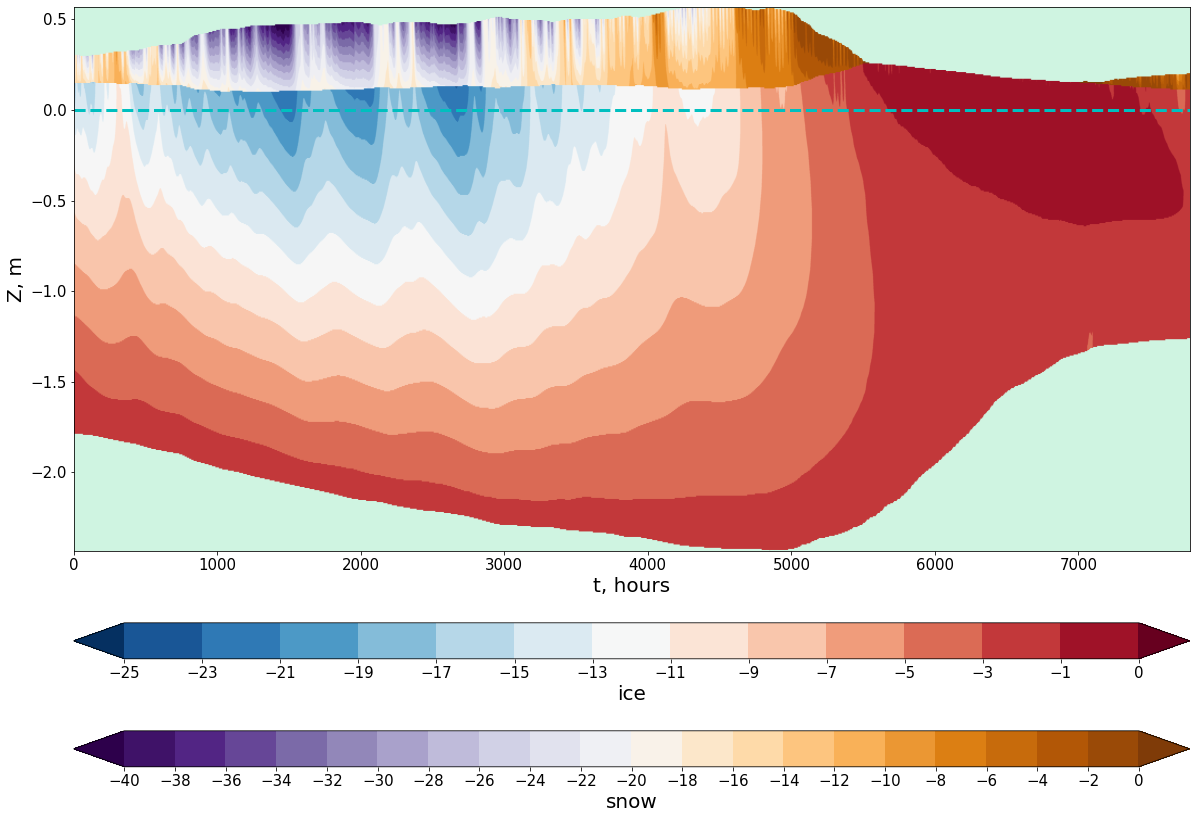

In [30]:
uv.timeseries_img(sim_proc_ni16s0ns10s0, y_points=500, figsize=(20, 10),
                  cmap_ice='RdBu_r', tmin_ice =-25.0, tmax_ice =0.0, step_ice=2.0,
                  cmap_snow='PuOr_r',tmin_snow=-40.0, tmax_snow=0.0, step_snow=2.0, savepath='sim16.png')

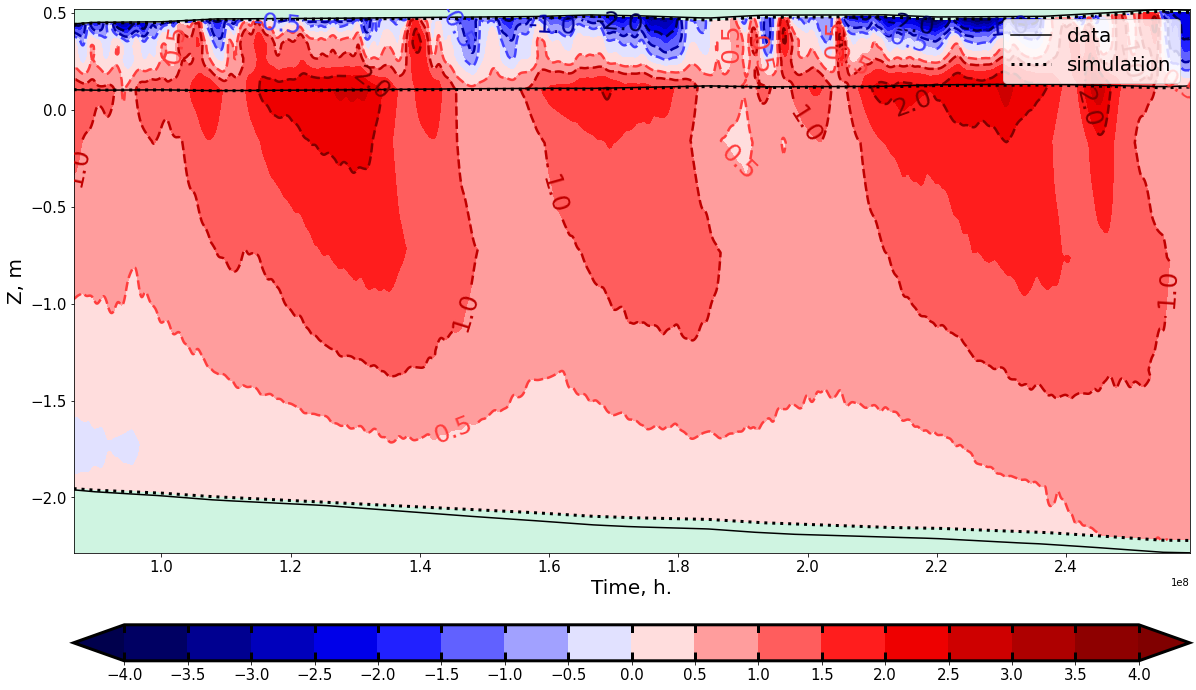

In [53]:
uv.timeseries_err(sim_proc_ni4s0ns10s0[1000:3000],
                  data_proc_ni4s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.5,
                  figsize=(20, 10),
                  y_points=500, savepath='conv_4cells.png')

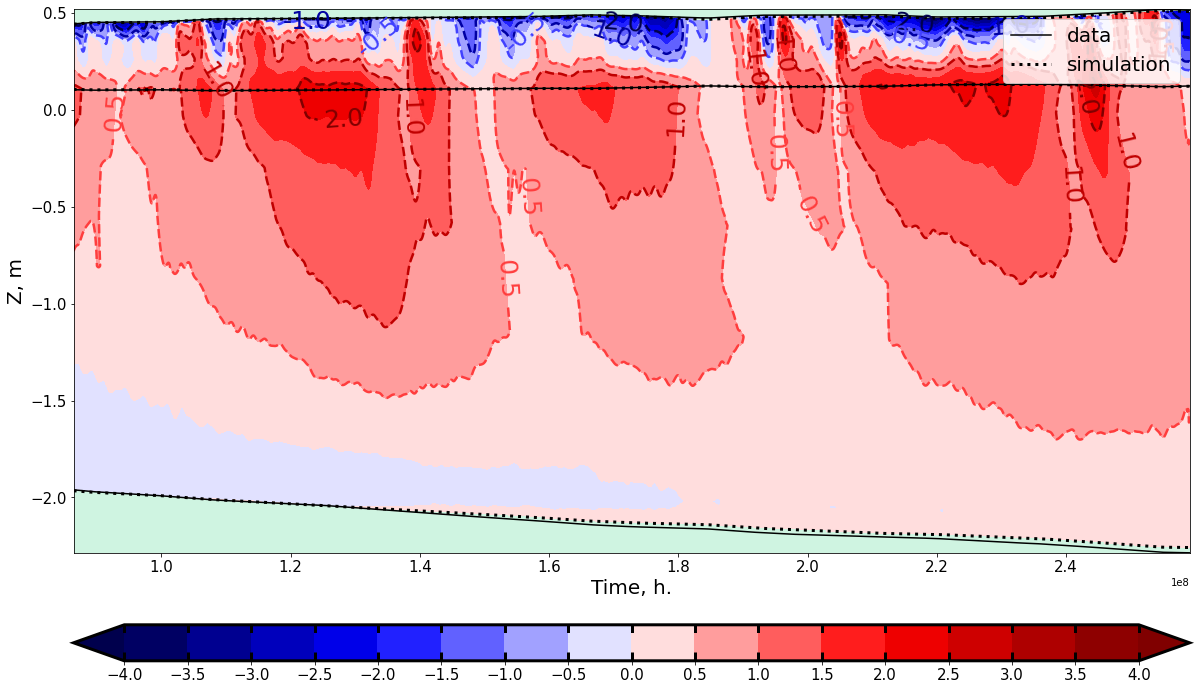

In [54]:
uv.timeseries_err(sim_proc_ni8s0ns10s0[1000:3000],
                  data_proc_ni8s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.5,
                  figsize=(20, 10),
                  y_points=500, savepath='conv_8cells.png')

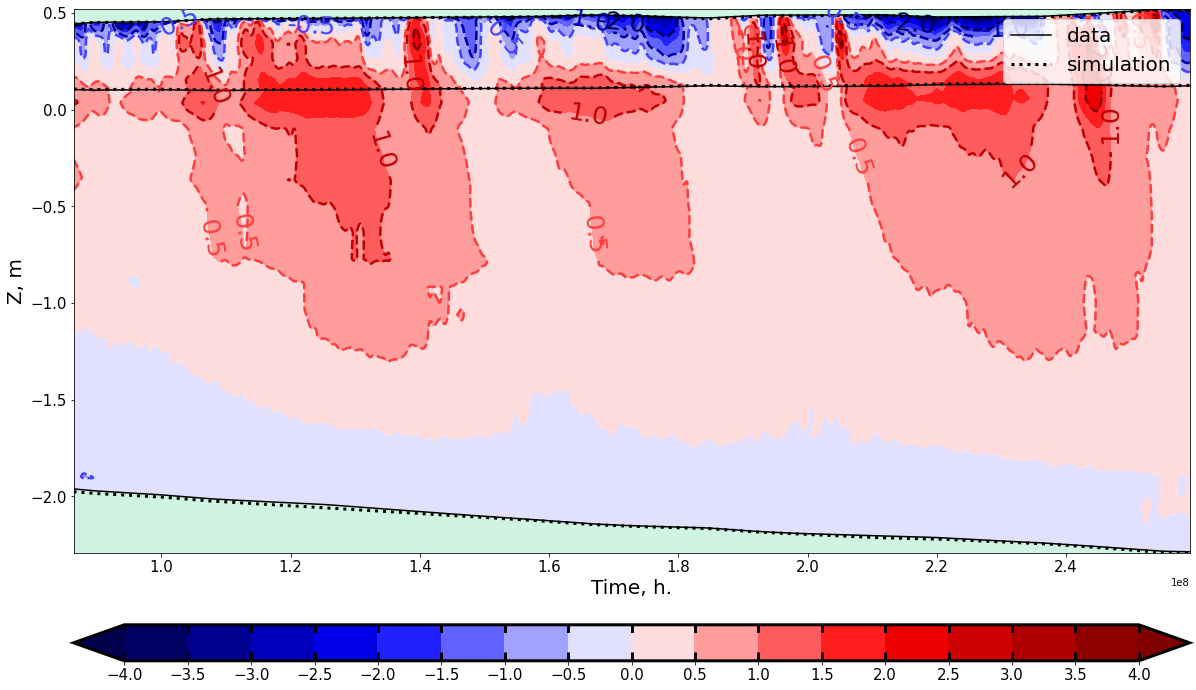

In [56]:
uv.timeseries_err(sim_proc_ni16s0ns10s0[1000:3000],
                  data_proc_ni16s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.5,
                  figsize=(20, 10),
                  y_points=500, savepath='conv_16cells.png')

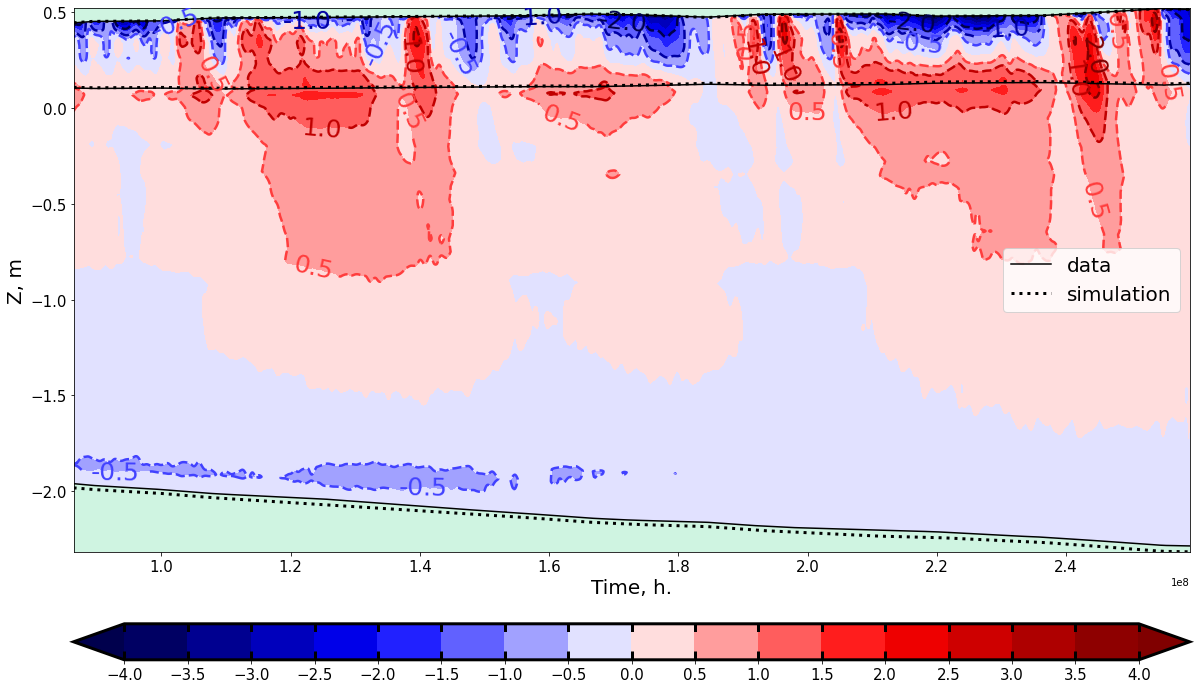

In [57]:
uv.timeseries_err(sim_proc_ni32s0ns10s0[1000:3000],
                  data_proc_ni32s0ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.5,
                  figsize=(20, 10),
                  y_points=500, savepath='conv_32cells.png')

/home/chuck/Desktop/ice_thermodynamics/Python/utils/visualizer.py:375: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(gauss_filter_with_nans(data, (sigma_x, sigma_y)),


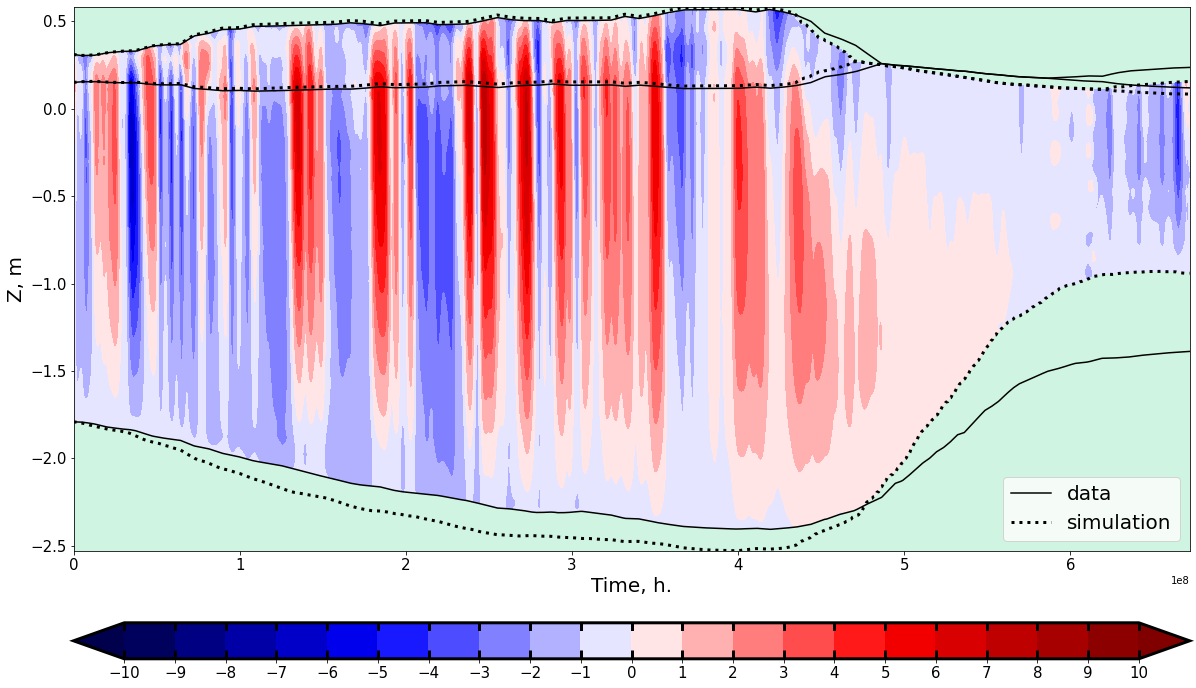

In [63]:
uv.timeseries_err(sim_proc_0d,
                  data_proc_ni32s0ns10s0,
                  tmin_err=-10.0, tmax_err=10.0, step_err=1.0,
                  figsize=(20, 10),
                  y_points=500,
                  levels_border=[], savepath='diff_od.png')

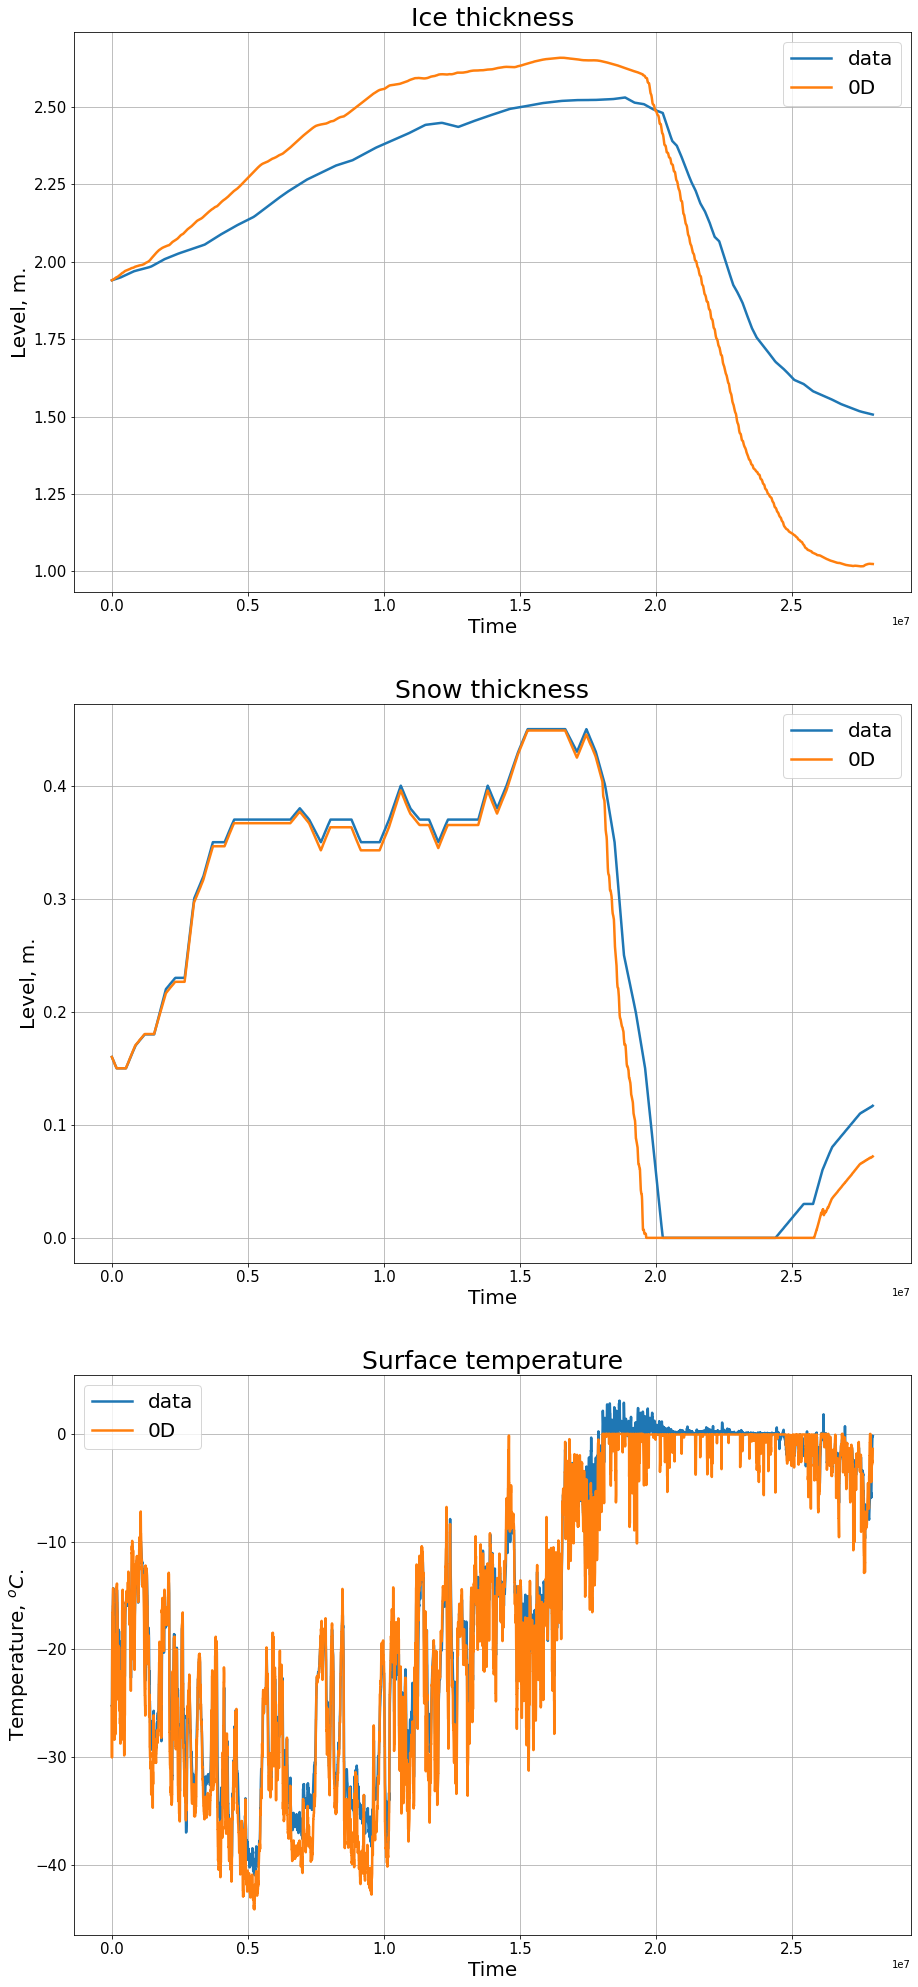

In [65]:
uv.plot_characteristics([data_proc_ni32s0ns10s0, sim_proc_0d],
                         ['data', '0D'])

In [ ]:
uv.plot_characteristics([test_process_1d, test_process_0d],
                         ['1D', '0D'])

In [66]:
def plot_errors(process_data, sim_process_list, labels, savepath=None):
    assert len(sim_process_list) == len(labels) - 1, \
    "Length of labels should be more than length of simulation processes list by one!"
    
    fig, (ax_ice_err, ax_snow_err, ax_Tsu_err) = plt.subplots(nrows=3, figsize=(15, 35))
    
    for process, label in zip(sim_process_list, labels):
        ax_ice_err.plot(process_data.timeline, process_data.ice_dz_history.sum(axis=1) \
                                             - process.ice_dz_history.sum(axis=1), 
                        label=label, lw=2.5)
        ax_snow_err.plot(process_data.timeline, process_data.snow_dz_history.sum(axis=1) \
                                              - process.snow_dz_history.sum(axis=1), 
                        label=label, lw=2.5)
        ax_Tsu_err.plot(process.timeline,
                    np.where(process_data.snow_presence_history,
                             process_data.sa_temp_history, process_data.is_temp_history) \
                  - np.where(process.snow_presence_history,
                             process.sa_temp_history, process.is_temp_history),
                    label=label, lw=2.5)
    
    ax_ice_err.set_title('Ice thickness error', size=25)
    ax_ice_err.set_ylabel('Level, m.', size=20)
    ax_ice_err.set_xlabel('Time', size=20)
    ax_ice_err.tick_params(axis='both', labelsize=15)
    ax_ice_err.legend(prop={'size': 20})
    ax_ice_err.grid()
    
    ax_snow_err.set_title('Snow thickness error', size=25)
    ax_snow_err.set_ylabel('Level, m.', size=20)
    ax_snow_err.set_xlabel('Time', size=20)
    ax_snow_err.tick_params(axis='both', labelsize=15)
    ax_snow_err.legend(prop={'size': 20})
    ax_snow_err.grid()
    
    ax_Tsu_err.set_title('Surface temperature error', size=25)
    ax_Tsu_err.set_ylabel(r'Temperature, $^o C.$', size=20)
    ax_Tsu_err.set_xlabel('Time', size=20)
    ax_Tsu_err.tick_params(axis='both', labelsize=15)
    ax_Tsu_err.legend(prop={'size': 20})
    ax_Tsu_err.grid()
    
    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight')
    else:
        plt.show()

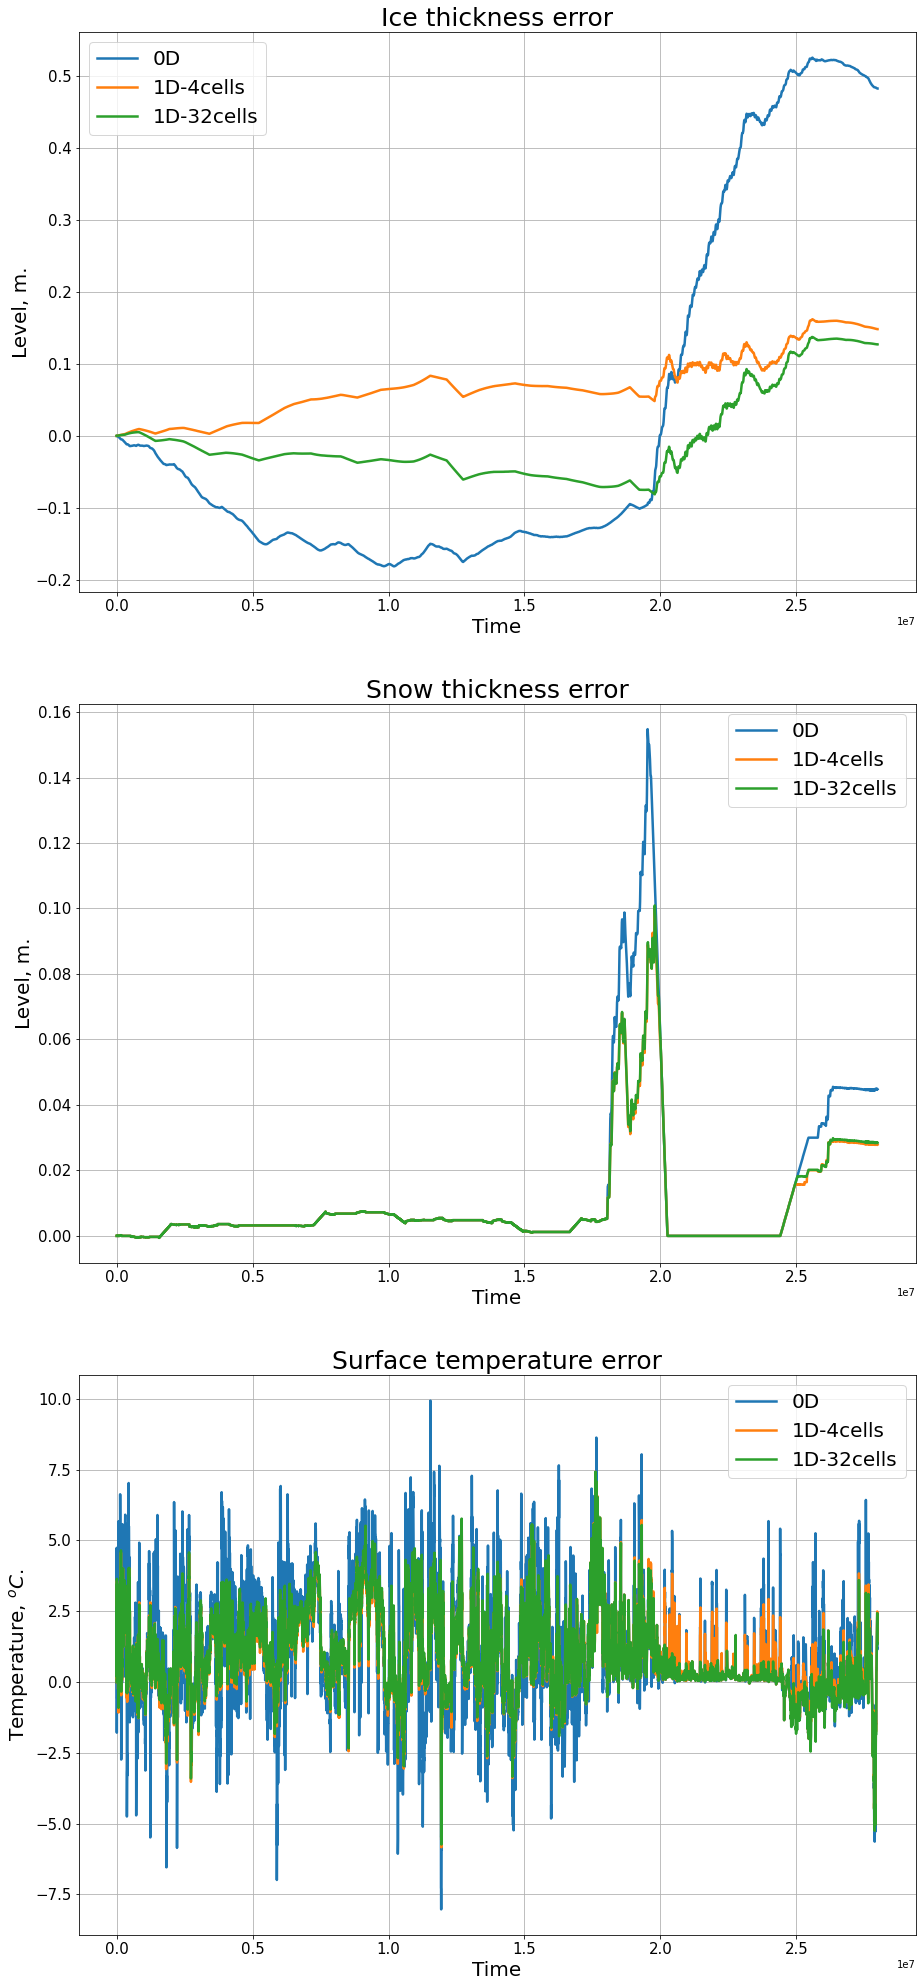

In [72]:
plot_errors(process_data=data_proc_ni32s0ns10s0,
            sim_process_list=[sim_proc_0d, sim_proc_ni4s0ns10s0, sim_proc_ni32s0ns10s0],
            labels=['0D', '1D-4cells', '1D-32cells', 'bla'],
            savepath=None)

## Эксперименты на сгущенной сетке (Ni = 4)

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Ice thickness')
plt.plot(sim_proc.ice_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plot_thickening(N=4, max_thick=0.41, step_thick=0.05)

In [ ]:
# thickened mesh
dsigma_ice_n4s20 = thickening(4, 0.2)
dsigma_ice_n4s35 = thickening(4, 0.35)

dsigma_snow_n10s0 = thickening(15, 0.0)

In [ ]:
# init state from data
T_ice_init4_s20, T_snow_init4_s20, Toi_init4_s20, Tis_init4_s20, Tsa_init4_s20, \
dzi_init4_s20, dzs_init4_s20 = get_init_from_data(data, Z, dsigma_ice_n4s20, dsigma_snow_n10s0)

T_ice_init4_s35, T_snow_init4_s35, Toi_init4_s35, Tis_init4_s35, Tsa_init4_s35, \
dzi_init4_s35, dzs_init4_s35 = get_init_from_data(data, Z, dsigma_ice_n4s35, dsigma_snow_n10s0)

In [ ]:
# process from data
data_proc_ni4s20ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n4s20, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

data_proc_ni4s35ns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n4s35, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

In [ ]:
%%time
sim_proc_ni4s20ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init4_s20,
    Ts_init=T_snow_init4_s20,
    Tis_init=Tis_init4_s20,
    Tsa_init=Tsa_init4_s20,
    dzi_init=dzi_init4_s20,
    dzs_init=dzs_init4_s20,
    salinity=np.linspace(4.0, 1.0, len(dzi_init4_s20)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
%%time
sim_proc_ni4s35ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init4_s35,
    Ts_init=T_snow_init4_s35,
    Tis_init=Tis_init4_s35,
    Tsa_init=Tsa_init4_s35,
    dzi_init=dzi_init4_s35,
    dzs_init=dzs_init4_s35,
    salinity=np.linspace(4.0, 1.0, len(dzi_init4_s35)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
uv.timeseries_err(sim_proc_ni4s20ns10s0[1000:3000],
                  data_proc_ni4s20ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20, 10))

In [ ]:
uv.timeseries_err(sim_proc_ni4s35ns10s0[1000:3000],
                  data_proc_ni4s35ns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20,10))

## Эксперименты на сгущенной сетке (Ni = 16)

In [ ]:
plot_thickening(N=8, max_thick=0.41, step_thick=0.05)

In [ ]:
# thickened mesh
dsigma_ice_n16t = np.concatenate((thickening(4, 0.0)/2.0, thickening(12, 0.0)/2))


In [ ]:
# init state from data
T_ice_init_n16t, T_snow_init_n16t, Toi_init_n16t, Tis_init_n16t, Tsa_init_n16t, \
dzi_init_n16t, dzs_init_n16t = get_init_from_data(data, Z, dsigma_ice_n16t, dsigma_snow_n10s0)

In [ ]:
# process from data
data_proc_ni16tns10s0 = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_n16t, dsigma_snow_n10s0,
                                 time_arr, ue.rho_i)

In [ ]:
%%time
sim_proc_ni4s35ns10s0 = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init_n16t,
    Ts_init=T_snow_init_n16t,
    Tis_init=Tis_init_n16t,
    Tsa_init=Tsa_init_n16t,
    dzi_init=dzi_init_n16t,
    dzs_init=dzs_init_n16t,
    salinity=np.linspace(4.0, 1.0, len(dzi_init_n16t)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
uv.timeseries_err(sim_proc_ni4s35ns10s0[1000:3000],
                  data_proc_ni16tns10s0[1000:3000],
                  tmin_err=-4., tmax_err=4., step_err=.2,
                  figsize=(20,10))

In [ ]:
uv.timeseries_err(sim_proc_0d,
                  data_proc_ni64s0ns10s0,
                  levels_border=[],
                  tmin_err=-4., tmax_err=4., step_err=1,
                  figsize=(20, 10))